In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 154453805


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 154453805

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 8 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 19 2019 TESS-SPOC    1800   154453805      0.0         N/A
  1 TESS Sector 20 2019 TESS-SPOC    1800   154453805      0.0         N/A
  2 TESS Sector 26 2020      SPOC     120   154453805      0.0     G022208
  3 TESS Sector 40 2021 TESS-SPOC     600   154453805      0.0         N/A
  4 TESS Sector 47 2021 TESS-SPOC     600   154453805      0.0         N/A
  5 TESS Sector 53 2022 TESS-SPOC     600   154453805      0.0         N/A
  6 TESS Sector 59 2022 TESS-SPOC     200   154453805      0.0         N/A
  7 TESS Sector 60 2022 TESS-SPOC     200   154453805      0.0         N/A

50121

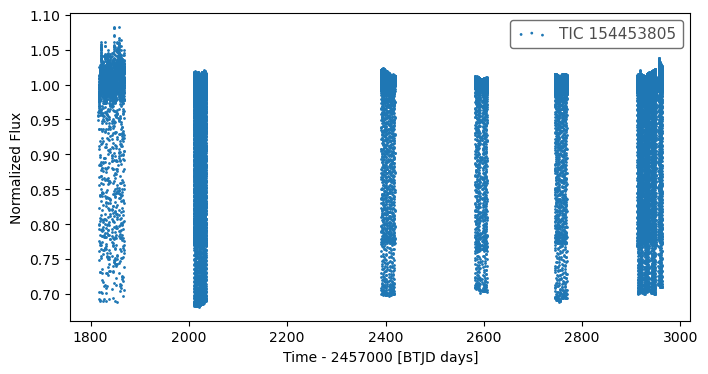

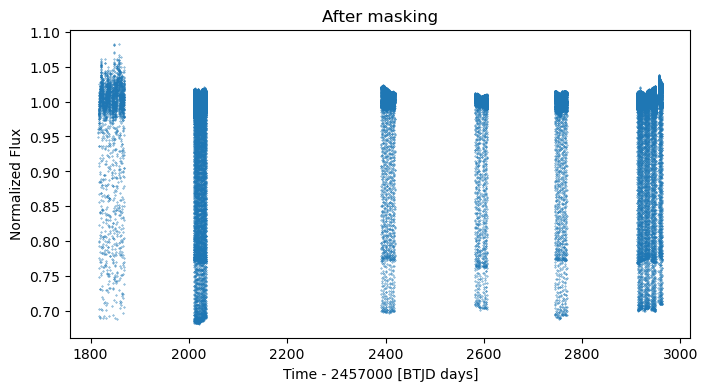

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

In [8]:
0.5458744271024323 * 2

1.0917488542048646

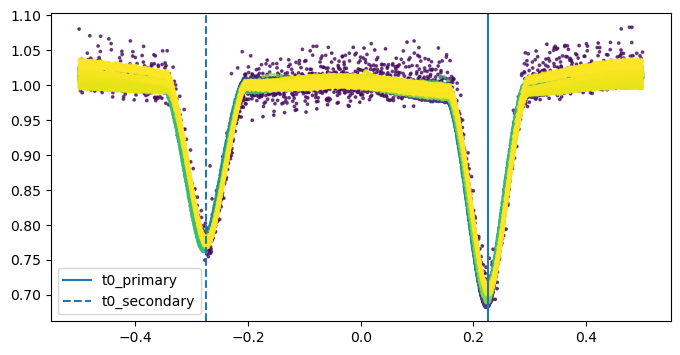

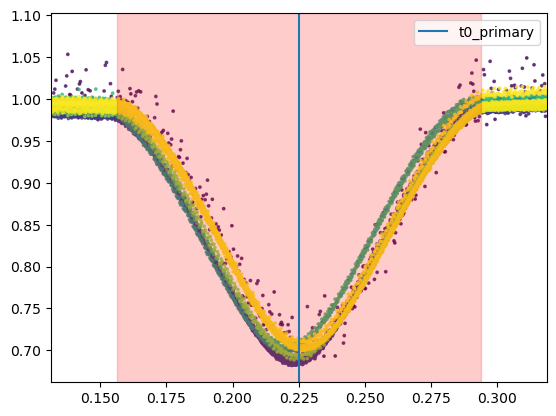

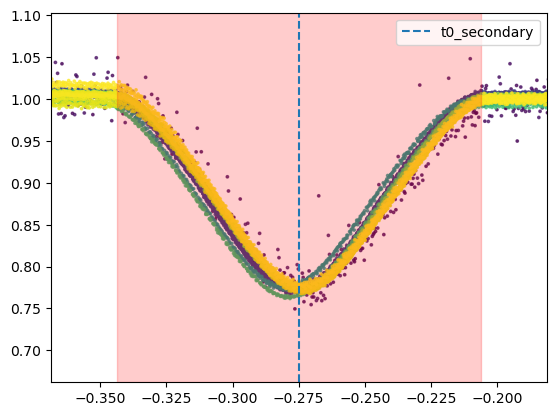

In [16]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=2010.3586, duration_hr=2.0000, period=0.545934, label="s0026-s0026:TCE1",
# VSX: 1.091739 
# Gaia DR3 Var: 1.0917226577344548
# LS Period (oversampling_factor=25): 0.5458744271024323 (half), or 1.091749
# LS Period (oversampling_factor=50): 0.5458796253619204 (half), or 1.091759  (worse than above)
# MCMC on df_primary with ingress/egress: 1.0917497608948101
# MCMC on df_primary no   ingress/egress: 1.091749726124946, std_p: 5.21266501348175e-09;  1816.5720031822489, std_t0: 3.5988855499602465e-06
# FILL-IN THE eclipse epoch / period, 
# period = 1.091750 # MCMC Period with ingress/egress, slightly worse than LS visually
period = 1.091749  # LS Period(oversampling_factor=25) X2, still visibly not aligned well.
period = 1.0917497 # MCMC Period with no ingress/egress

t0_primary = 2010.3586 - period / 2
t0_secondary = t0_primary + period / 2


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 3.6 
duration_hr_secondary = 3.6

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
plt.xlim(t1_s - 0.025, t4_s + 0.025);
plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
plt.legend();
# plt.ylim(0.975, 1.005);
plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [20]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase

start_vals = [1.012, -0.311, midpoint_p, 0.0342, 0.876]  
start_vals_s = [1.0, -0.23, midpoint_s, 0.033, 0.87]


# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1816.5730282499999 0.2250000000000284
window_width_p (phase): 0.1099153038466601
Secondary: 1817.1189031 -0.27499999999995484
window_width_s (phase): 0.1099153038466601


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.012, -0.311, t0_primary, 0.0342, 0.876, 1.0917497],


In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [02:34<00:00,  6.47it/s]


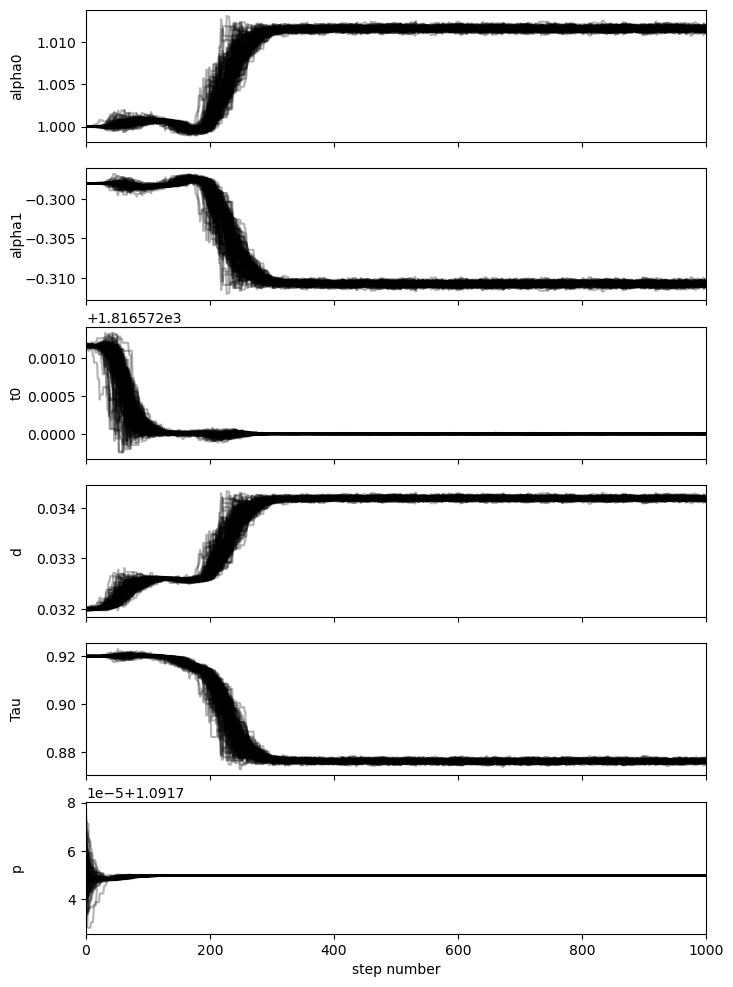

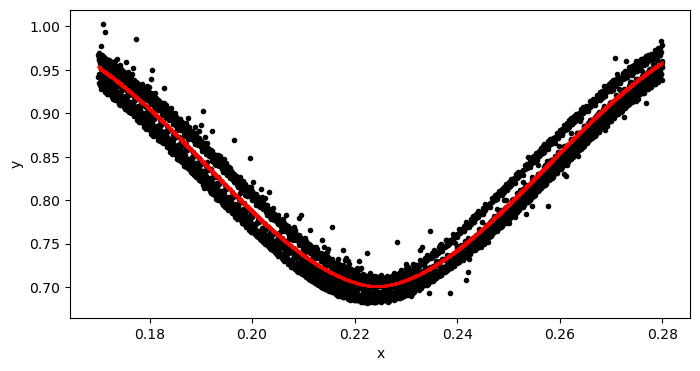

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0116097013447725, -0.3107838339939027, 1816.5720031822489, 0.03418795081637703, 0.8762240298049986, 1.091749726124946
std_p: 5.21266501348175e-09


In [12]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # with ingress/egress:
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0002292920825016, -0.2980628979875455, 1816.5719502739912, 0.03244620138496772, 0.9226607597684272, 1.0917497608948101
    # std_p: 5.011476460582202e-09
    # no ingress/egress:
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0116097013447725, -0.3107838339939027, 1816.5720031822489, 0.03418795081637703, 0.8762240298049986, 1.091749726124946
    # std_p: 5.21266501348175e-09 ; std_t0: 3.5988855499602465e-06    
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.298, t0_primary, 0.032, 0.92, 1.091749],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.62it/s]


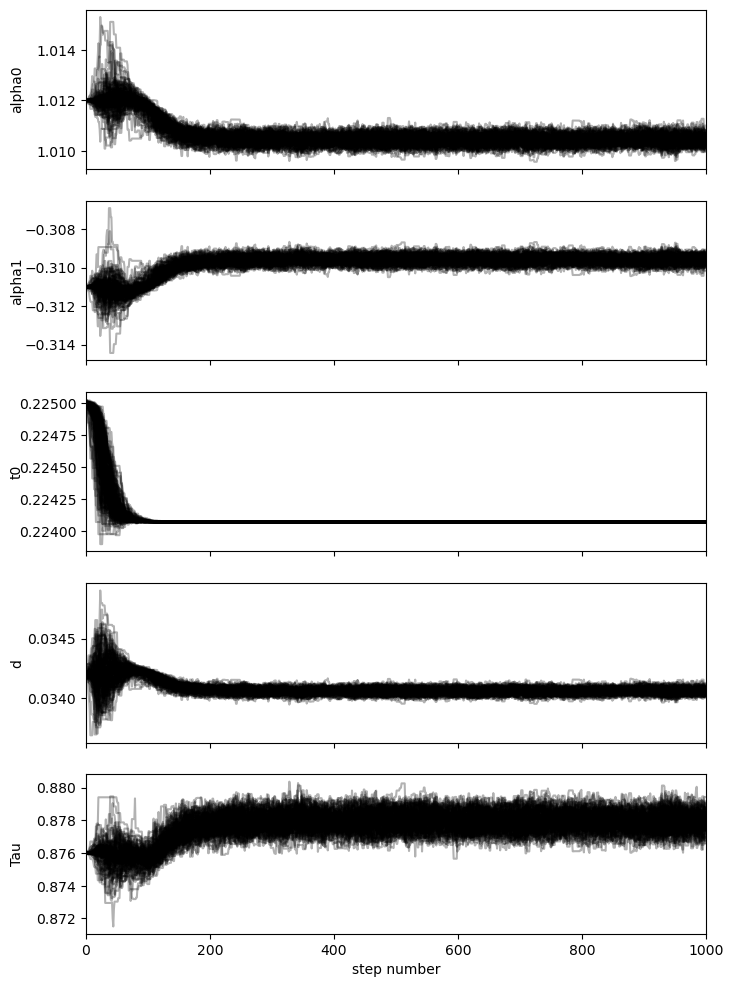

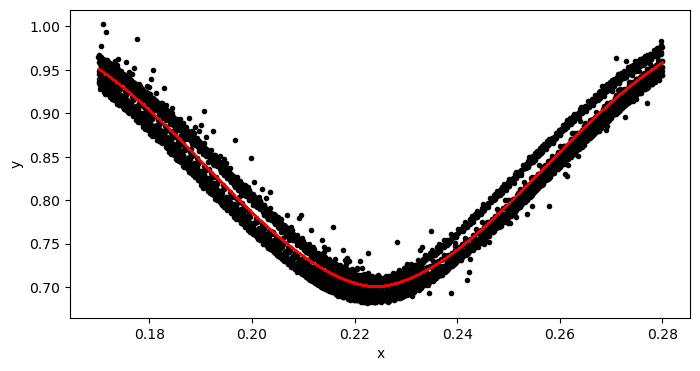

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.85it/s]


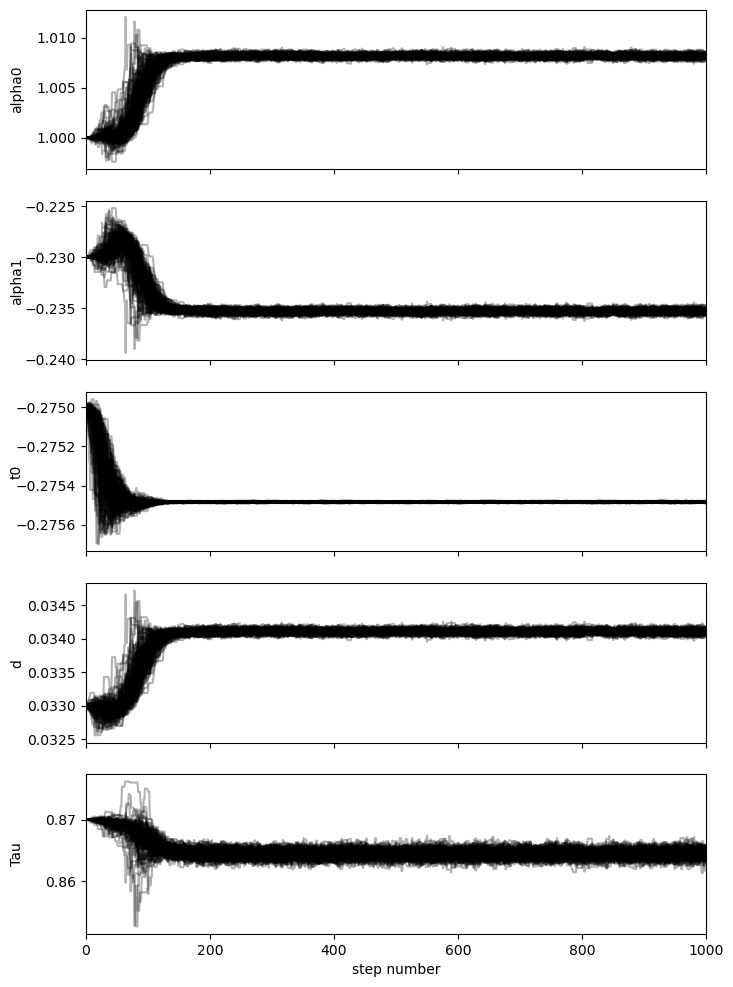

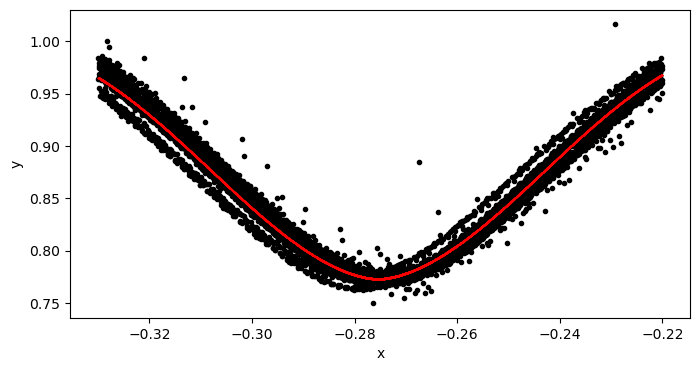

In [21]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data with ingress/egress
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0002800619339094, -0.2981232604718891, 0.2240081203097203, 0.032455636812884964, 0.9223495708300036
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.007230796633519, -0.23329296563102048, -0.2754585327907713, 0.03326361748135292, 0.9045953519712356
    # initial fit params from TESS data without ingress/egress
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0104505668276413, -0.3095910682479698, 0.22407372998882316, 0.03406061990000395, 0.8779477229063183
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0081653504660109, -0.2353169754335197, -0.27548443343062773, 0.03410267874260788, 0.864437349624859

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [23]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0104505668276413, -0.3095910682479698, 0.22407372998882316, 0.03406061990000395, 0.8779477229063183
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0081653504660109, -0.2353169754335197, -0.27548443343062773, 0.03410267874260788, 0.864437349624859


1049

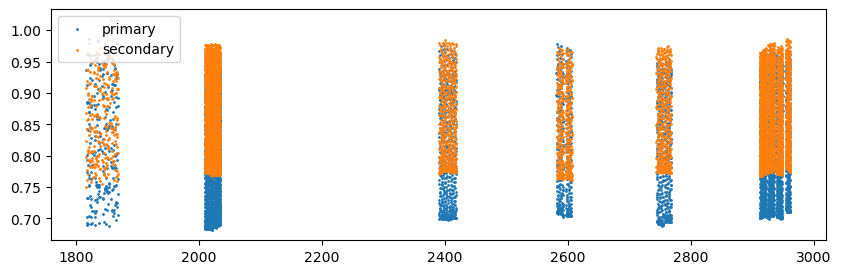

In [24]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1816.5730282499999 1.0917497 1816.5730282499999


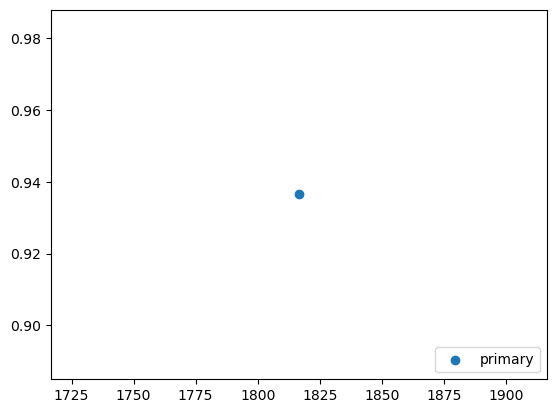

1816.5730282499999 1.0917497 1817.66477795


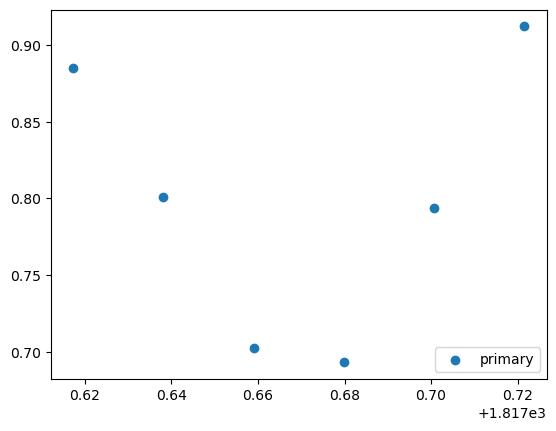

1816.5730282499999 1.0917497 1818.75652765


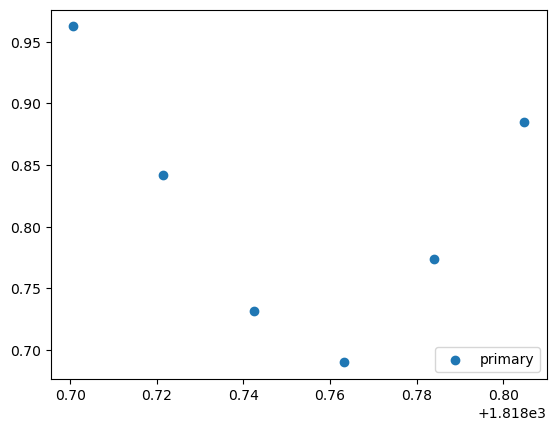

1817.1189031 1.0917497 1817.1189031


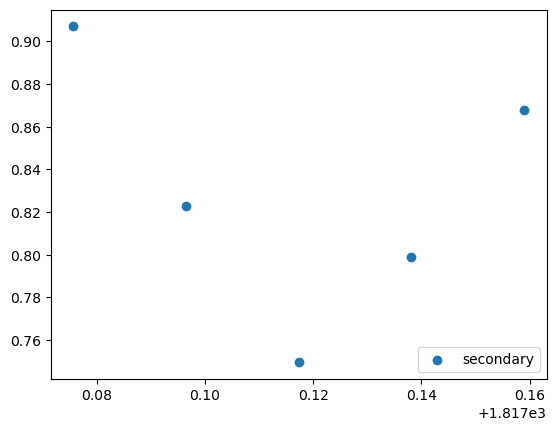

1817.1189031 1.0917497 1818.2106528


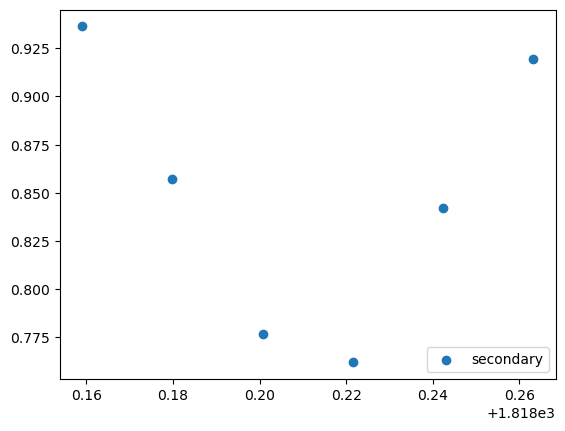

1817.1189031 1.0917497 1819.3024025


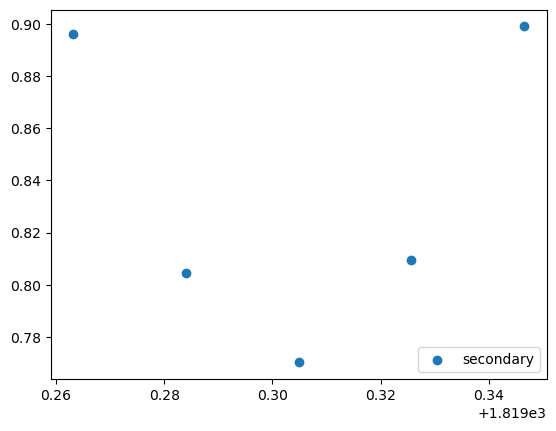

In [25]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Time 1816.5730282499999 does not have enough data points: 1
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Time 1819.84827735 does not have enough data points: 5
Number 4 has already been completed -- skip
Time 1822.0317767499998 does not have enough data points: 5
1823.1235264499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.51it/s]


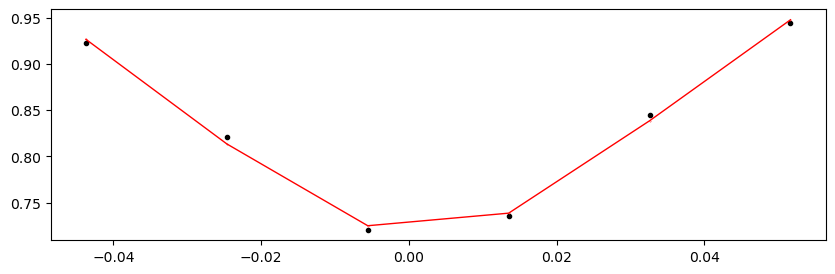

1824.21527615 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.95it/s]


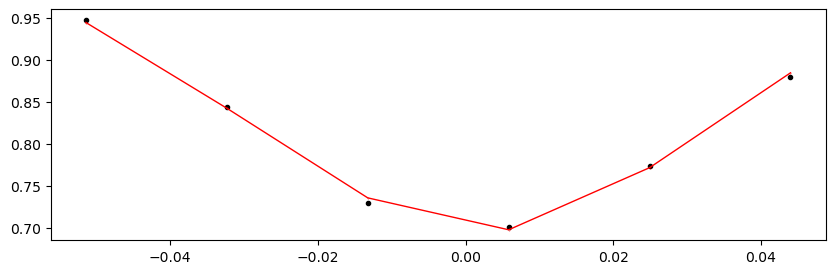

Time 1825.30702585 does not have enough data points: 5
1826.39877555 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.53it/s]


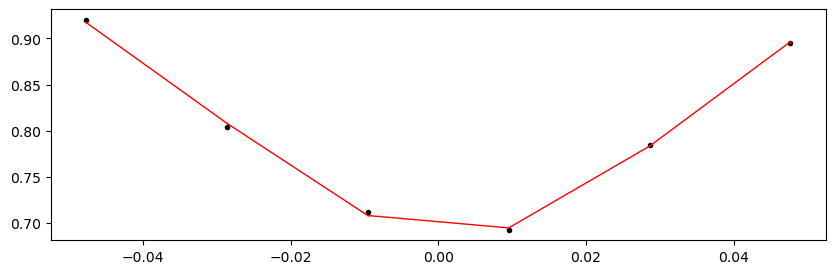

1829.6740246499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.31it/s]


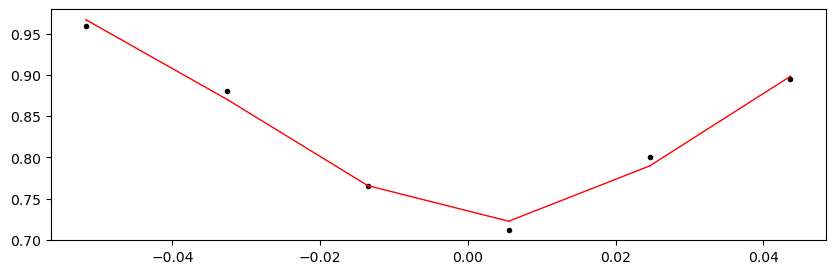

Time 1830.76577435 does not have enough data points: 5
1831.85752405 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.22it/s]


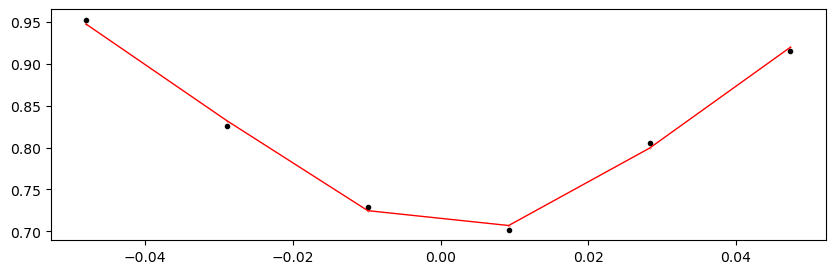

Time 1832.94927375 does not have enough data points: 5
1834.0410234499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.91it/s]


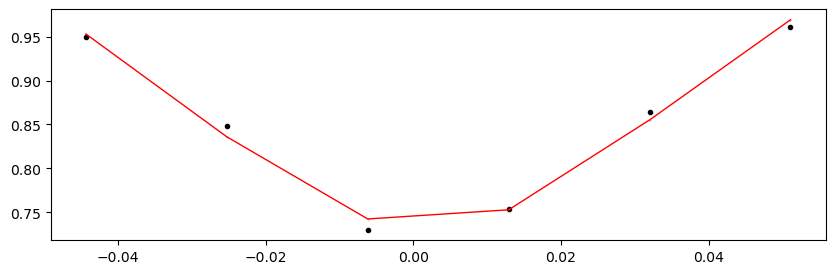

1835.1327731499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.57it/s]


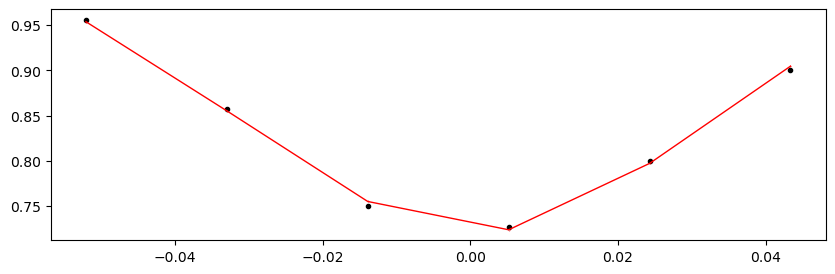

1836.2245228499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.21it/s]


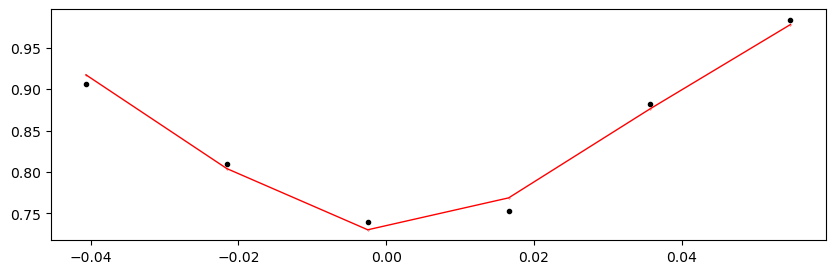

1837.31627255 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.15it/s]


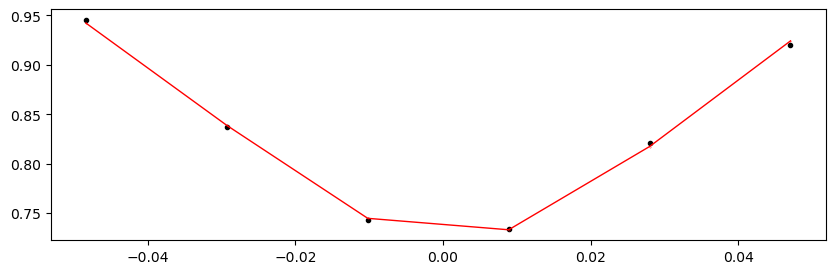

Time 1838.40802225 does not have enough data points: 5
Time 1839.49977195 does not have enough data points: 5
Time 1842.7750210499999 does not have enough data points: 3
Time 1843.86677075 does not have enough data points: 5
1844.95852045 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.13it/s]


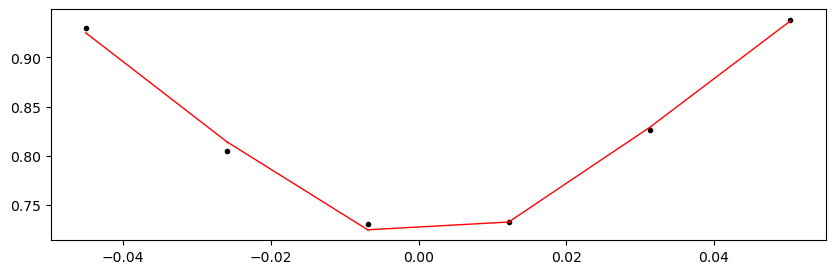

1846.05027015 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.10it/s]


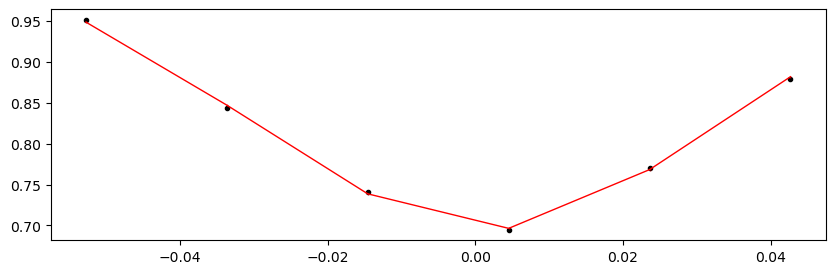

1847.1420198499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.45it/s]


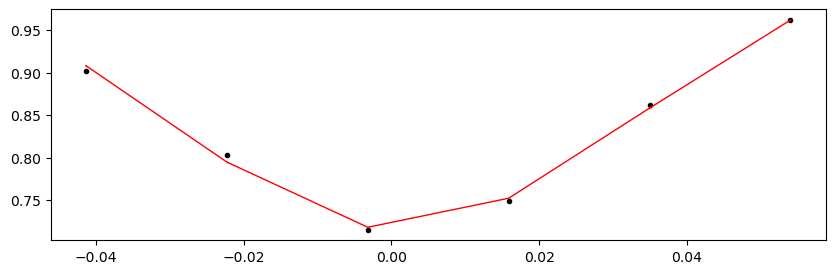

1848.2337695499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.26it/s]


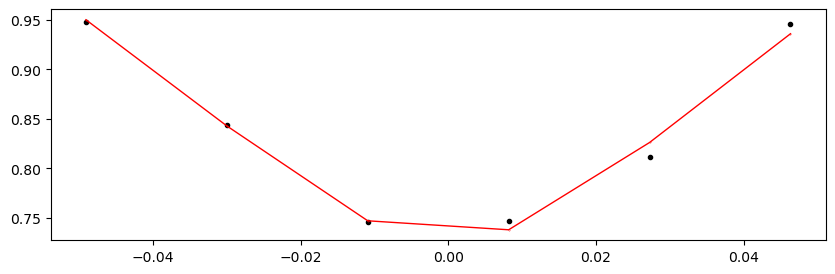

Time 1849.3255192499998 does not have enough data points: 5
1850.4172689499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.56it/s]


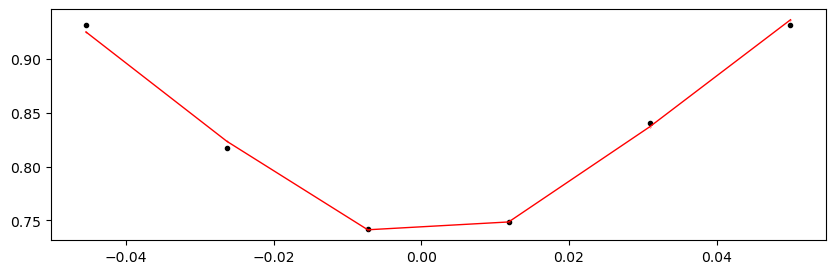

1851.50901865 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.88it/s]


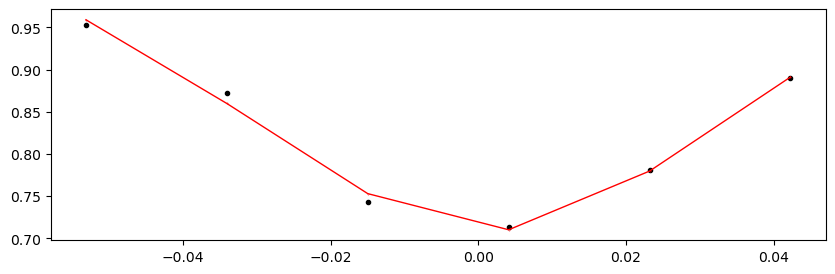

1852.60076835 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.11it/s]


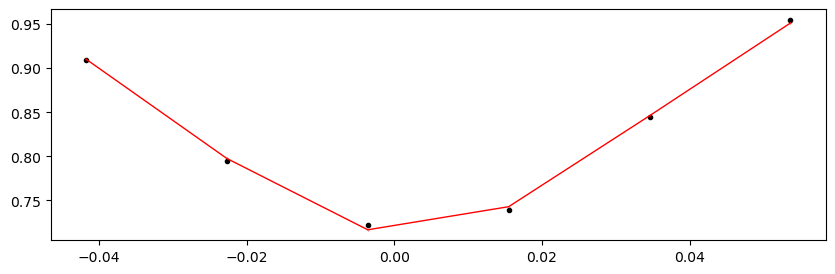

1853.69251805 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.58it/s]


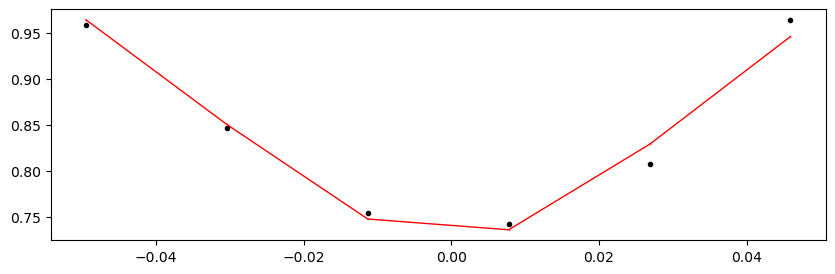

Time 1854.7842677499998 does not have enough data points: 5
Time 1856.9677671499999 does not have enough data points: 5
1858.05951685 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.79it/s]


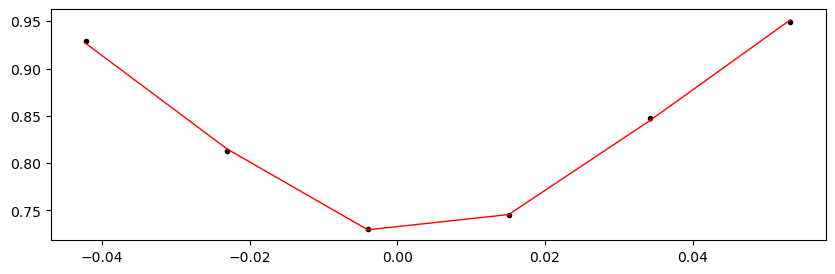

1859.15126655 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.34it/s]


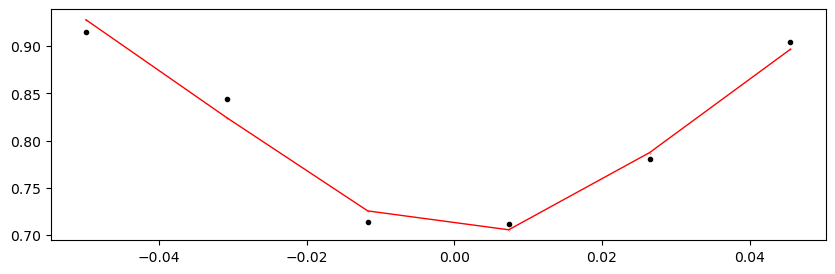

Time 1860.24301625 does not have enough data points: 5
1861.3347659499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.49it/s]


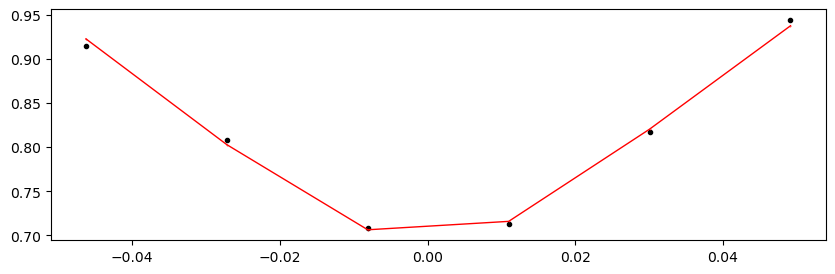

1862.4265156499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.24it/s]


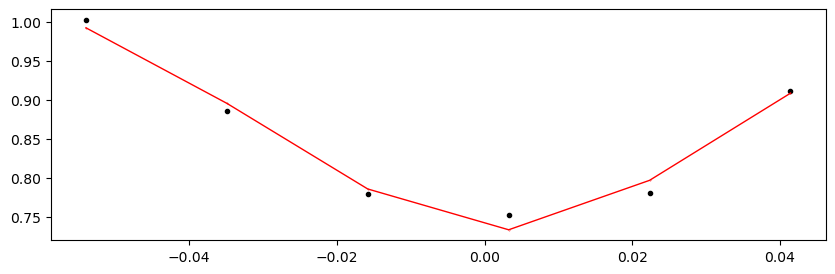

1863.5182653499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.71it/s]


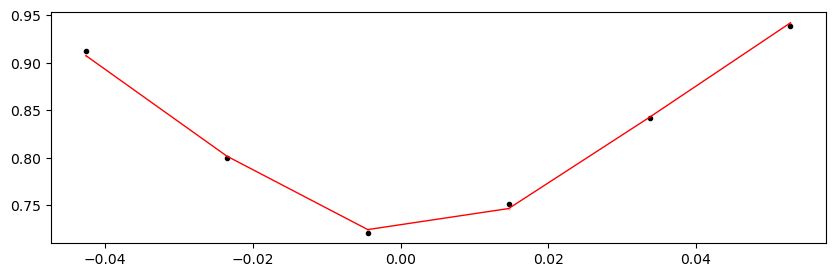

1864.61001505 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.79it/s]


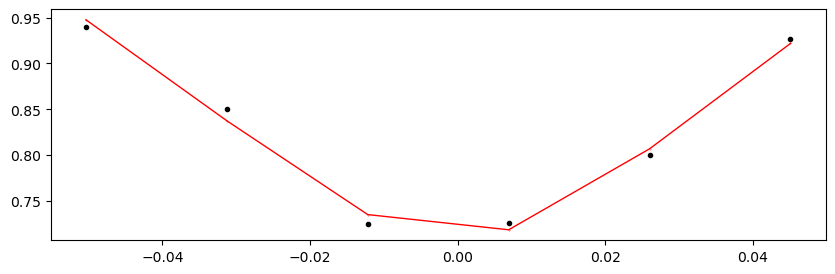

Time 1865.70176475 does not have enough data points: 5
1866.79351445 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.68it/s]


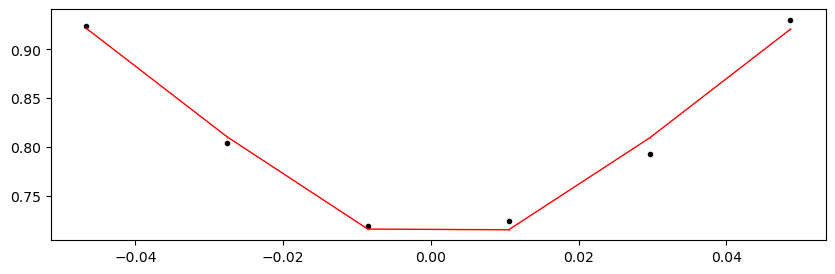

1867.8852641499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.79it/s]


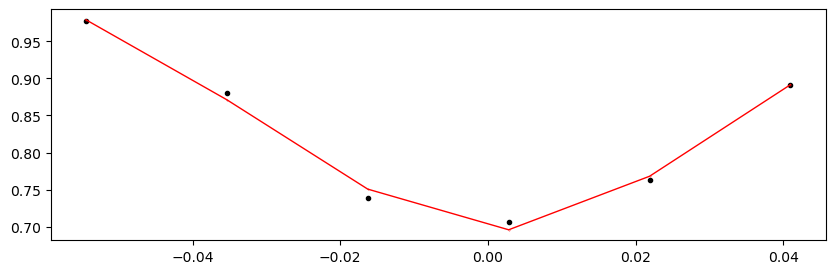

2010.9044748499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.47it/s]


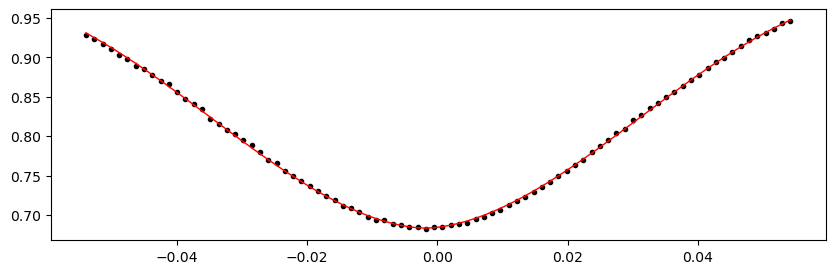

2011.9962245499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.32it/s]


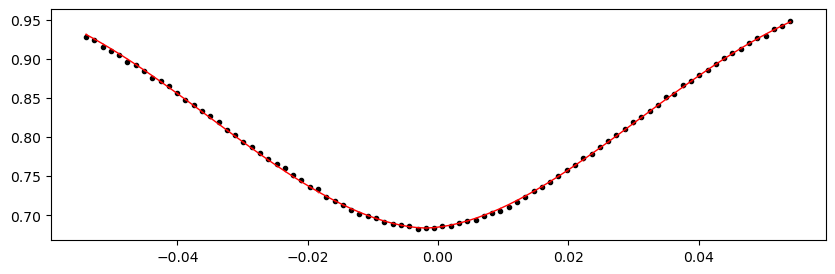

2013.08797425 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.16it/s]


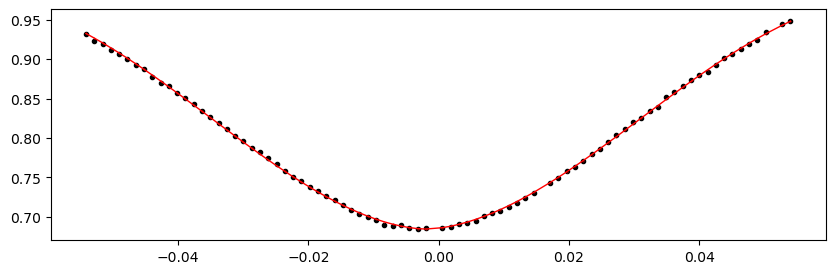

2014.17972395 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.31it/s]


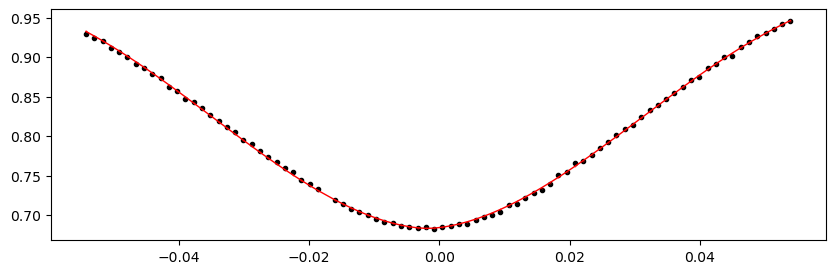

2015.27147365 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.69it/s]


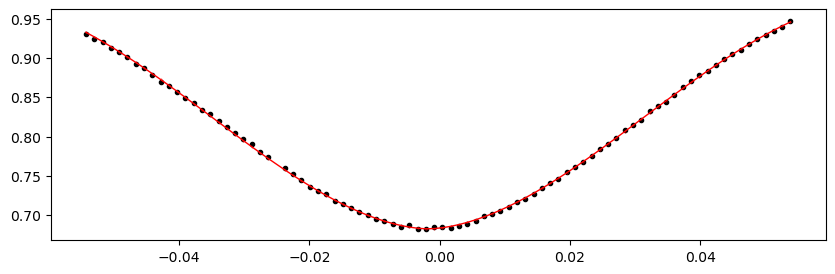

2016.3632233499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.10it/s]


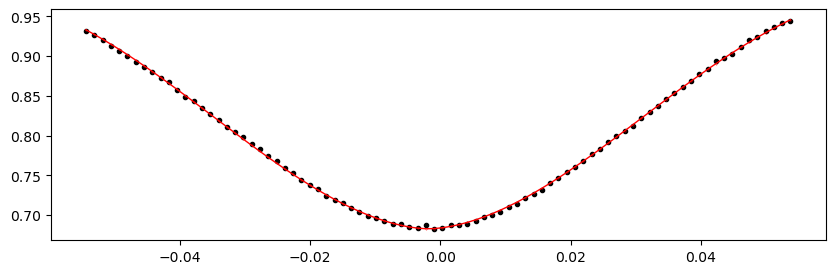

2017.4549730499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.77it/s]


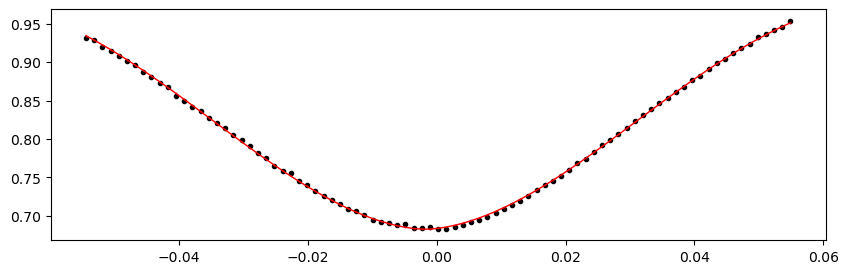

2018.5467227499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.16it/s]


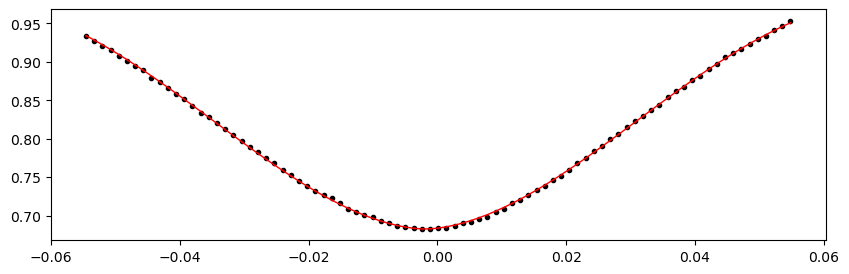

2019.6384724499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.50it/s]


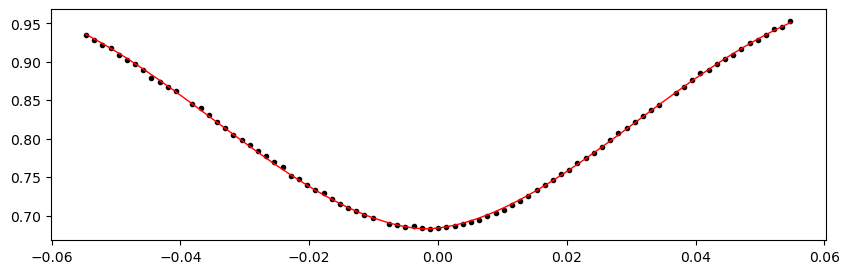

2020.73022215 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.53it/s]


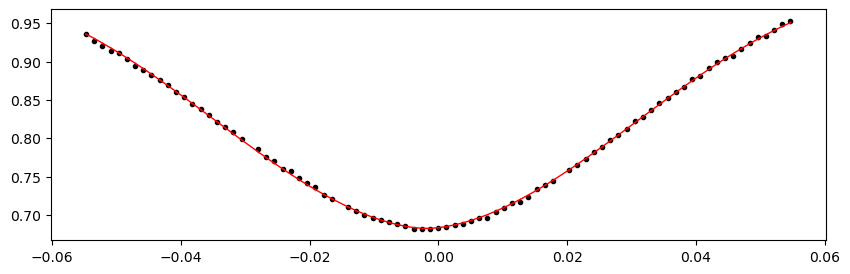

2021.82197185 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.96it/s]


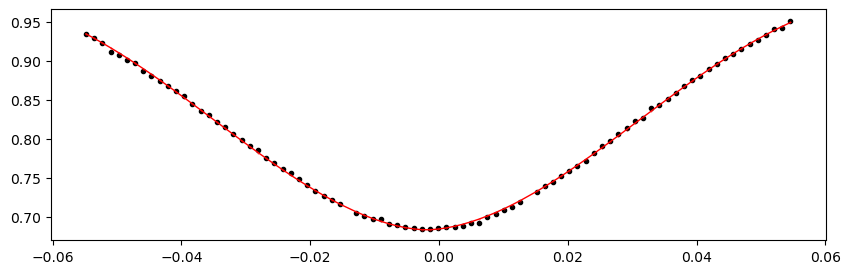

2024.0054712499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.54it/s]


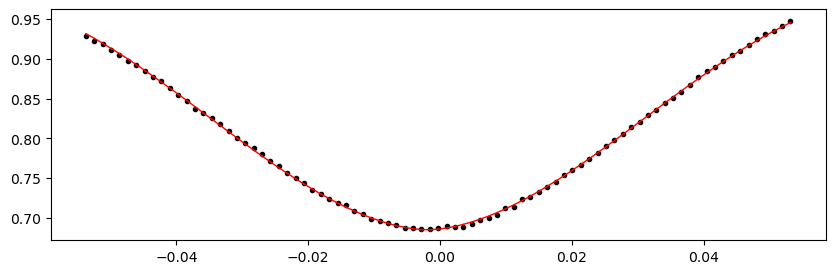

2025.0972209499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.40it/s]


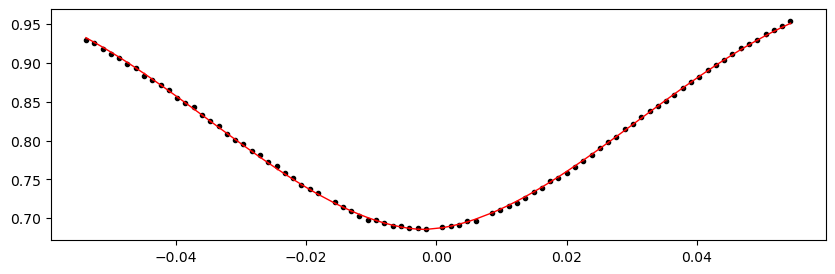

2026.1889706499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.51it/s]


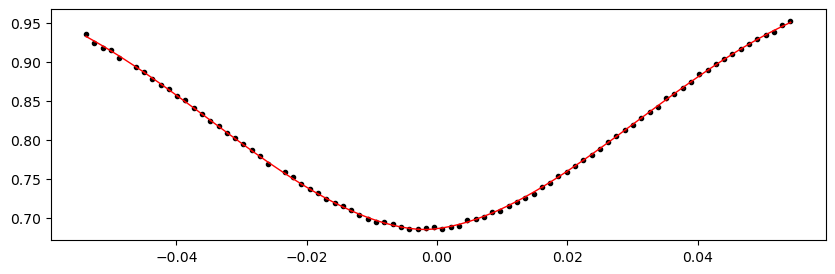

2027.28072035 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.66it/s]


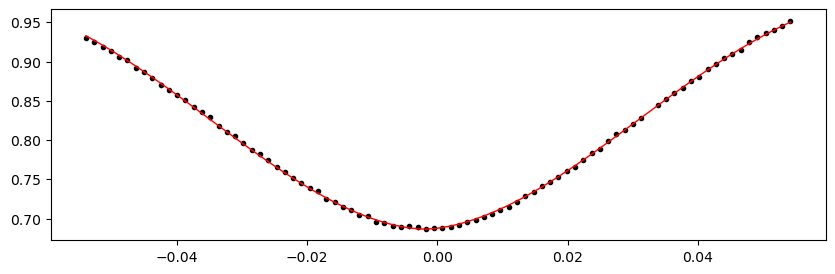

2028.37247005 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.26it/s]


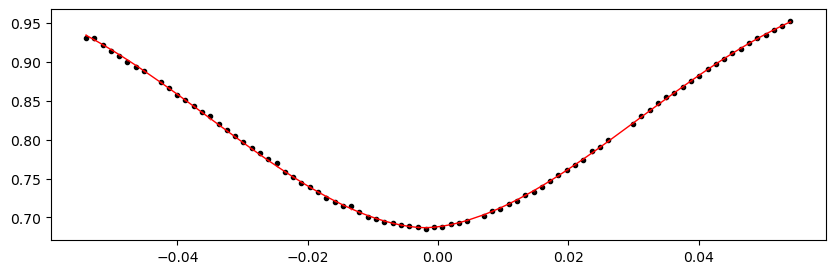

2029.46421975 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.66it/s]


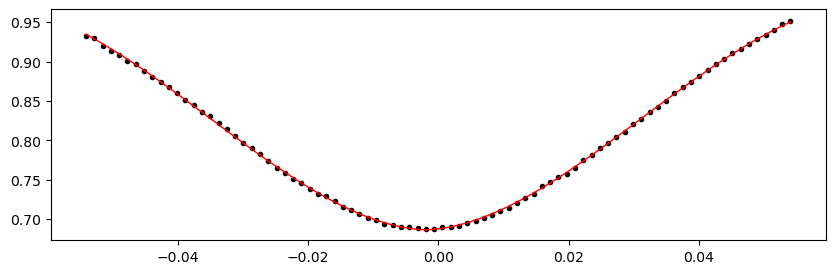

2030.5559694499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.91it/s]


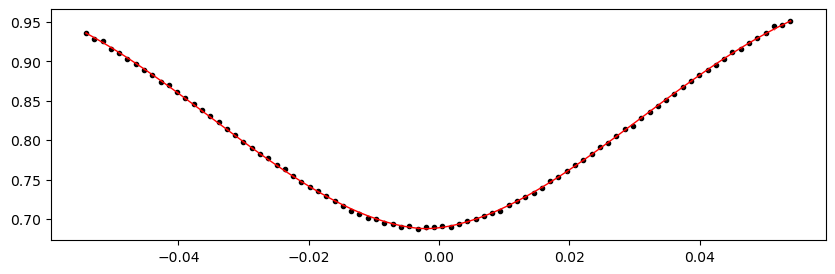

2031.6477191499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.87it/s]


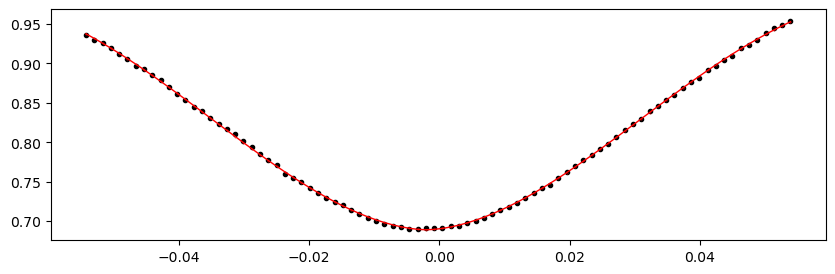

2032.7394688499999 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.88it/s]


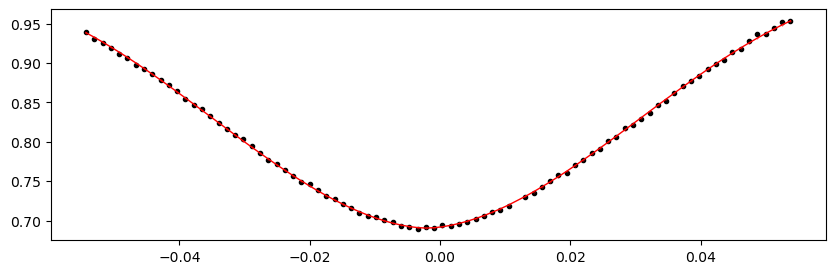

2033.83121855 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.36it/s]


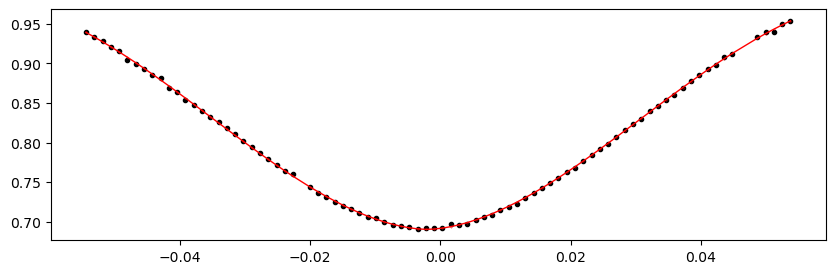

2034.92296825 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.34it/s]


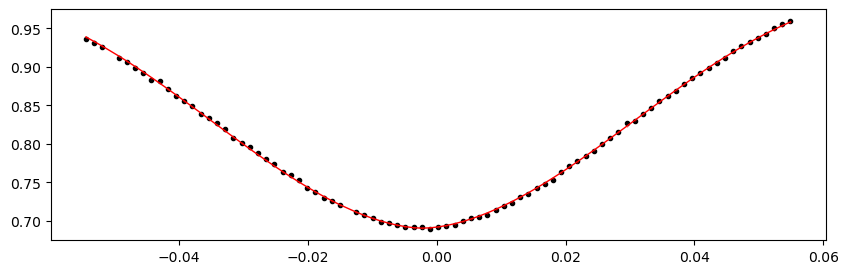

2390.83337045 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.23it/s]


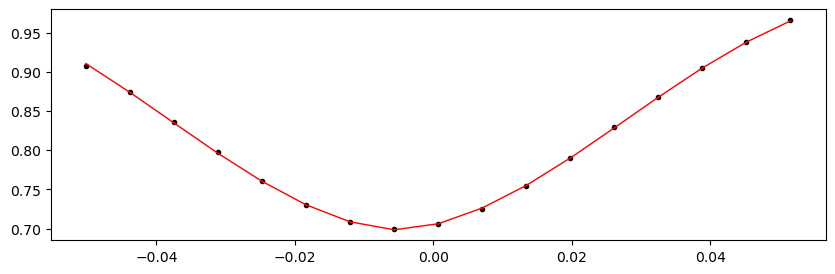

2391.92512015 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.20it/s]


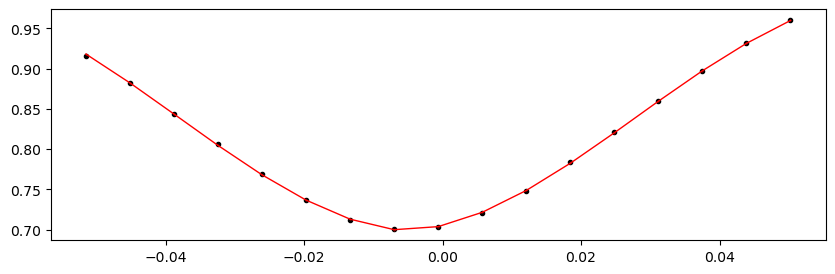

2393.01686985 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.05it/s]


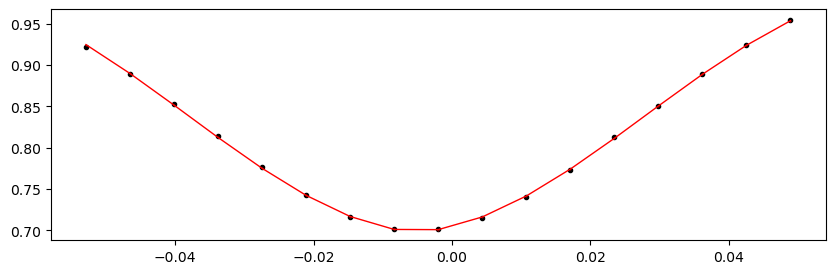

2394.10861955 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.09it/s]


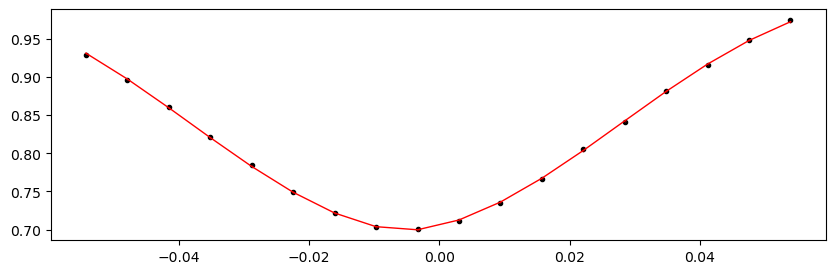

2395.2003692499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.37it/s]


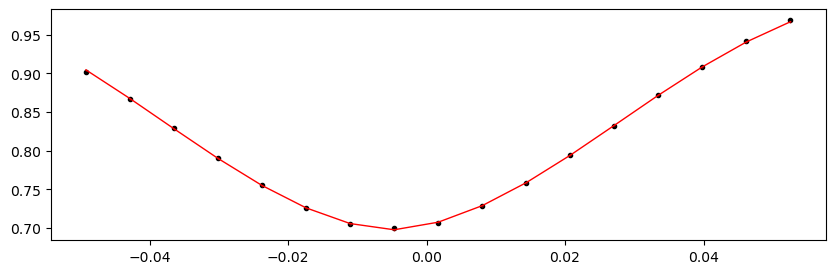

2396.29211895 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.81it/s]


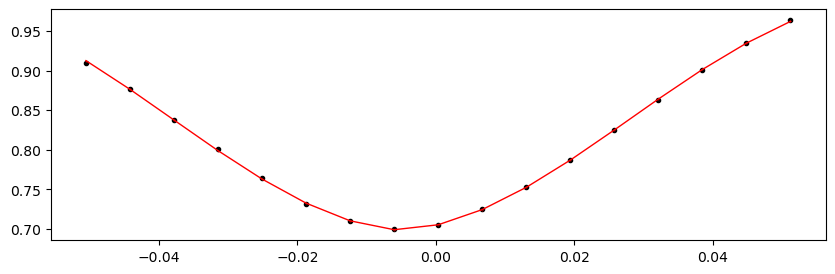

2397.38386865 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.64it/s]


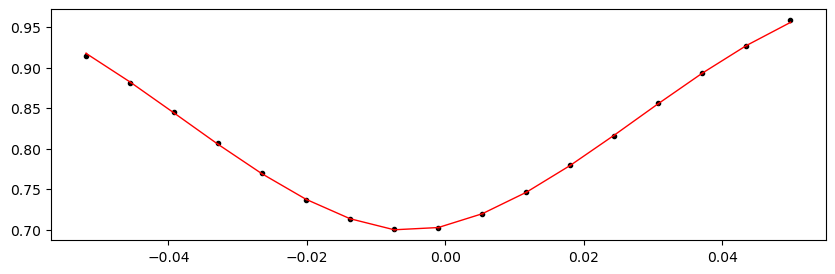

2398.47561835 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.04it/s]


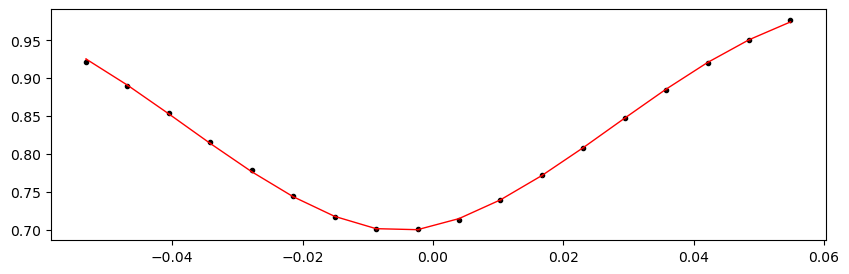

2399.56736805 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.38it/s]


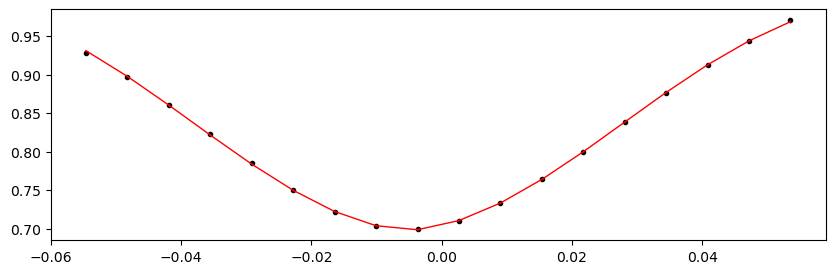

2400.65911775 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.78it/s]


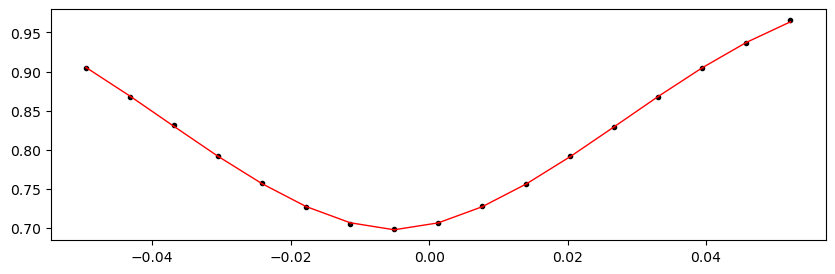

2401.75086745 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.45it/s]


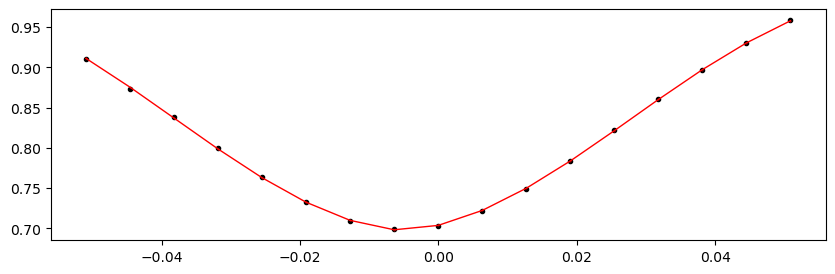

2402.84261715 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.50it/s]


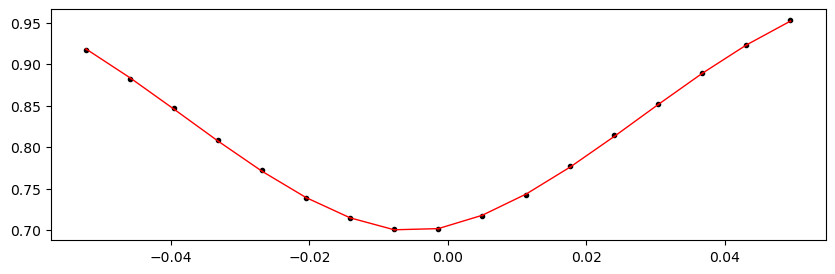

2403.93436685 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.78it/s]


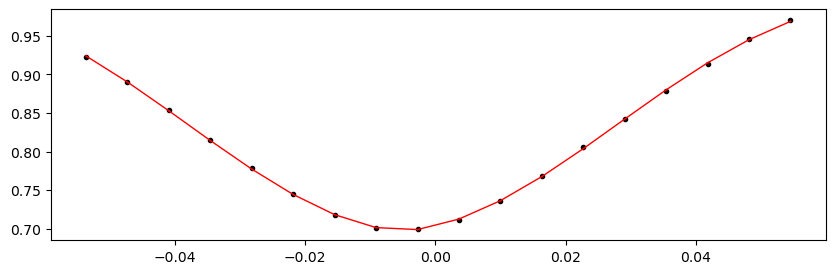

2406.1178662499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.68it/s]


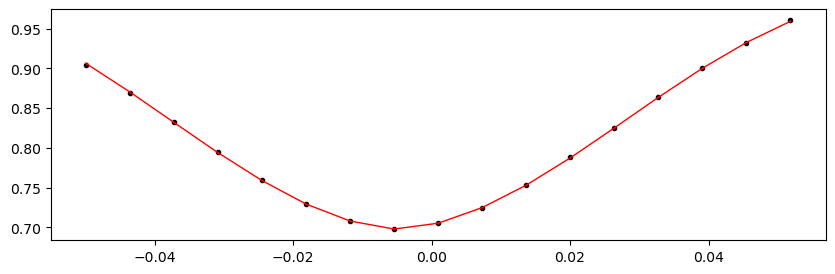

2407.2096159499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.16it/s]


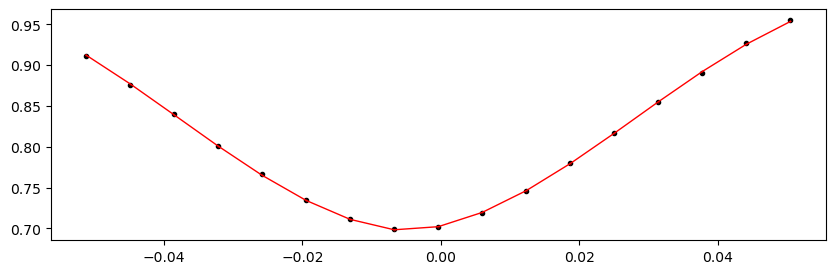

2408.3013656499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.99it/s]


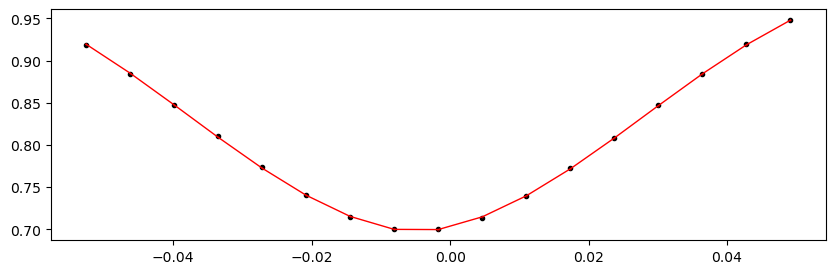

2409.39311535 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.93it/s]


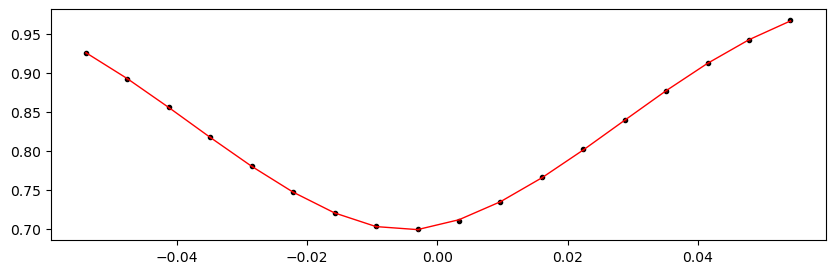

2410.48486505 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.10it/s]


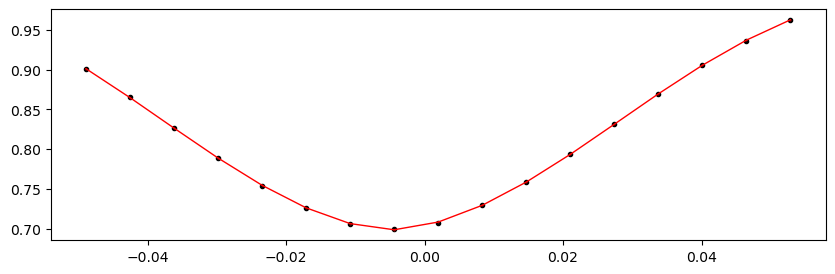

2411.57661475 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.76it/s]


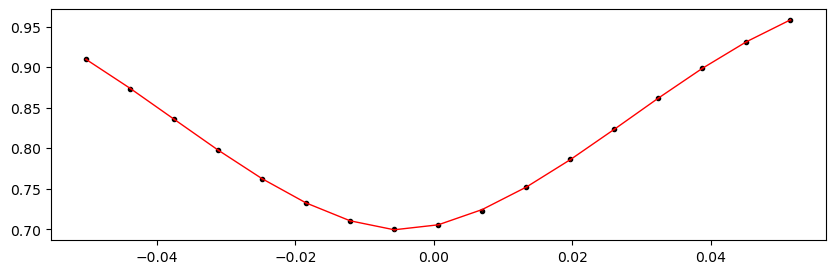

2412.66836445 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.57it/s]


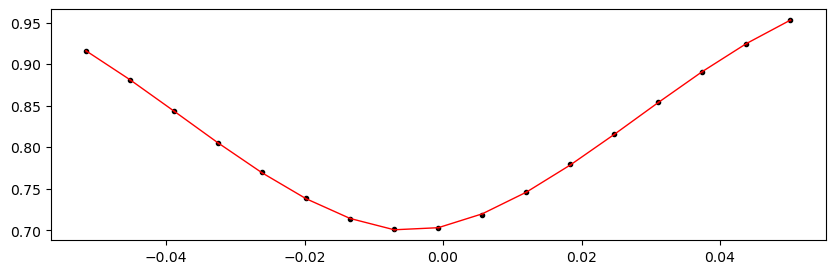

2413.76011415 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.96it/s]


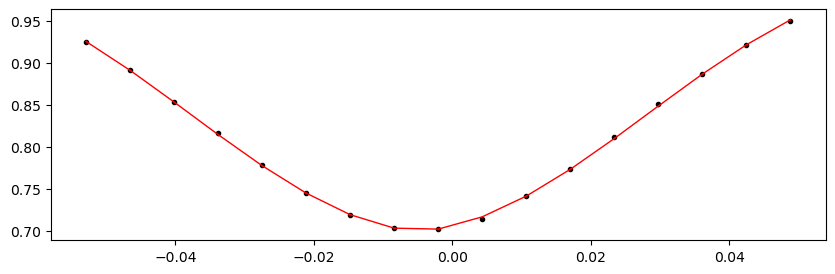

2414.85186385 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.76it/s]


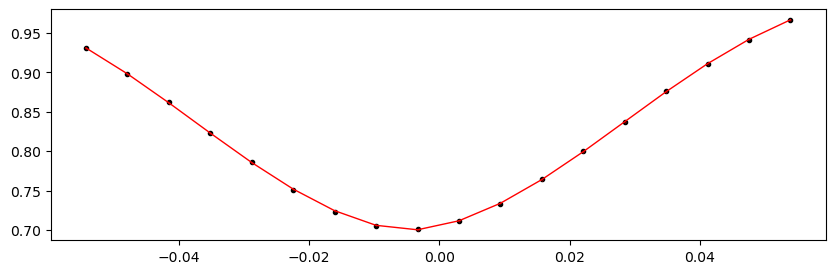

2415.94361355 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.11it/s]


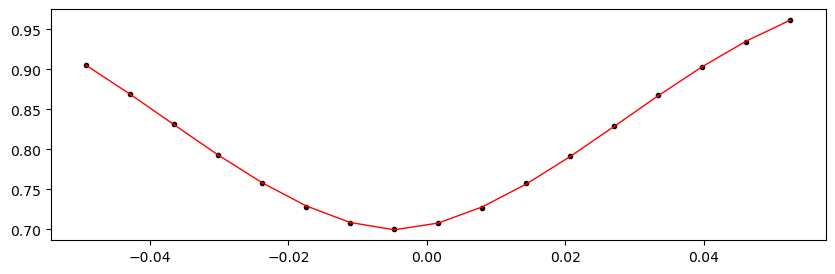

2417.03536325 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.22it/s]


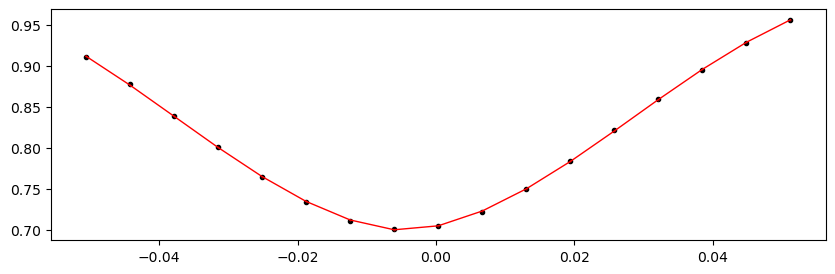

2418.12711295 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.57it/s]


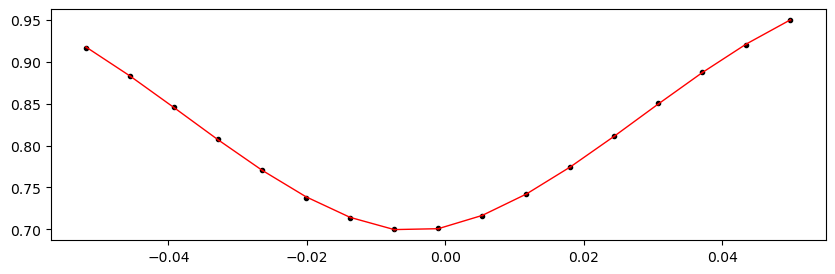

2581.88956795 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.09it/s]


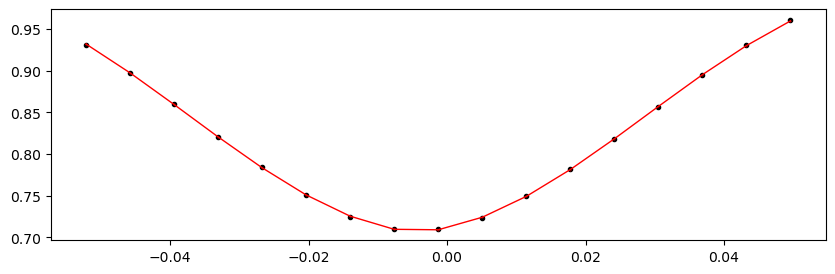

2582.98131765 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.77it/s]


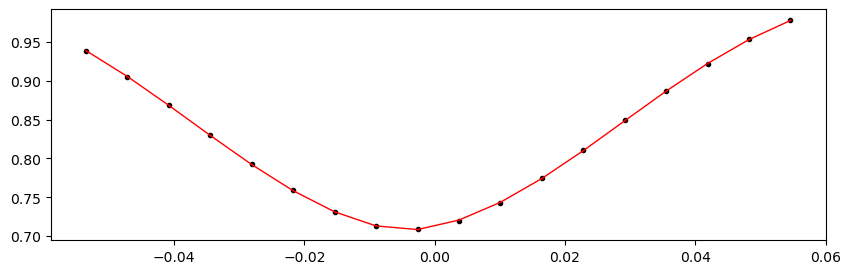

2584.0730673499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.87it/s]


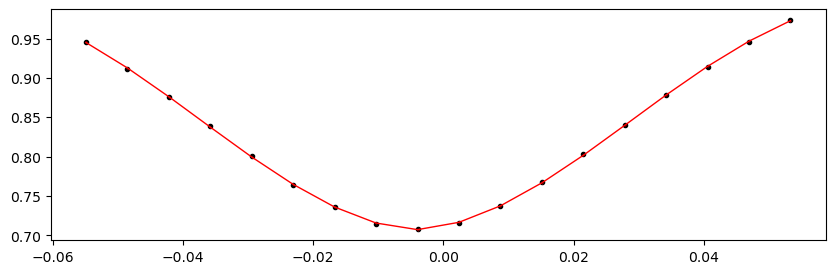

2585.16481705 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.11it/s]


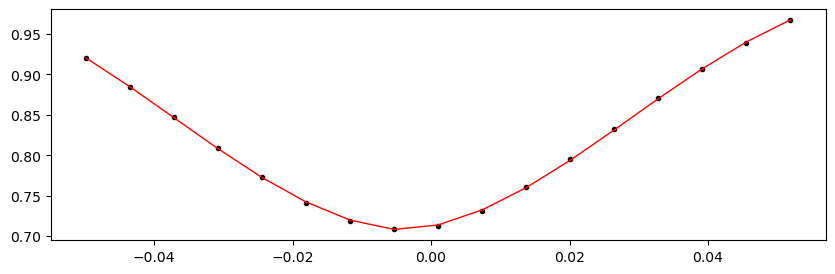

2586.25656675 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.95it/s]


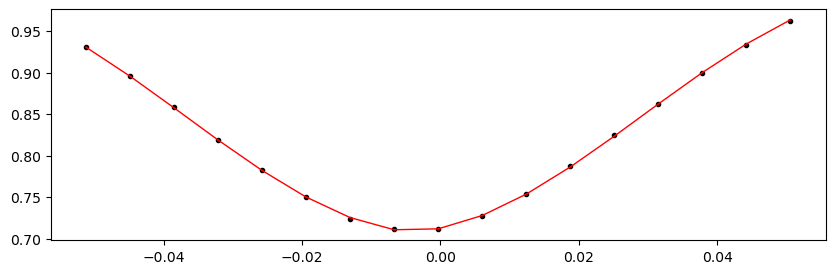

2587.34831645 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.73it/s]


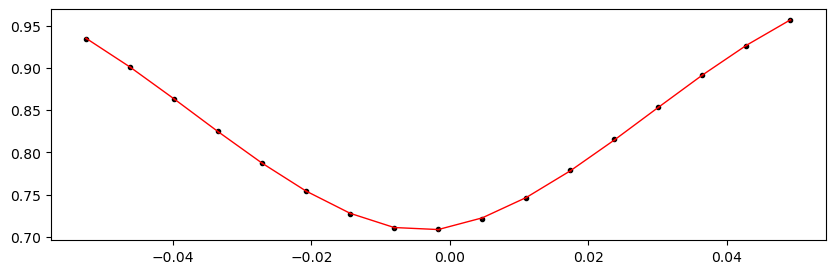

2588.44006615 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.87it/s]


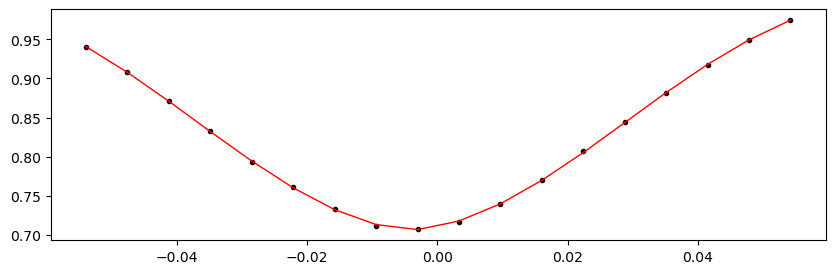

2589.53181585 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.33it/s]


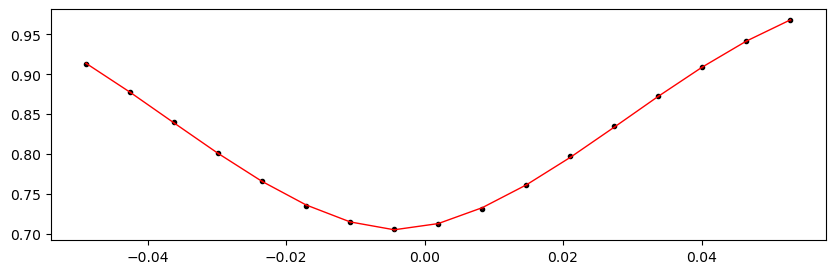

2590.62356555 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.27it/s]


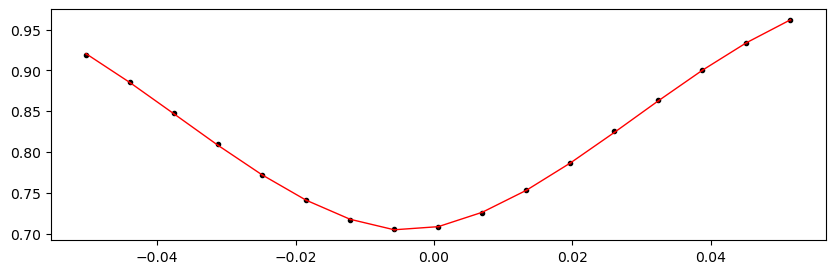

2591.71531525 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.34it/s]


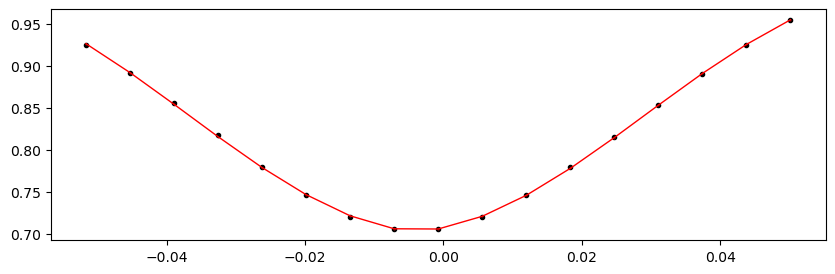

2592.80706495 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.07it/s]


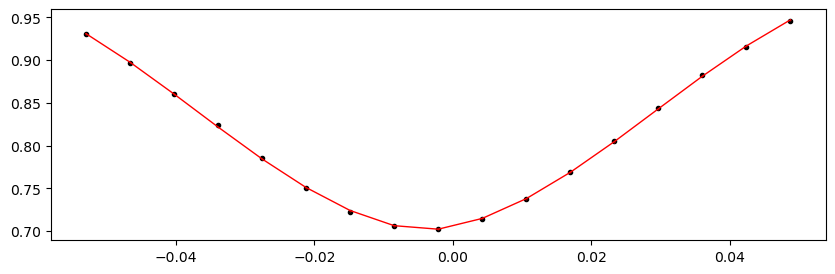

2597.1740637499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.62it/s]


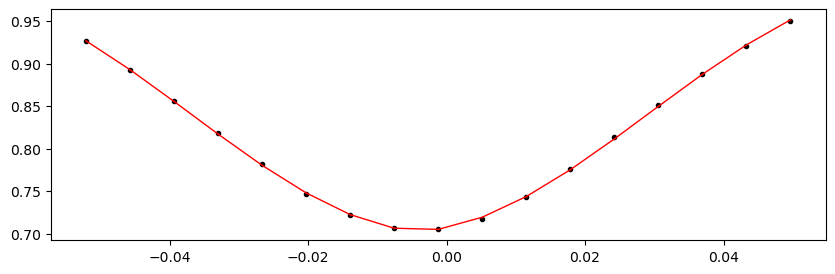

2598.2658134499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.21it/s]


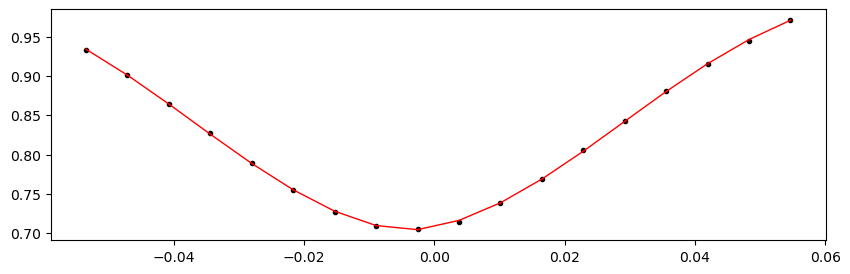

2599.35756315 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.97it/s]


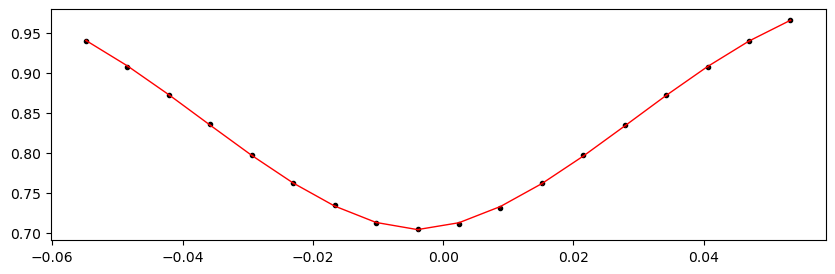

2600.44931285 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.37it/s]


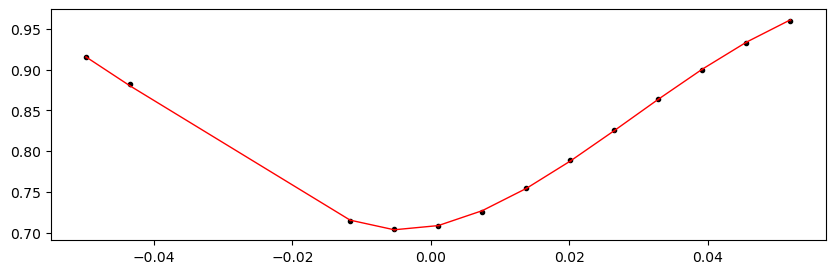

2601.54106255 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.54it/s]


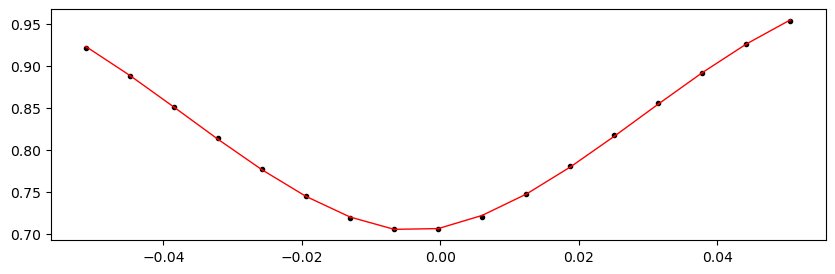

2602.63281225 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.67it/s]


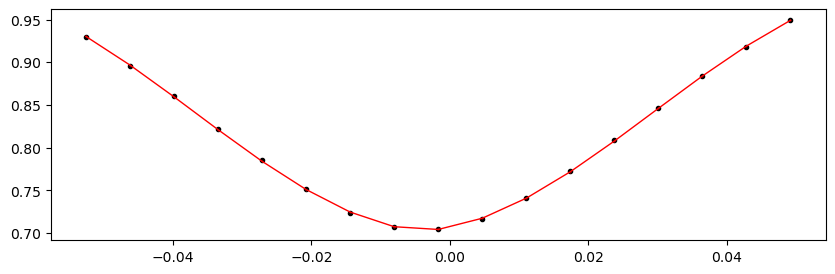

2603.72456195 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.33it/s]


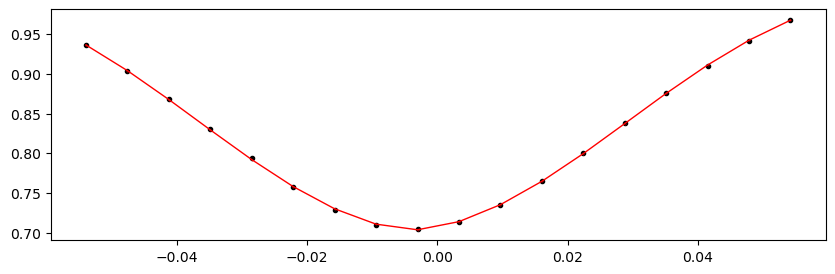

2604.81631165 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.39it/s]


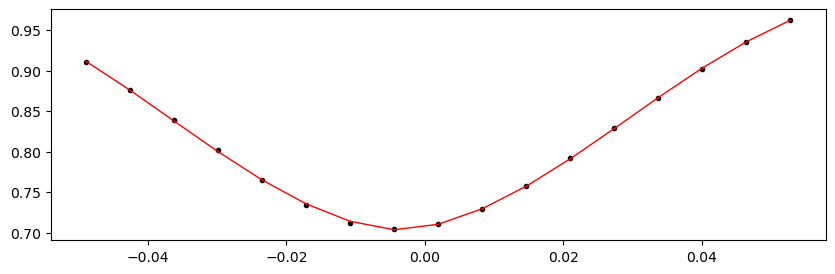

2605.90806135 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.39it/s]


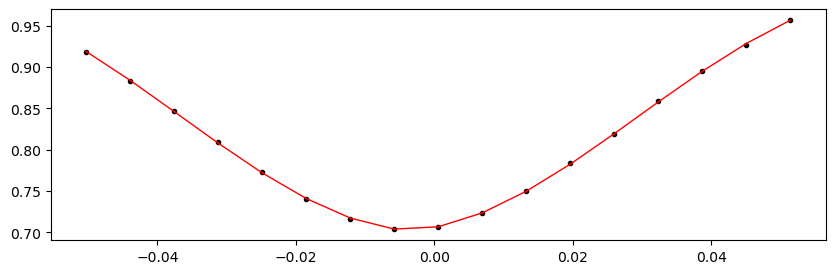

2744.56027325 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.13it/s]


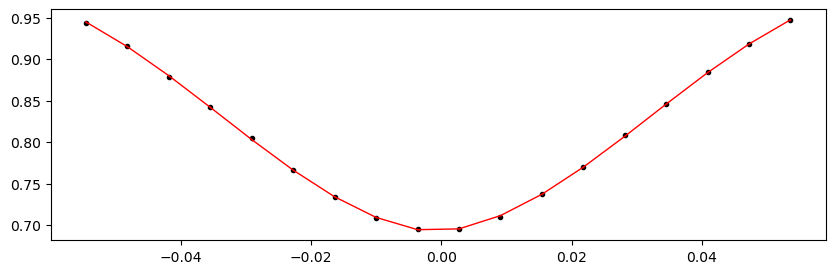

2745.65202295 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.32it/s]


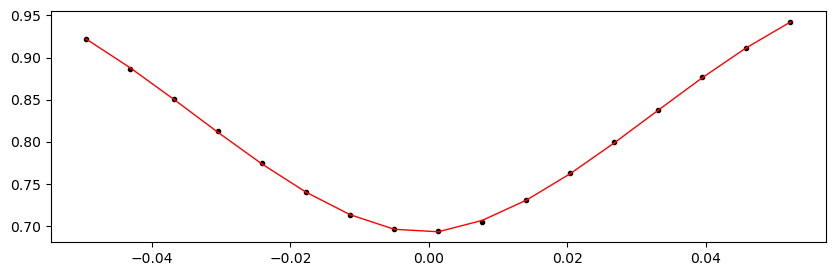

2746.7437726499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.31it/s]


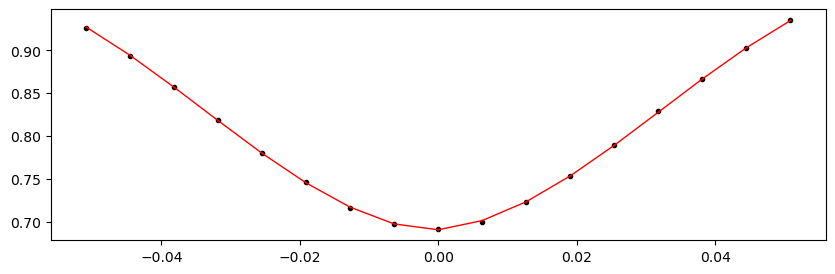

2747.83552235 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.33it/s]


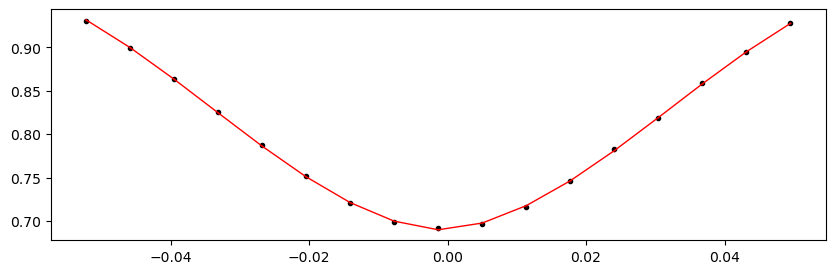

2748.92727205 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.72it/s]


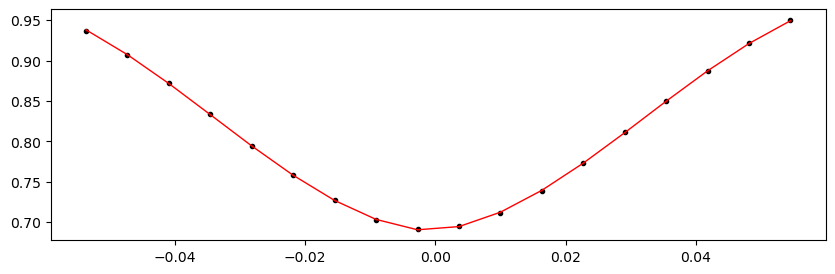

2750.01902175 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.86it/s]


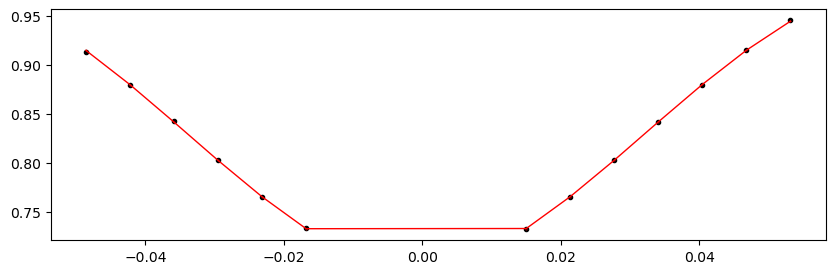

2751.11077145 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.58it/s]


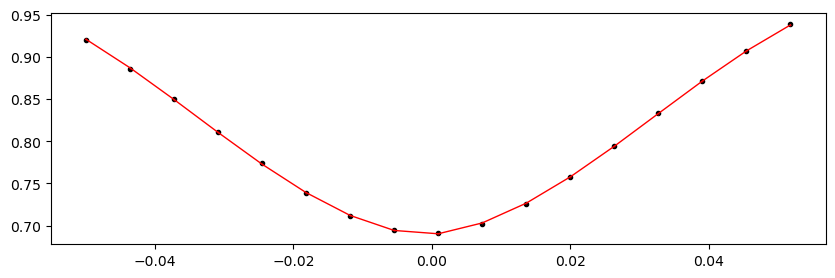

2752.20252115 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.34it/s]


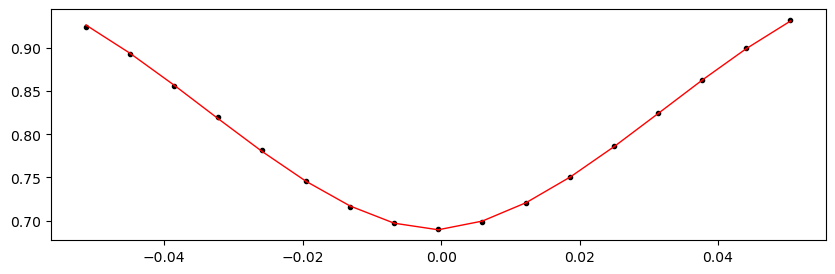

2753.29427085 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.16it/s]


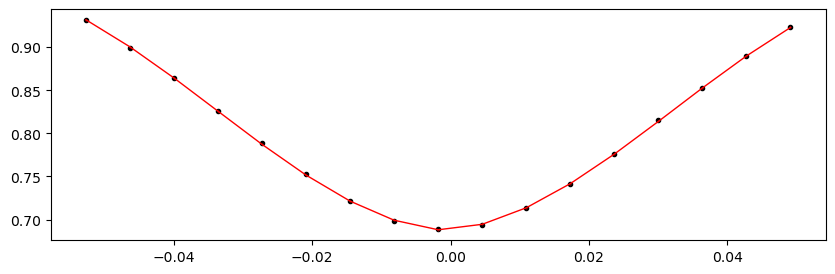

2754.38602055 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.67it/s]


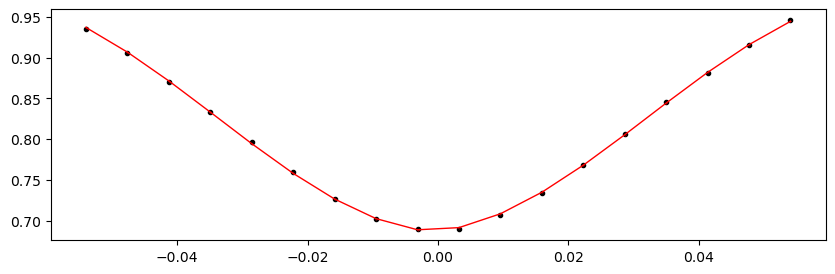

2755.47777025 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.38it/s]


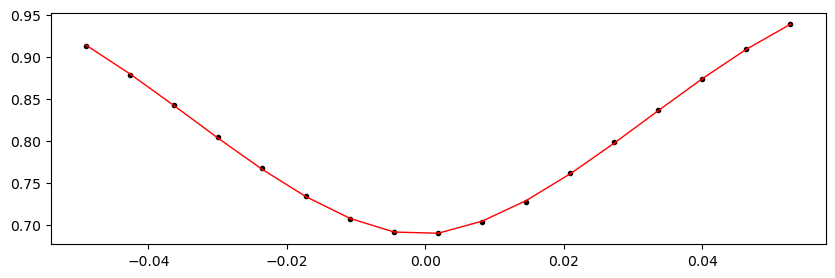

2757.6612696499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.11it/s]


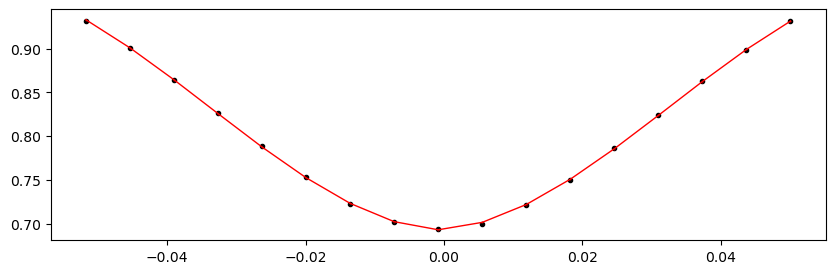

2758.7530193499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 455.32it/s]


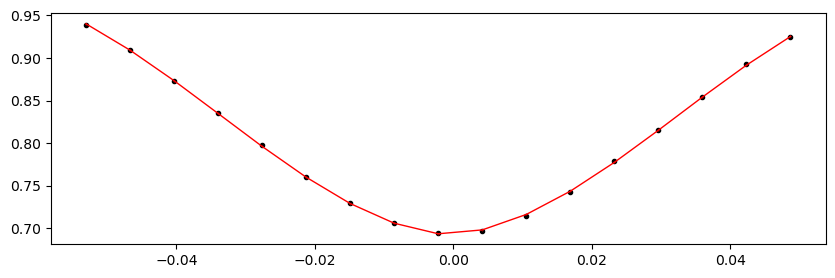

2759.8447690499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 456.10it/s]


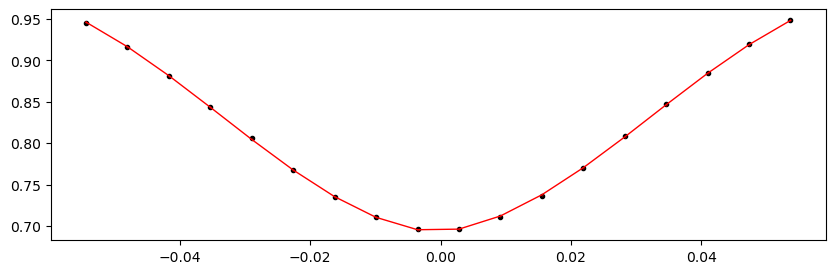

2760.93651875 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.01it/s]


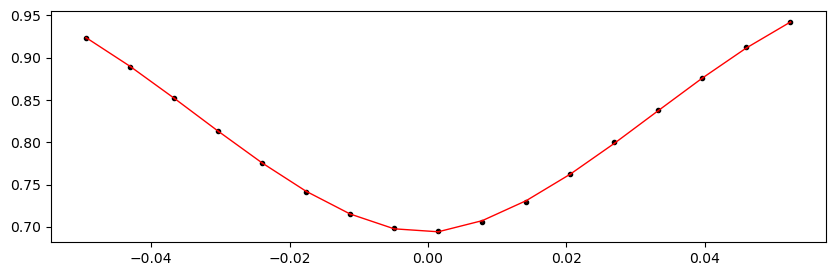

2762.02826845 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.14it/s]


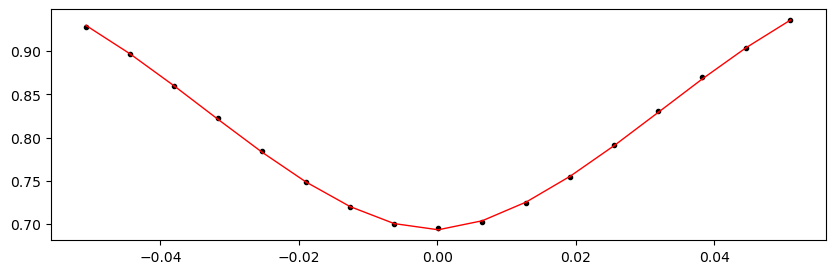

2763.12001815 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 454.87it/s]


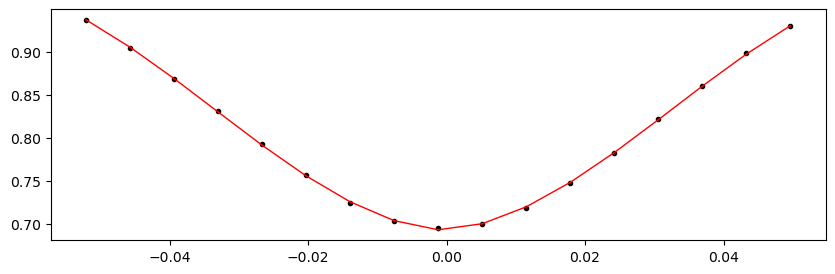

2764.21176785 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.57it/s]


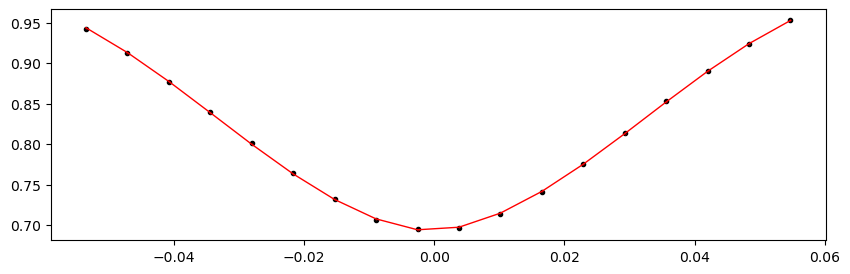

2765.30351755 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.51it/s]


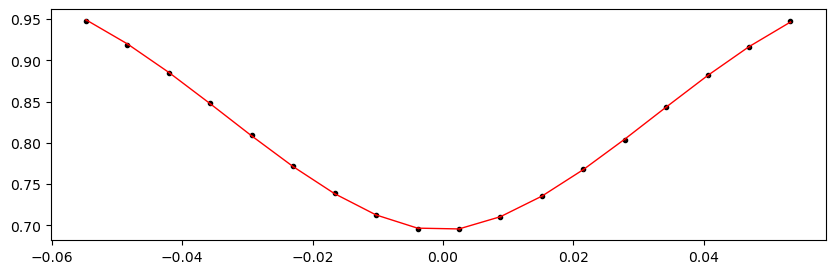

2766.39526725 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.56it/s]


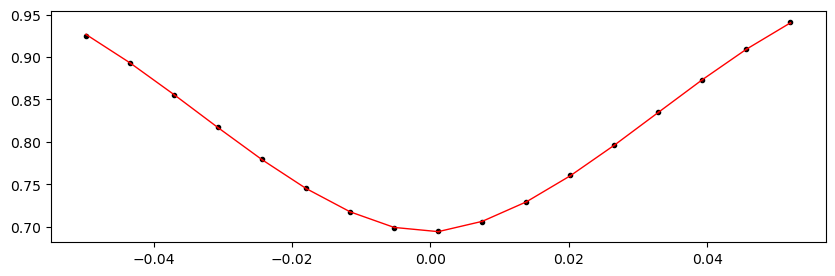

2767.48701695 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.98it/s]


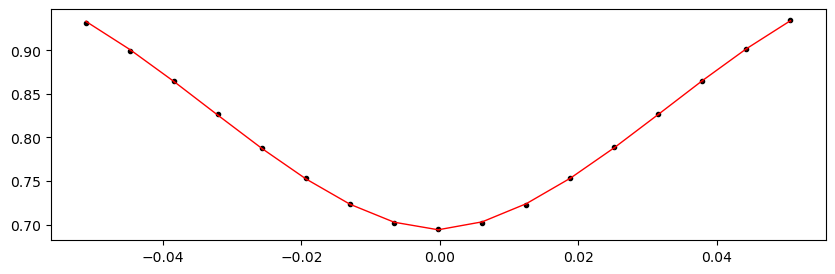

2768.57876665 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.85it/s]


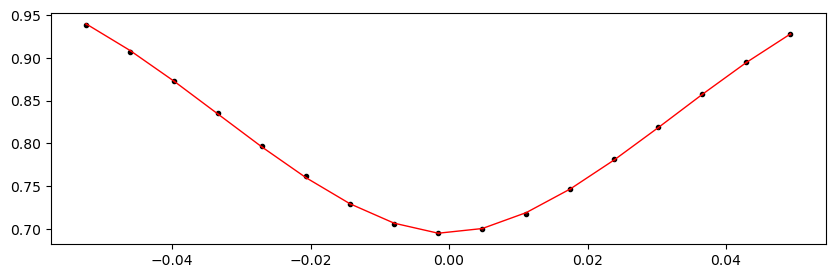

2912.68972705 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.65it/s]


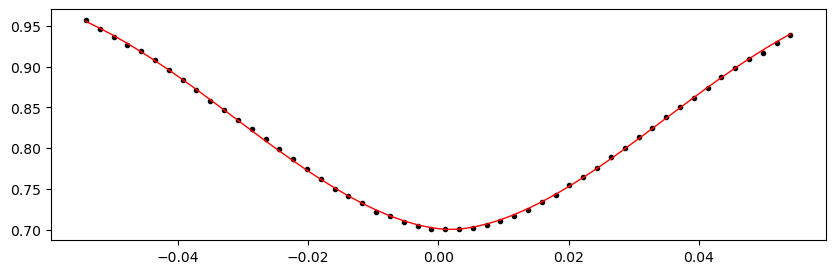

2913.78147675 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.18it/s]


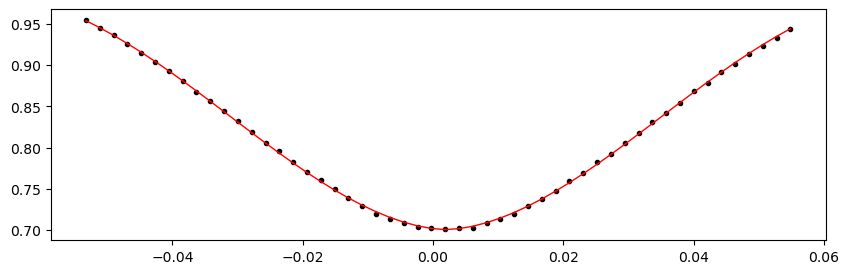

2914.87322645 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.12it/s]


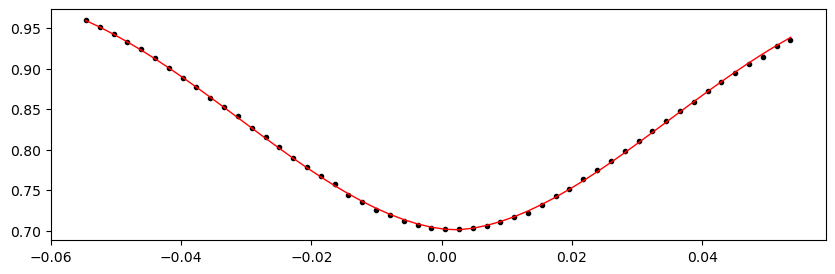

2915.96497615 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.93it/s]


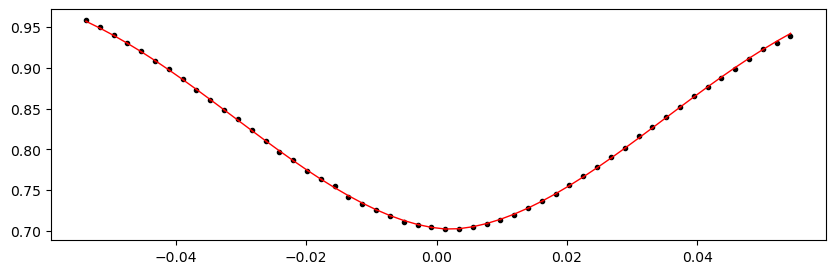

2917.05672585 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.69it/s]


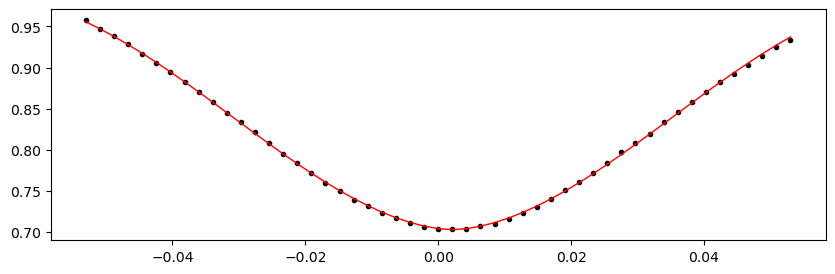

2918.1484755499996 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.08it/s]


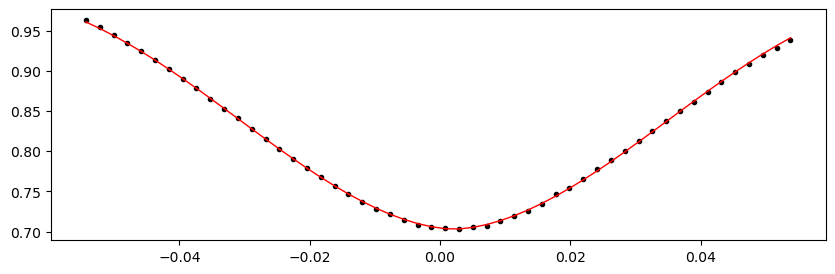

2919.2402252499996 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.73it/s]


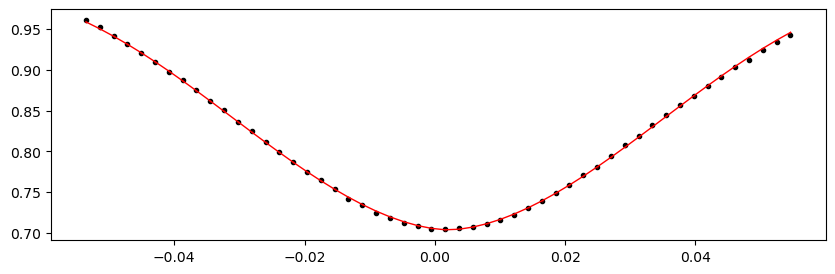

2920.3319749499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.00it/s]


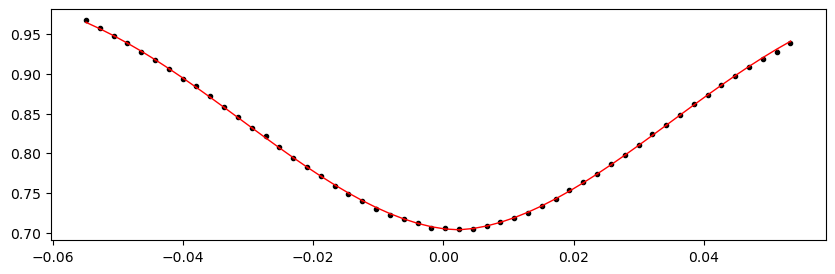

2921.4237246499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.85it/s]


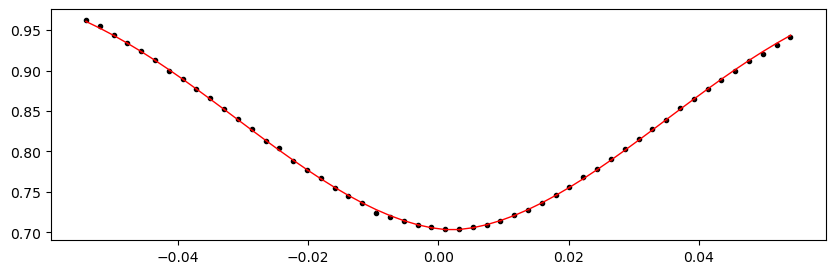

2922.5154743499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.85it/s]


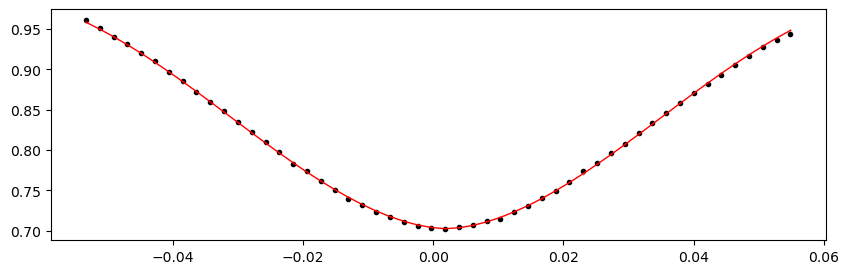

2925.79072345 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.69it/s]


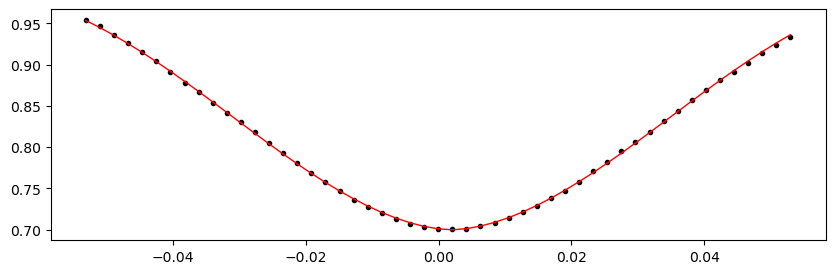

2926.88247315 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.39it/s]


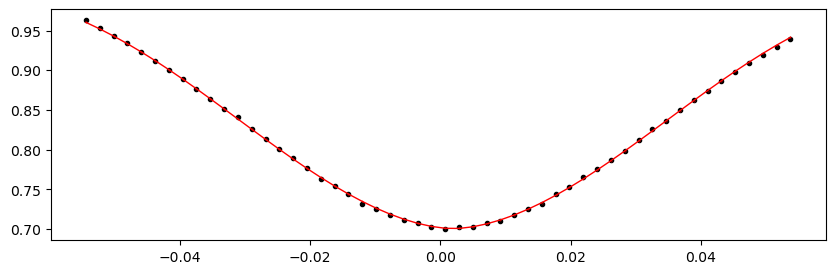

2927.97422285 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.63it/s]


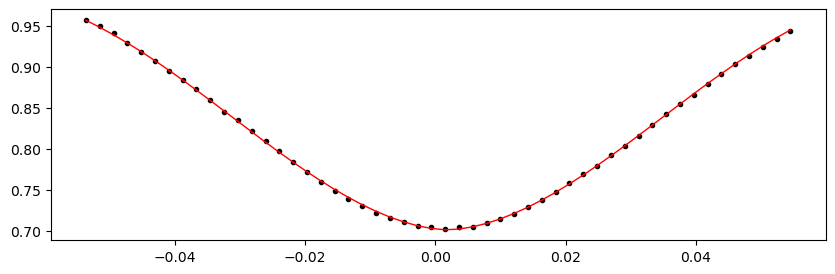

2929.06597255 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.73it/s]


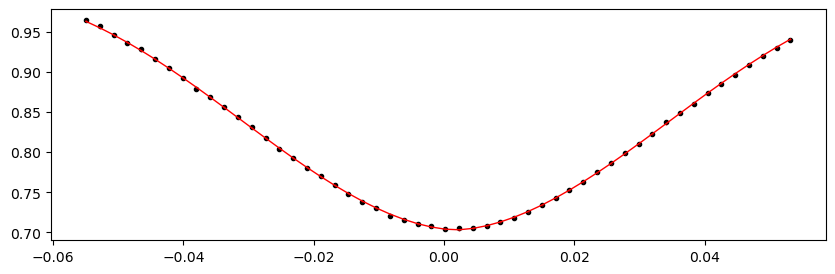

2930.15772225 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.77it/s]


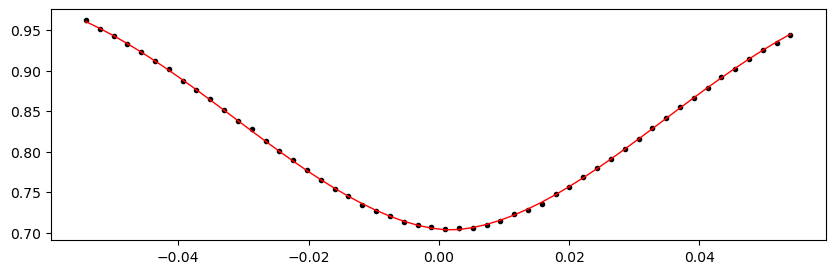

2931.24947195 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.16it/s]


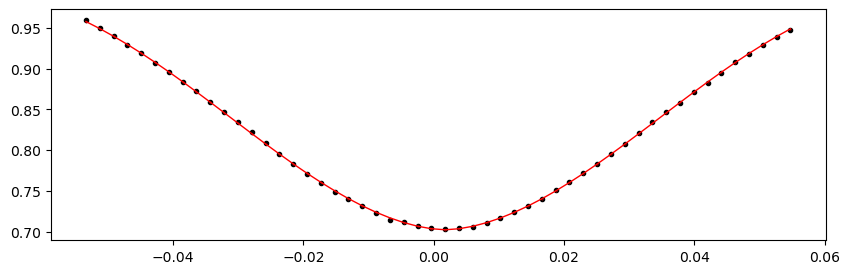

2932.34122165 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.29it/s]


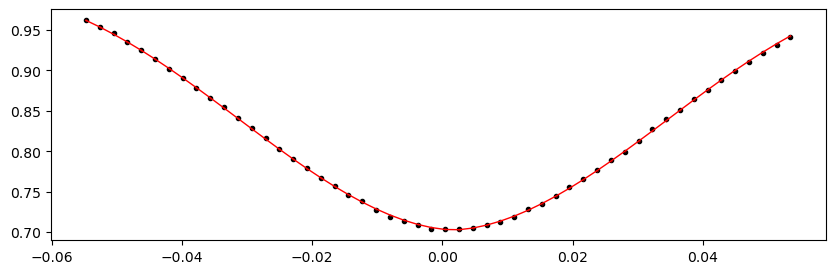

2933.43297135 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.13it/s]


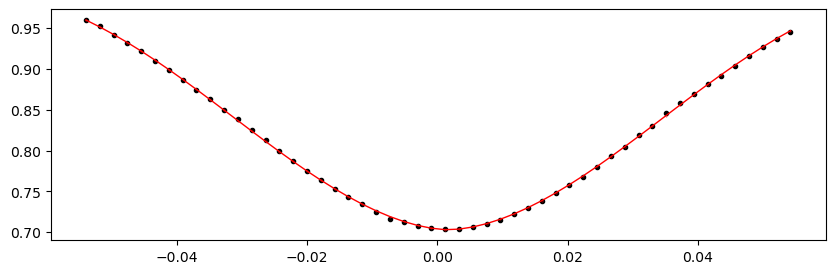

2934.52472105 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.94it/s]


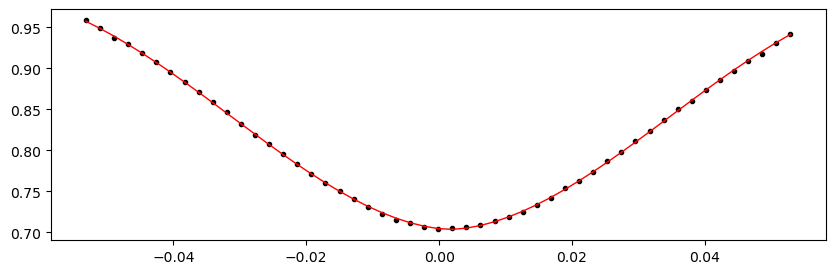

2935.61647075 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.94it/s]


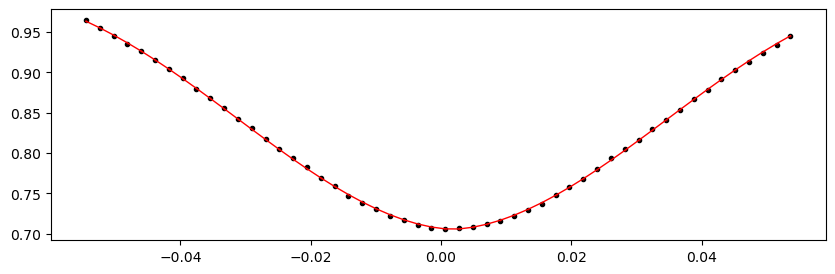

2936.70822045 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.53it/s]


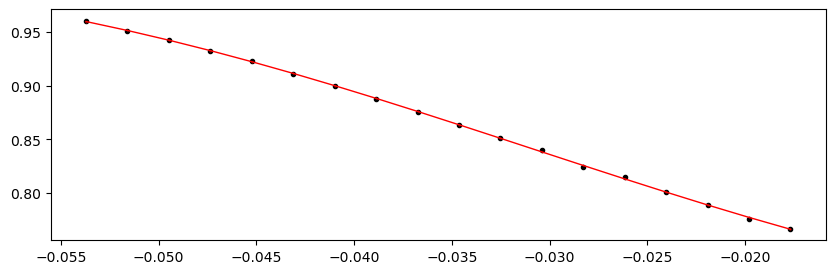

2939.98346955 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.07it/s]


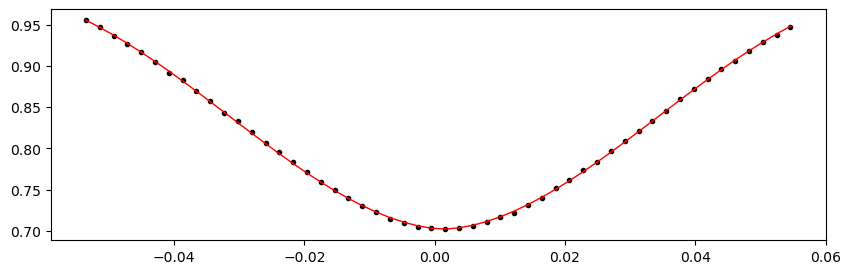

2941.07521925 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.73it/s]


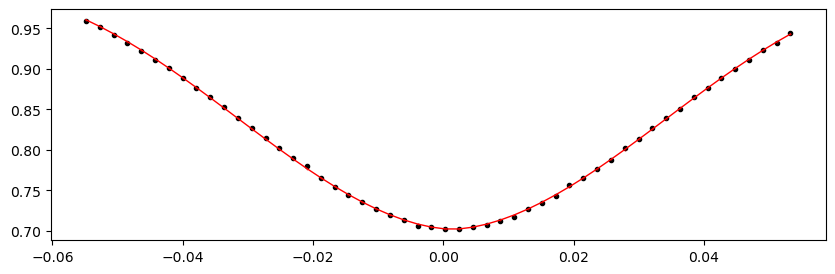

2942.16696895 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.27it/s]


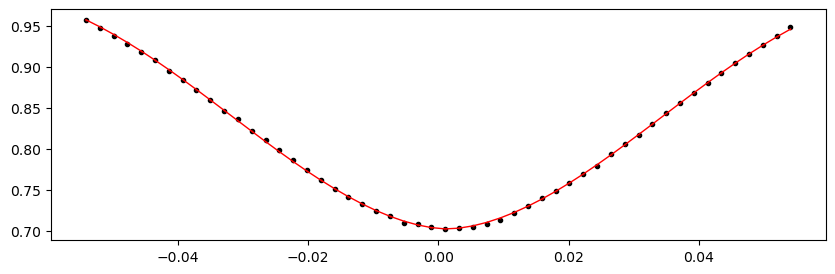

2943.25871865 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.04it/s]


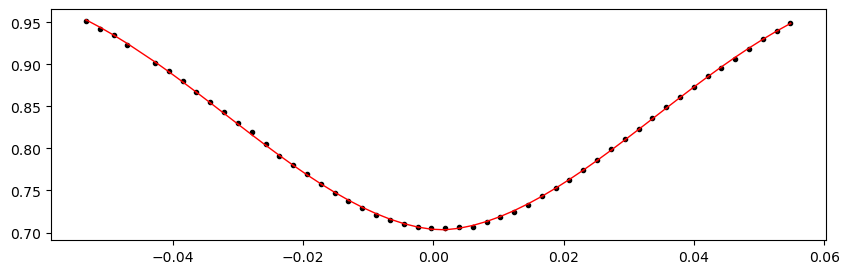

2944.35046835 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.91it/s]


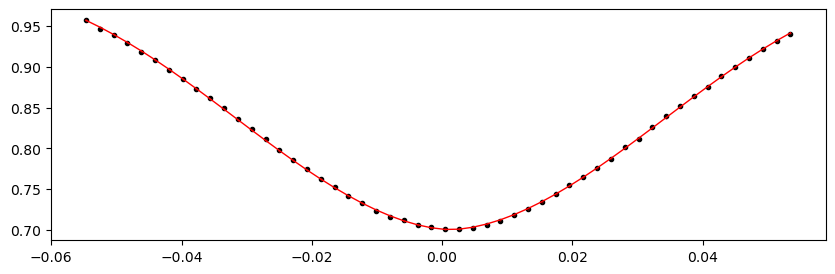

2945.4422180499996 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.34it/s]


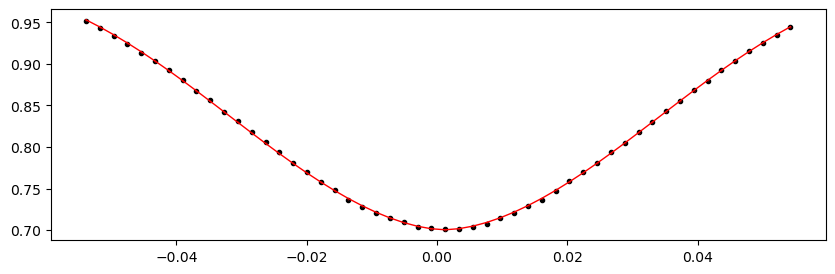

2946.5339677499996 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.50it/s]


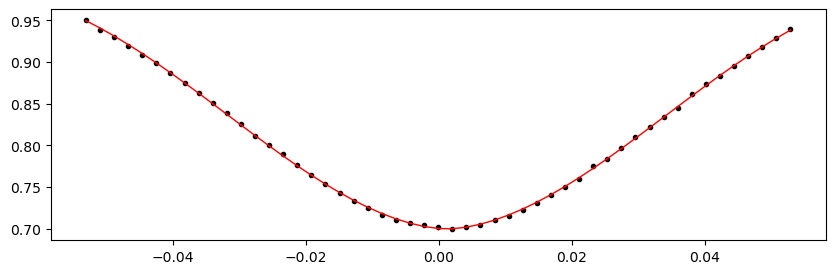

2947.6257174499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.14it/s]


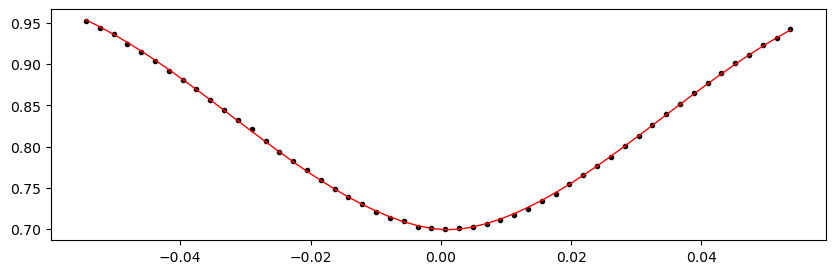

2948.7174671499997 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.68it/s]


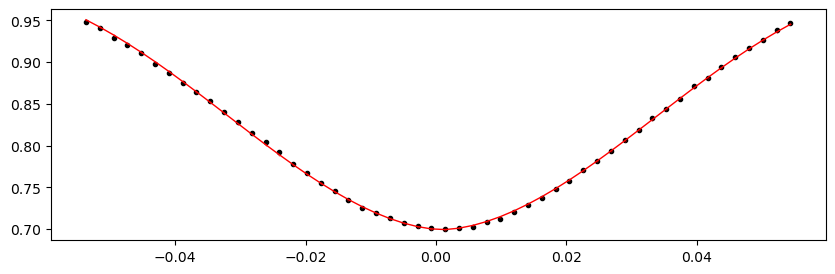

2949.8092168499998 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.23it/s]


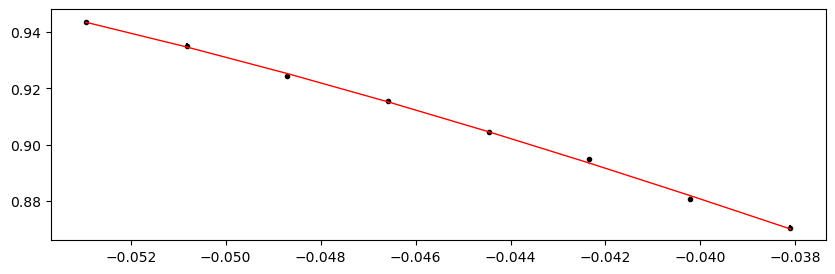

2955.26796535 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.23it/s]


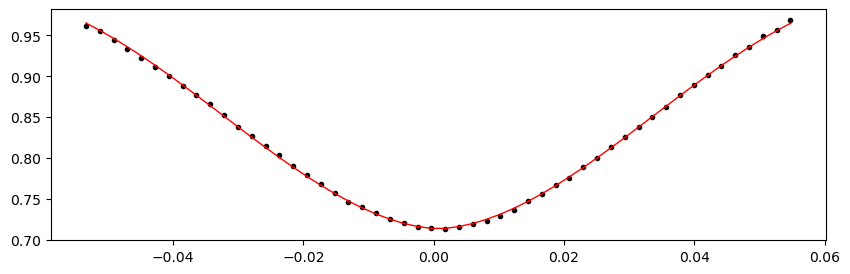

2957.45146475 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.36it/s]


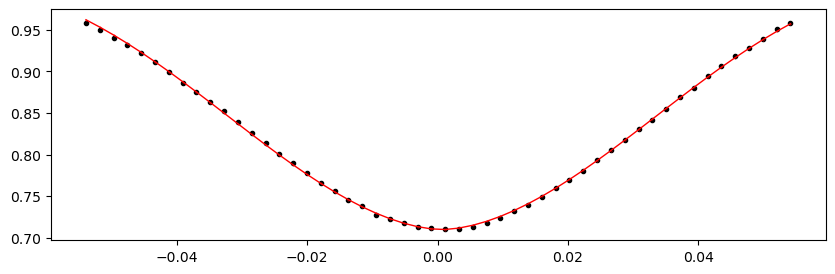

2958.54321445 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.25it/s]


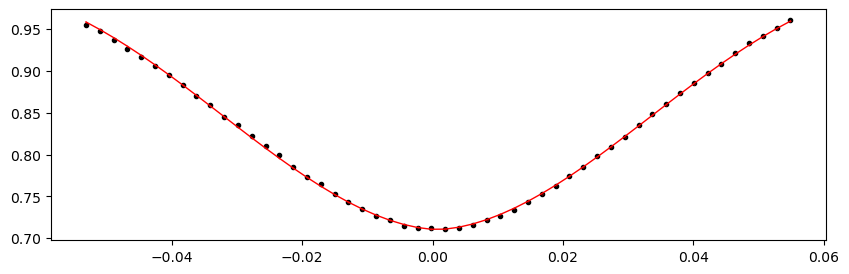

2959.63496415 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.17it/s]


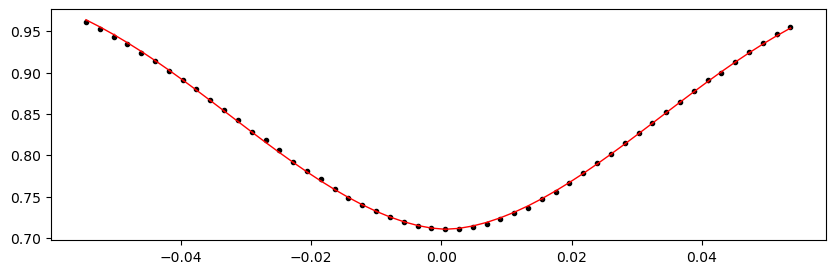

2960.72671385 1.0104505668276413 -0.3095910682479698 0.22407372998882316


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.13it/s]


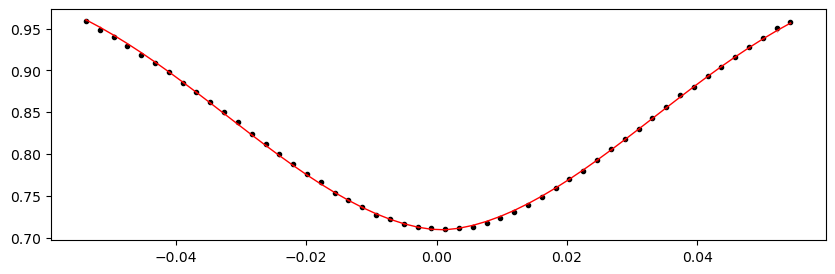

In [28]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=5,   # accomodate 30min cadence TESS-SPOC in sectors 19-20
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Time 1817.1189031 does not have enough data points: 5
Number 1 has already been completed -- skip
Time 1819.3024025 does not have enough data points: 5
Number 3 has already been completed -- skip
Time 1821.4859018999998 does not have enough data points: 5
Time 1822.5776515999999 does not have enough data points: 5
Number 6 has already been completed -- skip
Time 1824.761151 does not have enough data points: 5
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 11 has already been completed -- skip
Time 1830.2198994999999 does not have enough data points: 5
Time 1831.3116492 does not have enough data points: 5
Number 14 has already been completed -- skip
1833.4951486 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.74it/s]


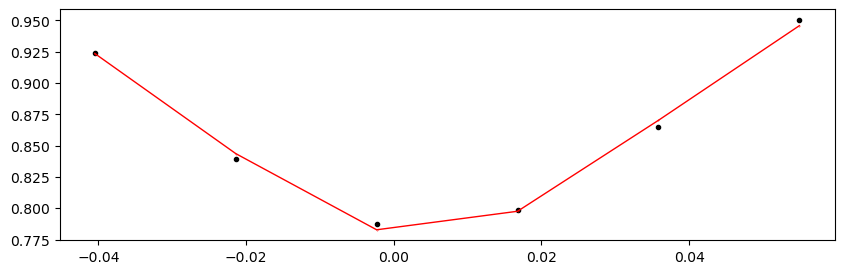

1834.5868982999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.19it/s]


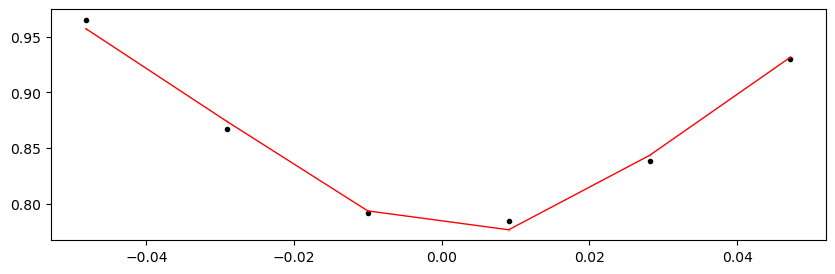

Time 1835.6786479999998 does not have enough data points: 5
1836.7703976999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.14it/s]


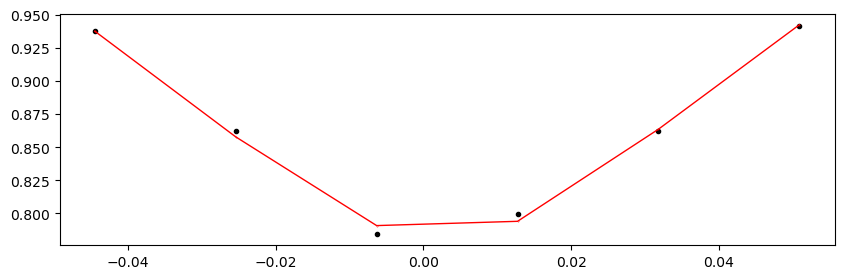

1837.8621474 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.54it/s]


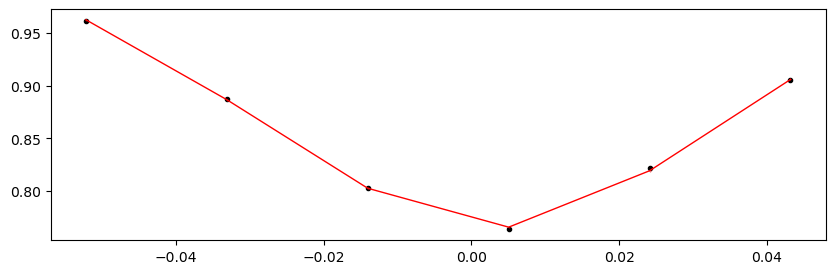

1838.9538971 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.10it/s]


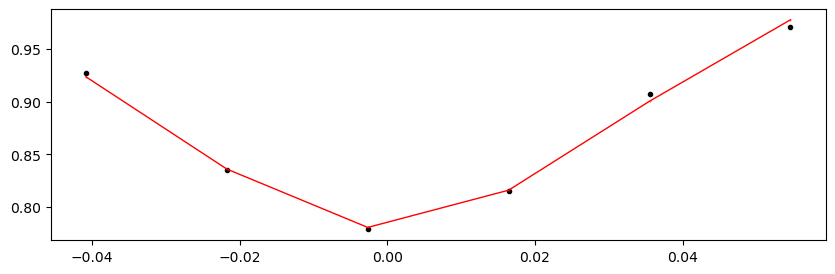

Time 1840.0456468 does not have enough data points: 5
1843.3208958999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.29it/s]


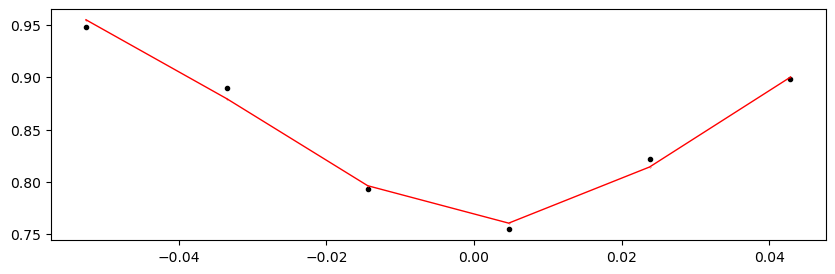

1844.4126456 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.36it/s]


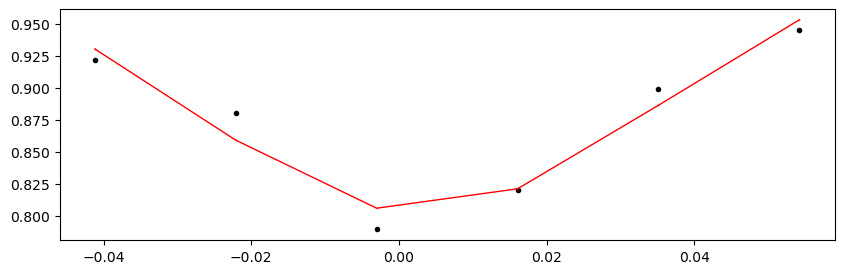

1845.5043953 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.39it/s]


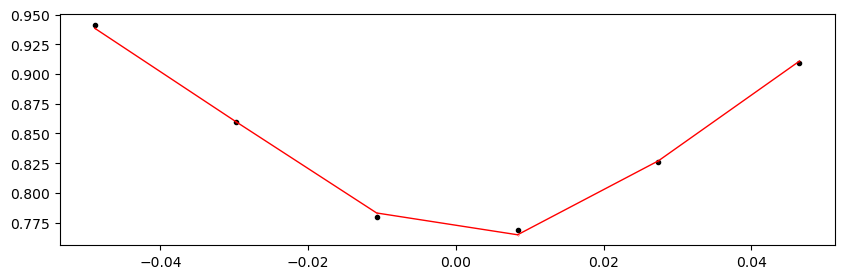

Time 1846.596145 does not have enough data points: 5
1847.6878946999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.91it/s]


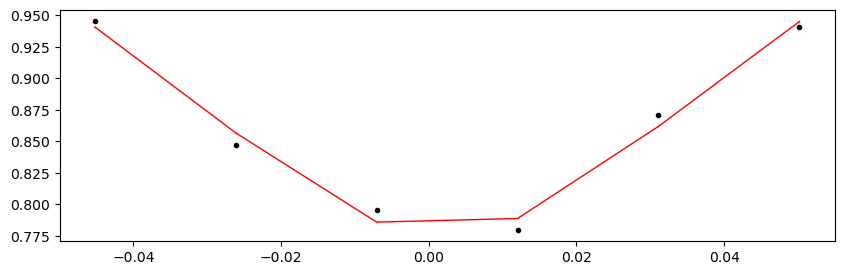

1848.7796443999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.39it/s]


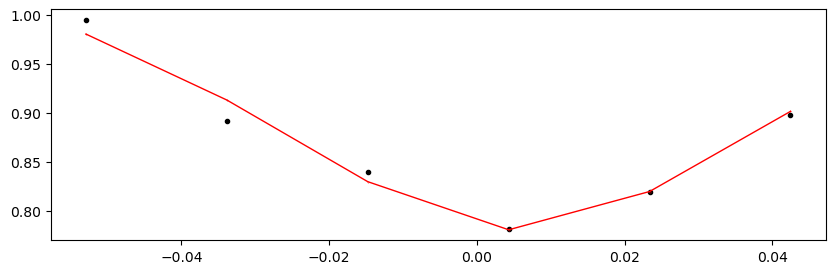

1849.8713940999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.59it/s]


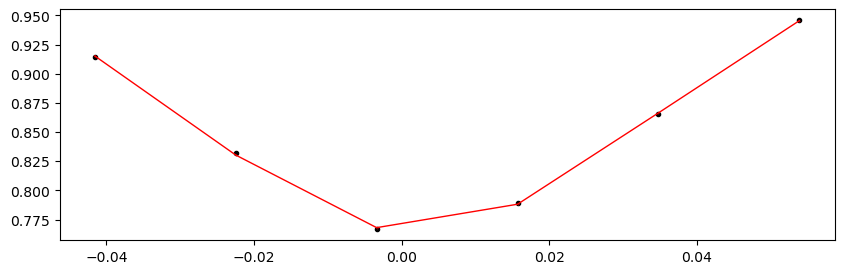

1850.9631438 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.95it/s]


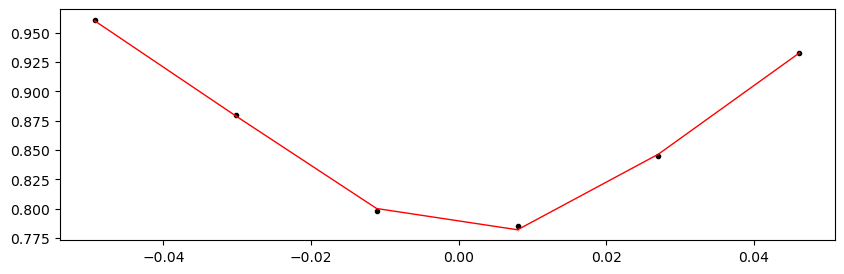

Time 1852.0548935 does not have enough data points: 5
1853.1466432 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.32it/s]


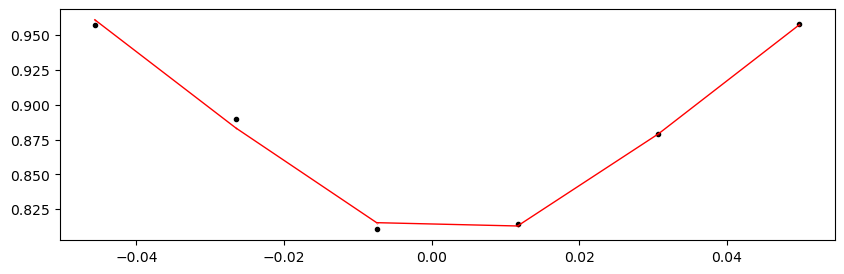

1854.2383929 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.11it/s]


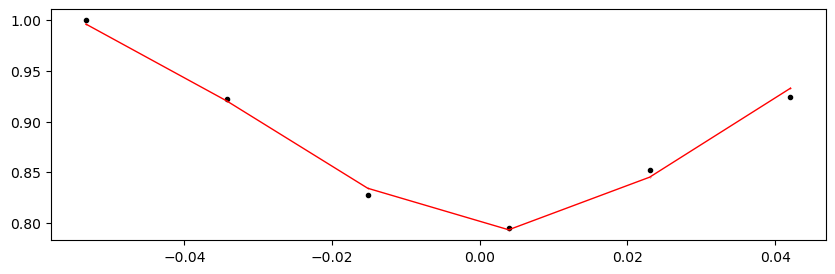

Time 1856.4218922999999 does not have enough data points: 3
Time 1857.513642 does not have enough data points: 5
1858.6053917 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.91it/s]


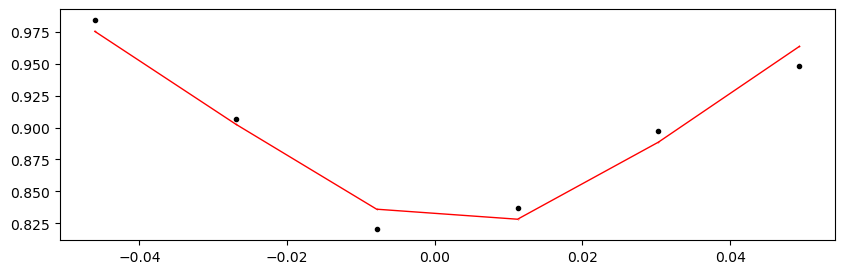

1859.6971414 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.17it/s]


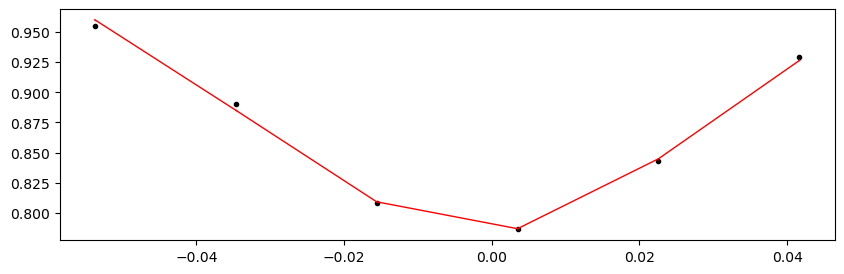

1860.7888911 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.71it/s]


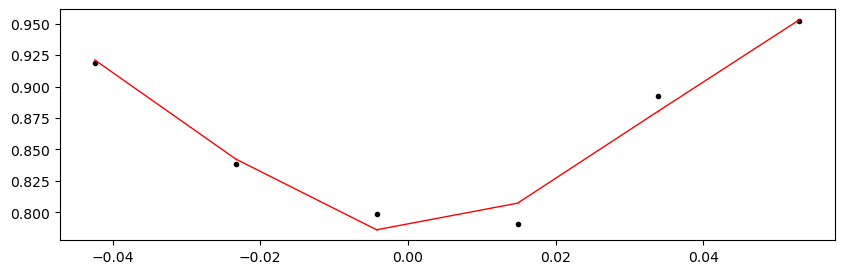

1861.8806407999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.11it/s]


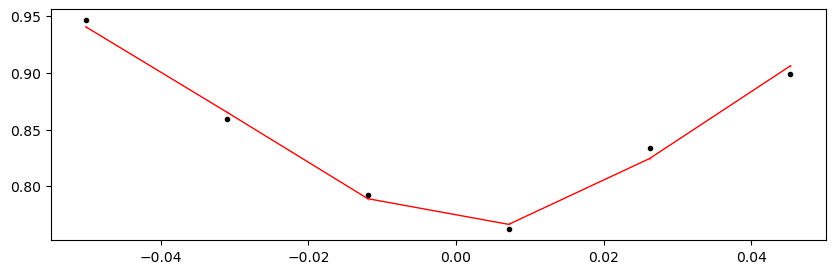

Time 1862.9723904999998 does not have enough data points: 5
1864.0641401999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.26it/s]


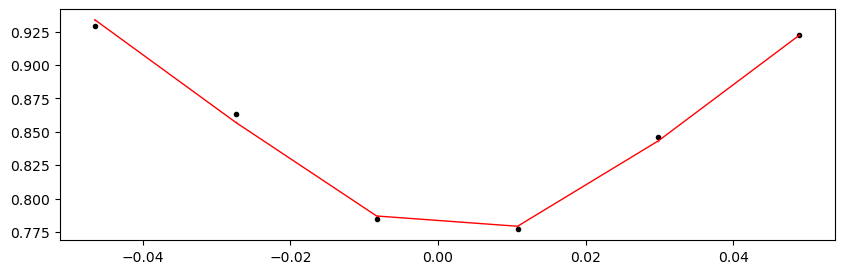

1865.1558899 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.04it/s]


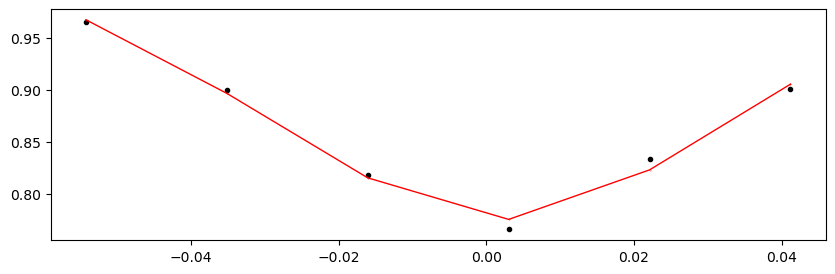

1866.2476396 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.20it/s]


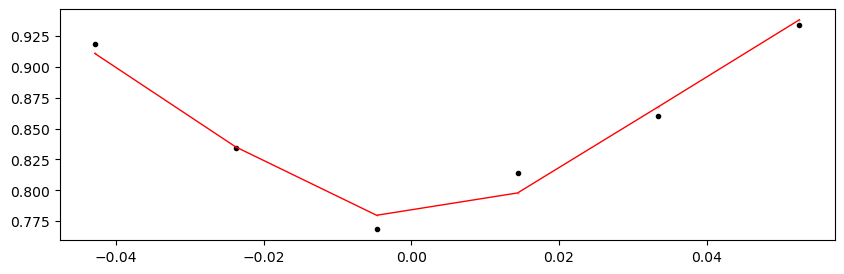

1867.3393893 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.70it/s]


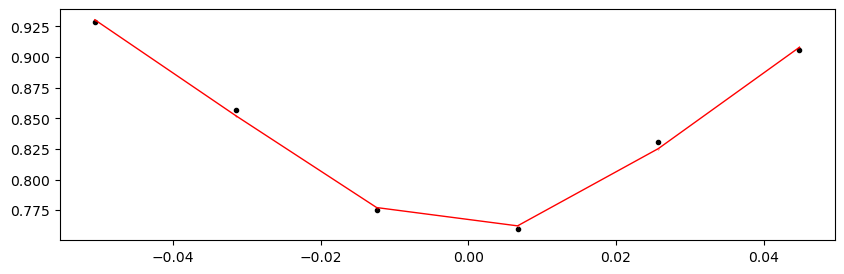

Time 1868.4311389999998 does not have enough data points: 5
2010.3586 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.91it/s]


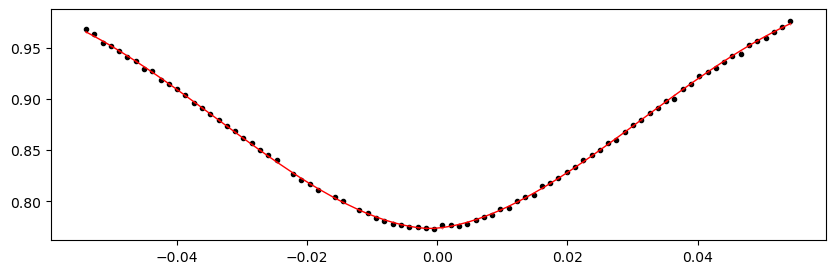

2011.4503496999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.63it/s]


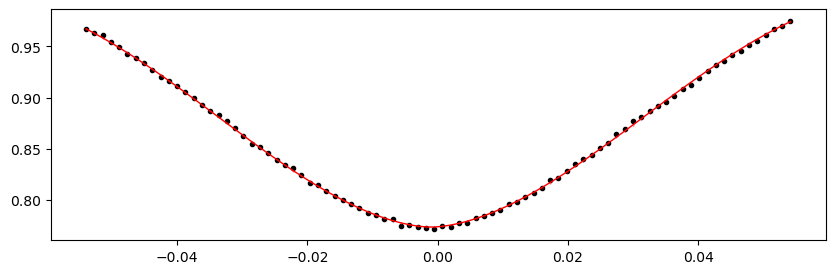

2012.5420993999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.80it/s]


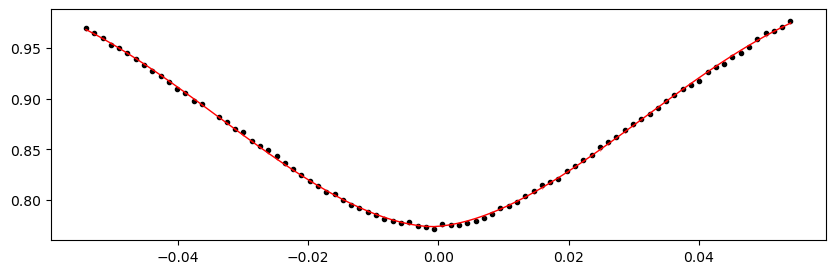

2013.6338491 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.75it/s]


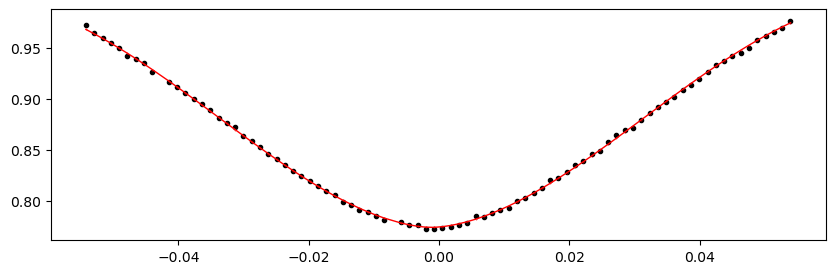

2014.7255988 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.12it/s]


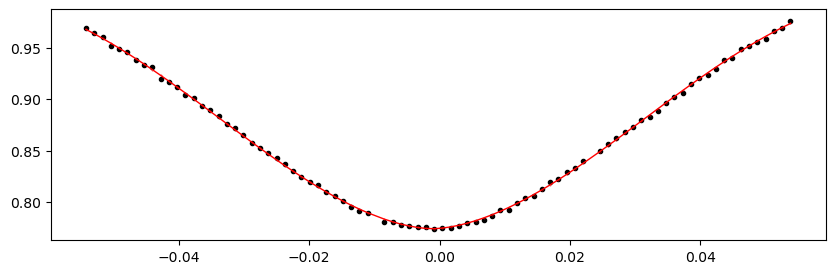

2015.8173485 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.12it/s]


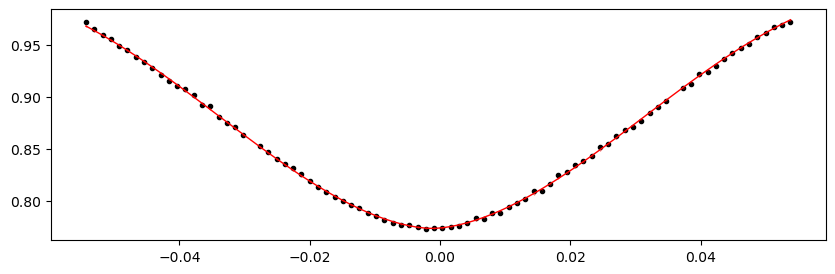

2016.9090981999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.50it/s]


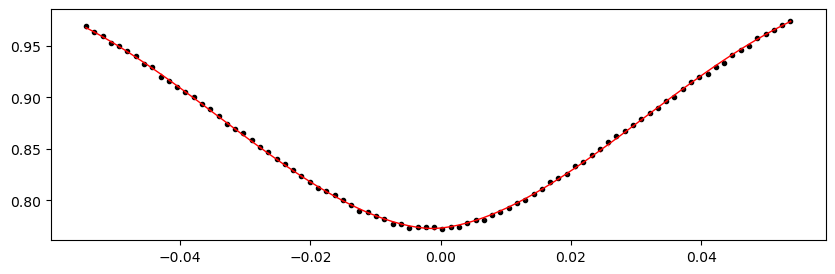

2018.0008478999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.17it/s]


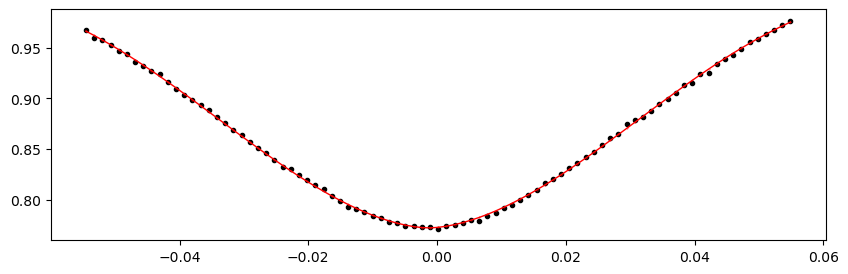

2019.0925975999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.45it/s]


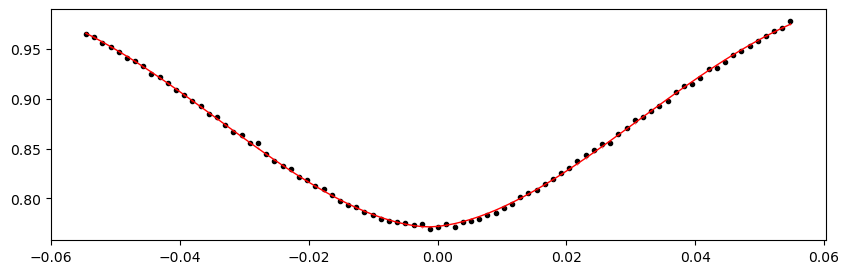

2020.1843473 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.65it/s]


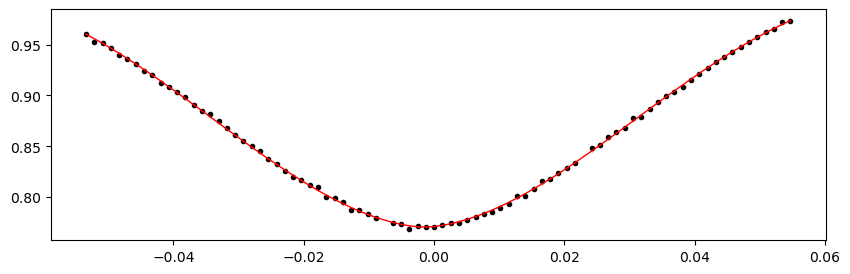

2021.276097 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.27it/s]


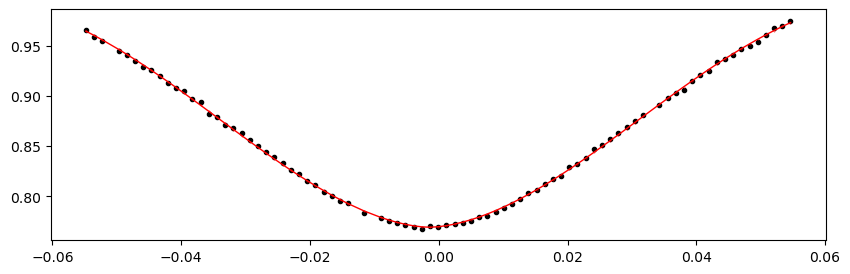

2023.4595964 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.39it/s]


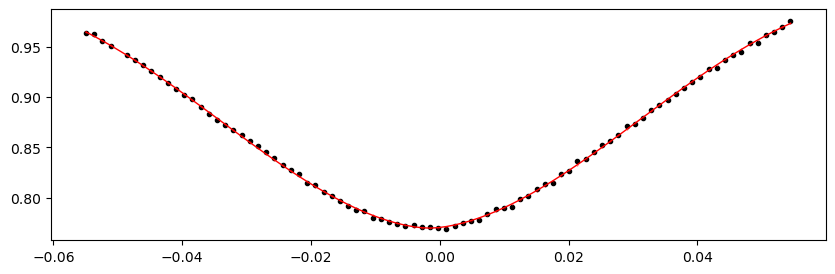

2024.5513460999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.33it/s]


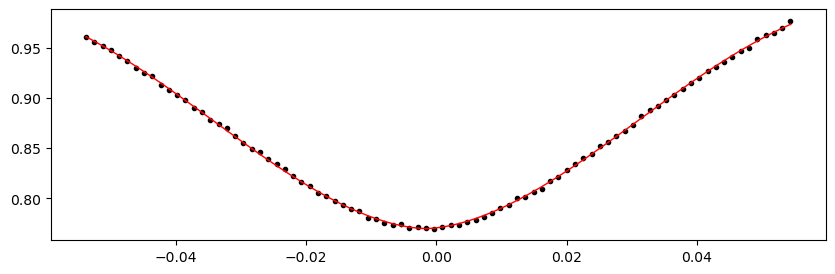

2025.6430957999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.01it/s]


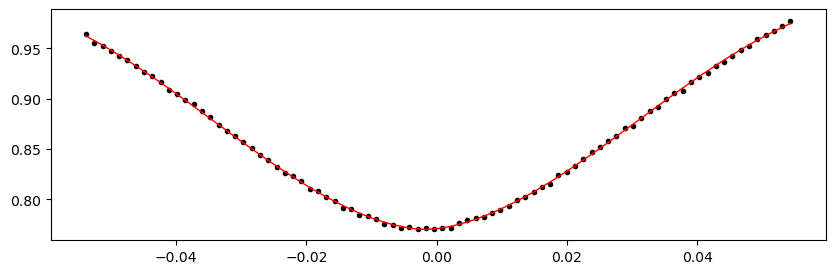

2026.7348455 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.50it/s]


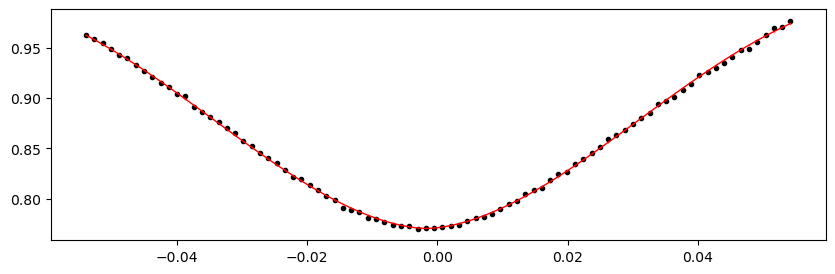

2027.8265952 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.08it/s]


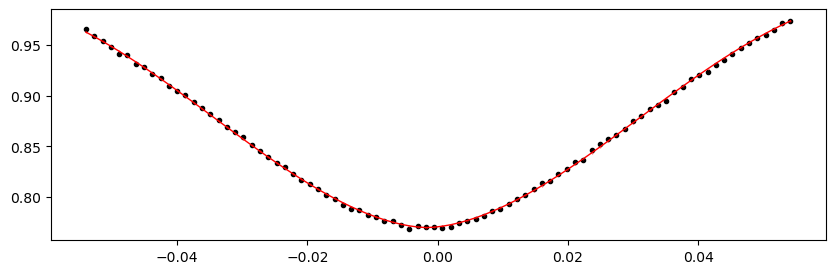

2028.9183449 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.17it/s]


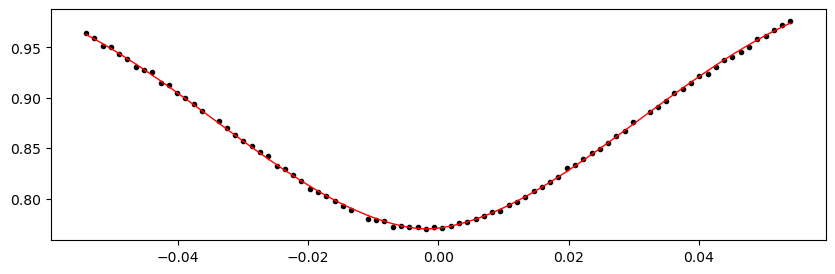

2030.0100946 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.85it/s]


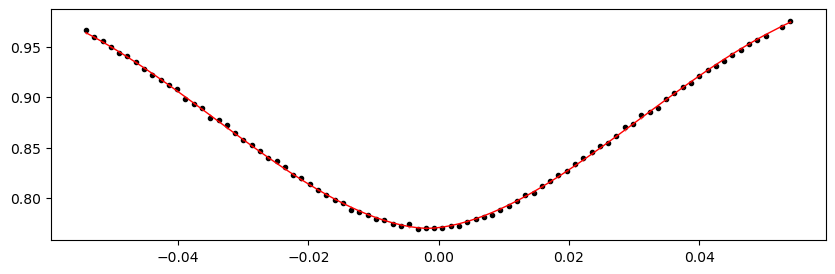

2031.1018442999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.24it/s]


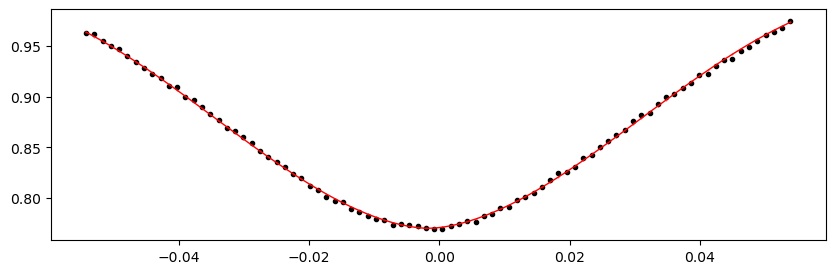

2032.1935939999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.55it/s]


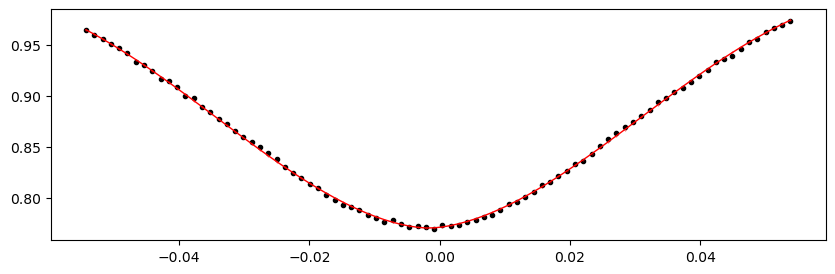

2033.2853436999999 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.08it/s]


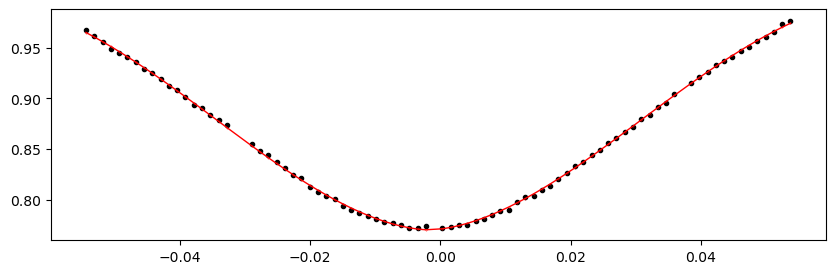

2034.3770934 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.00it/s]


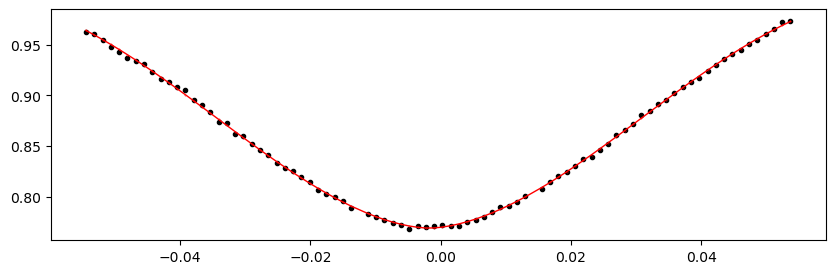

2391.3792452999996 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.09it/s]


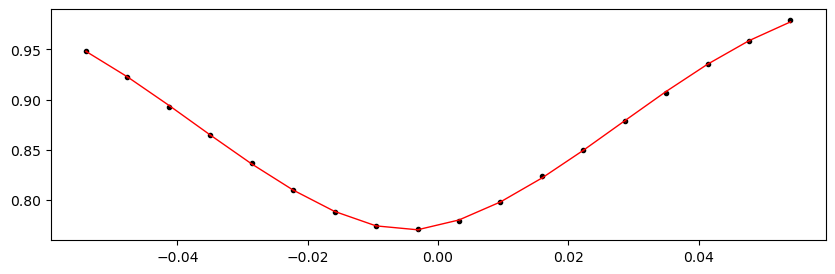

2392.4709949999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.43it/s]


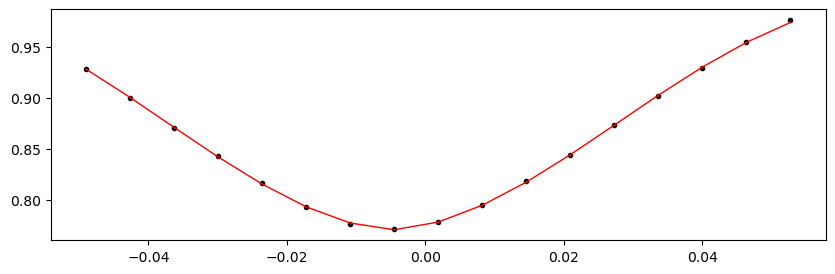

2393.5627446999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.69it/s]


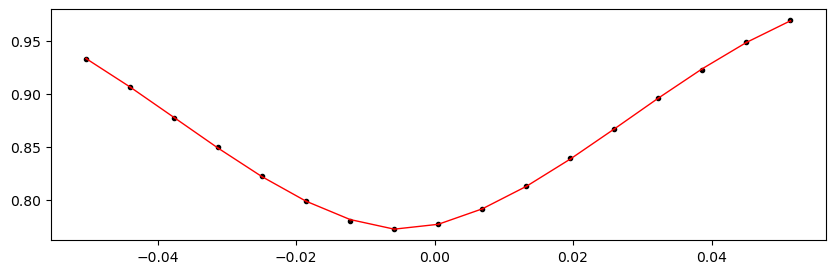

2394.6544943999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.21it/s]


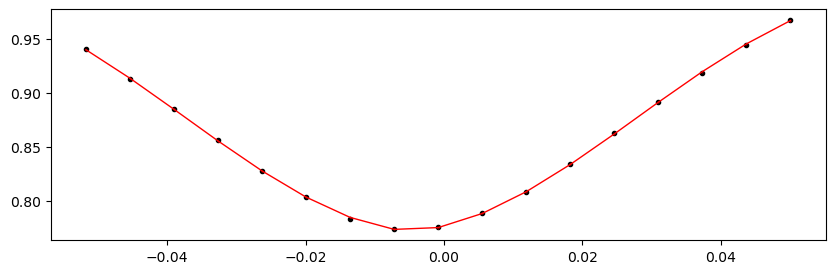

2395.7462441 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.76it/s]


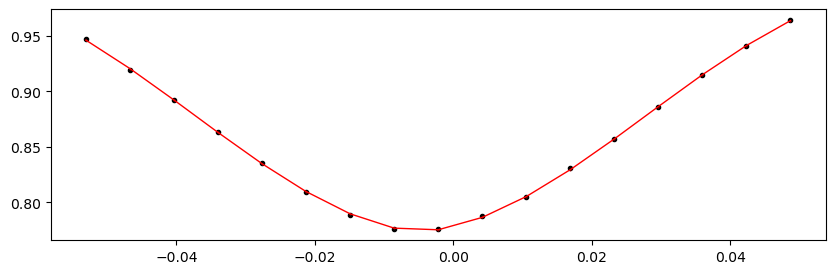

2396.8379938 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.07it/s]


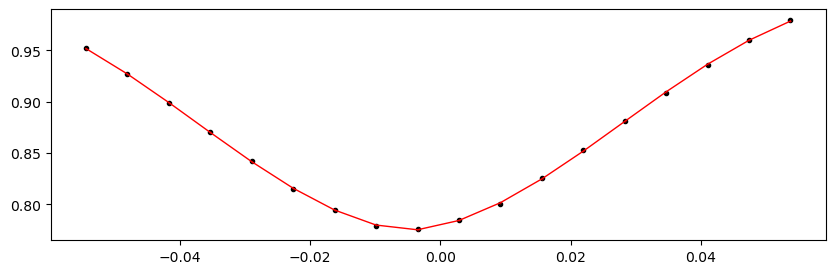

2397.9297435 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.25it/s]


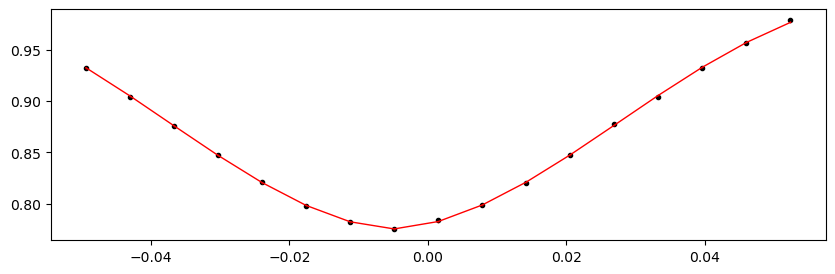

2399.0214932 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.31it/s]


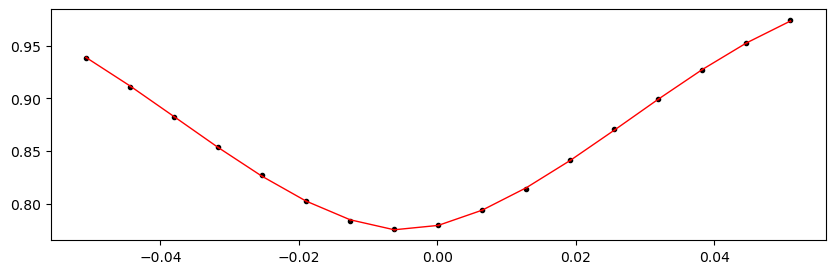

2400.1132429 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.81it/s]


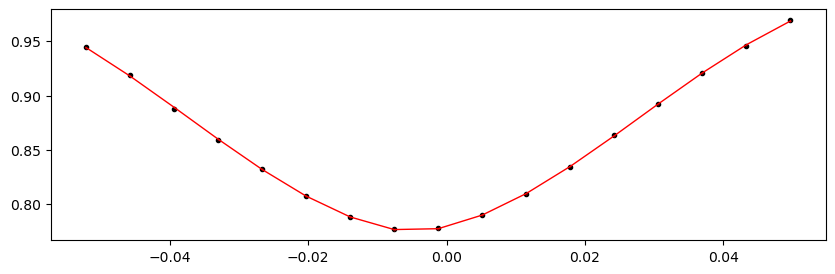

2401.2049926 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.65it/s]


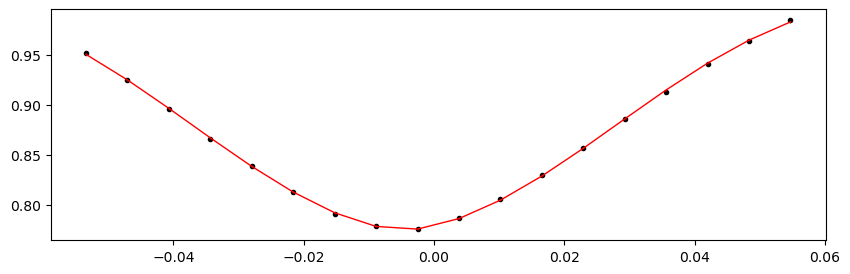

2402.2967423 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.72it/s]


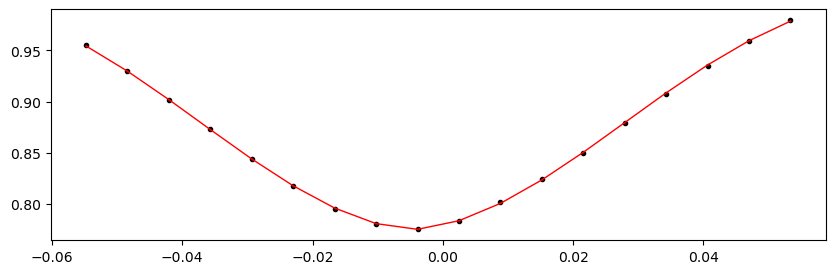

2403.388492 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.56it/s]


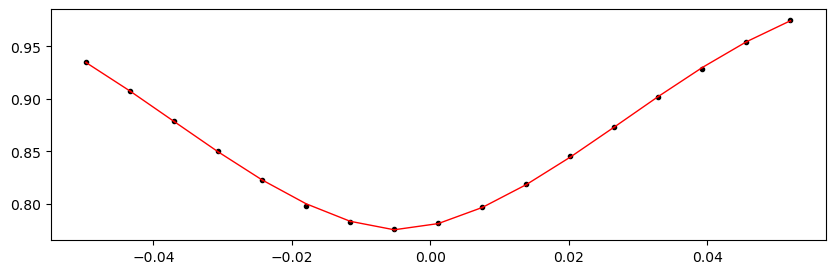

2405.5719914 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.96it/s]


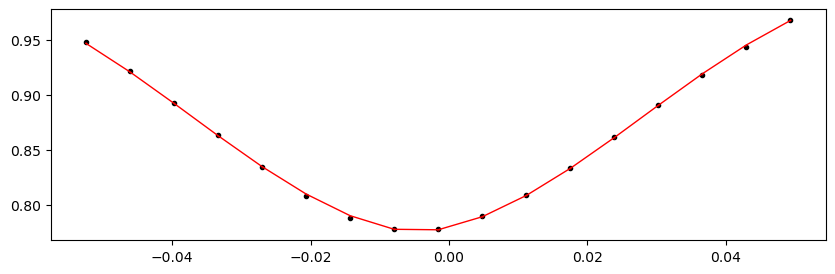

2406.6637411 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.92it/s]


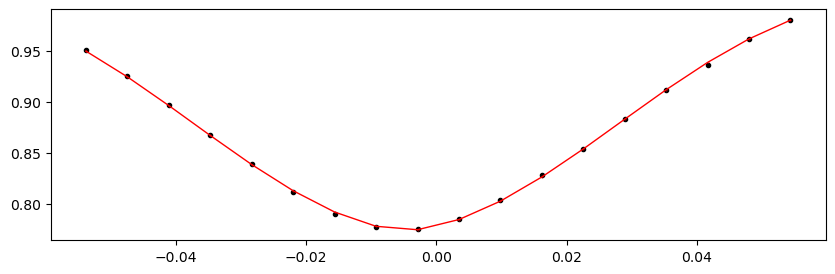

2407.7554908 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.82it/s]


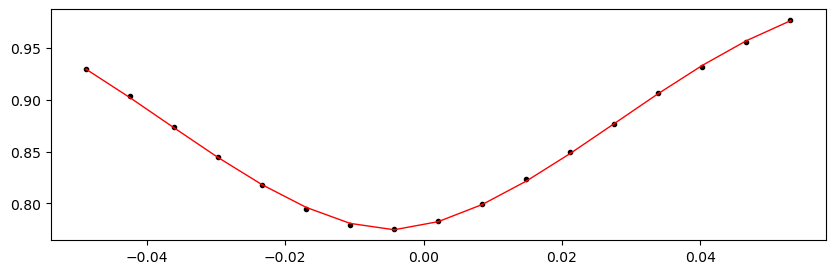

2408.8472404999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.25it/s]


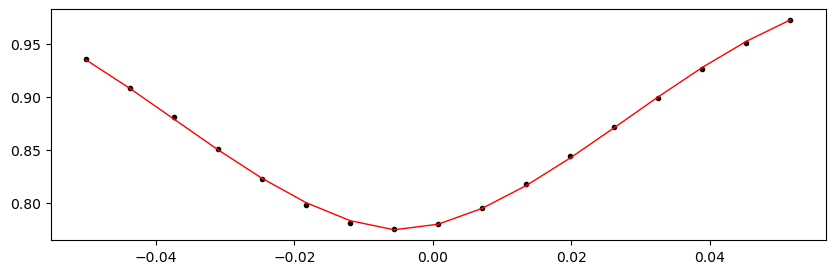

2409.9389902 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.25it/s]


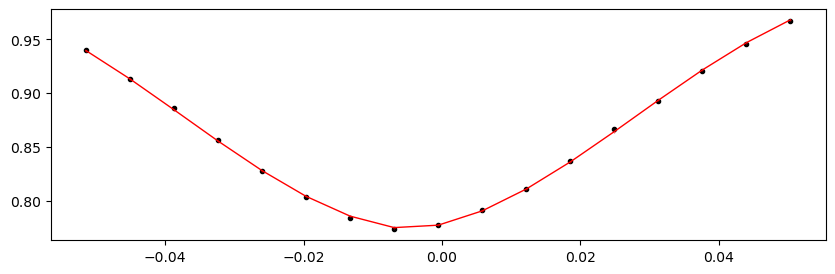

2411.0307399 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.12it/s]


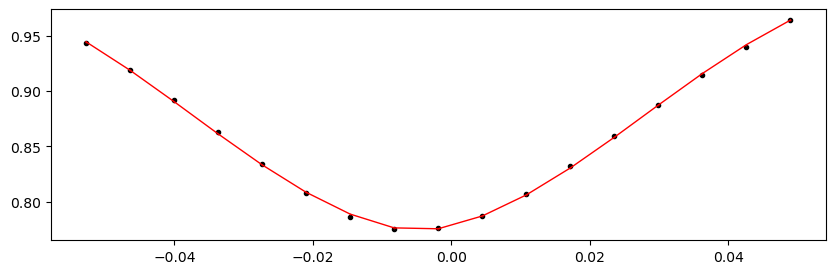

2412.1224896 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.36it/s]


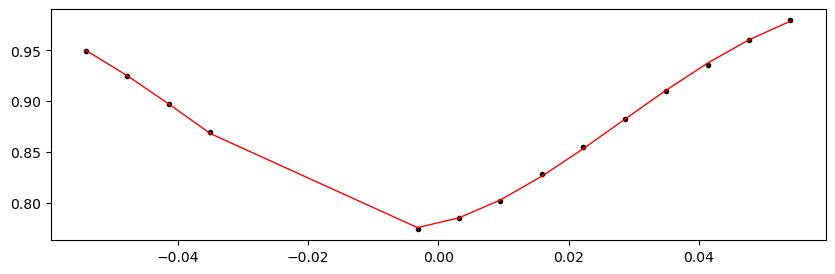

2413.2142393 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.06it/s]


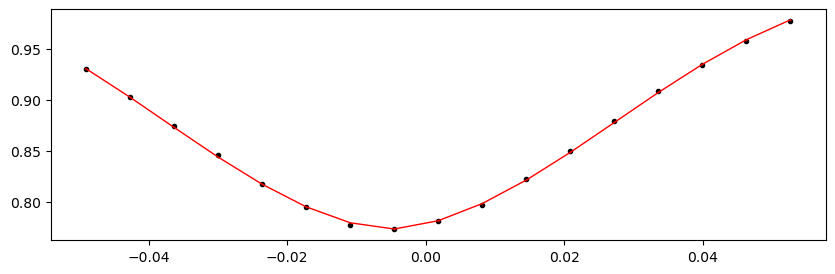

2414.305989 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.13it/s]


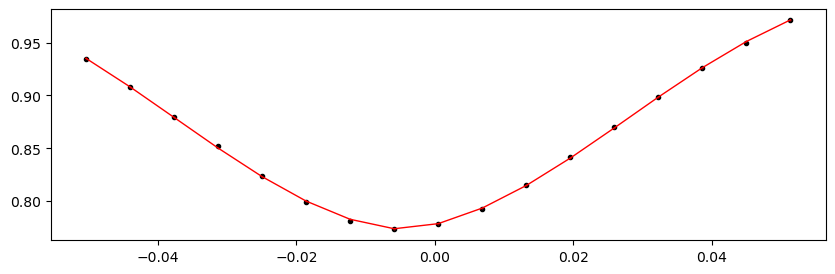

2415.3977387 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.10it/s]


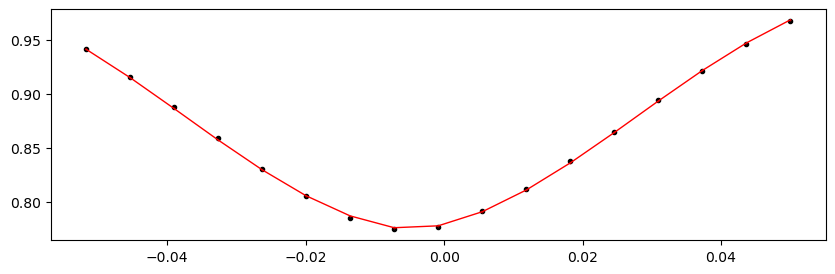

2416.4894884 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.37it/s]


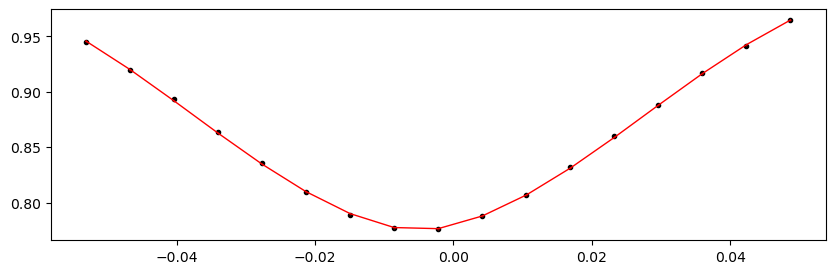

2417.5812381 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.69it/s]


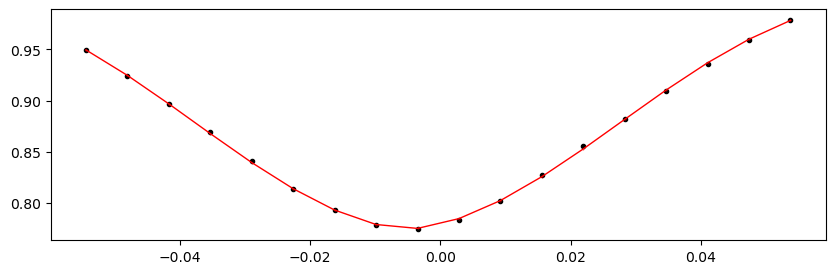

2418.6729877999996 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.94it/s]


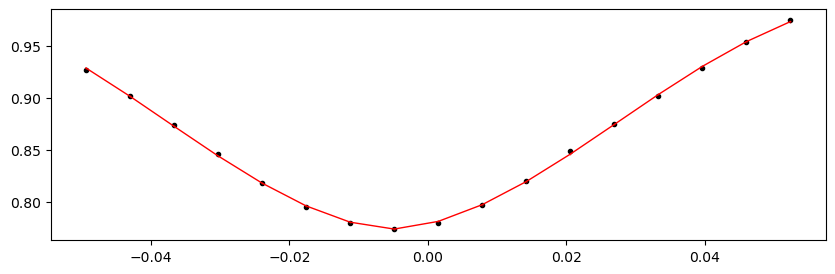

2582.4354427999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.92it/s]


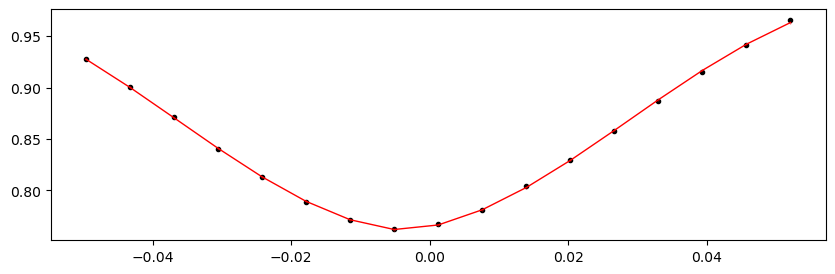

2583.5271924999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.39it/s]


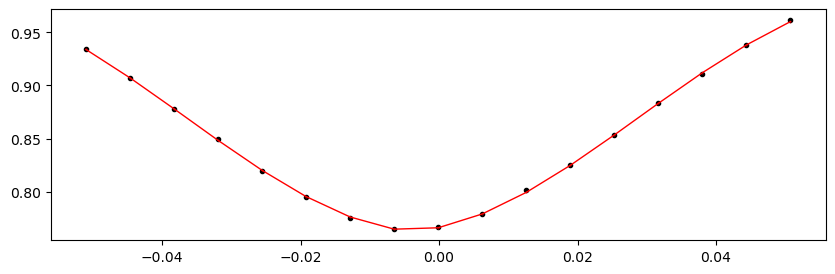

2584.6189421999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.69it/s]


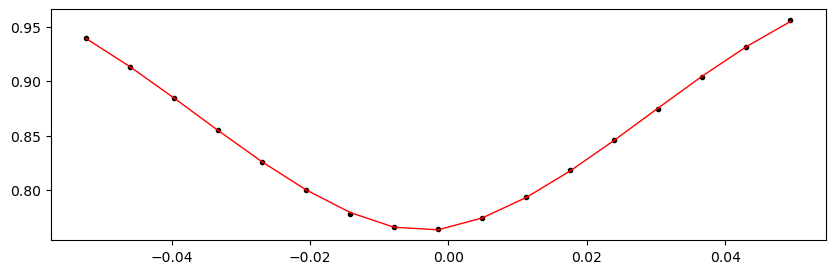

2585.7106919 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.84it/s]


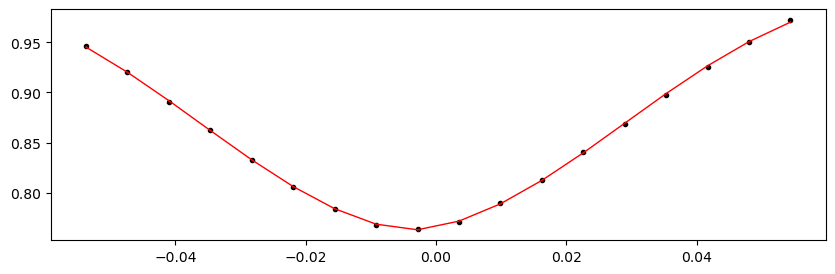

2586.8024416 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.03it/s]


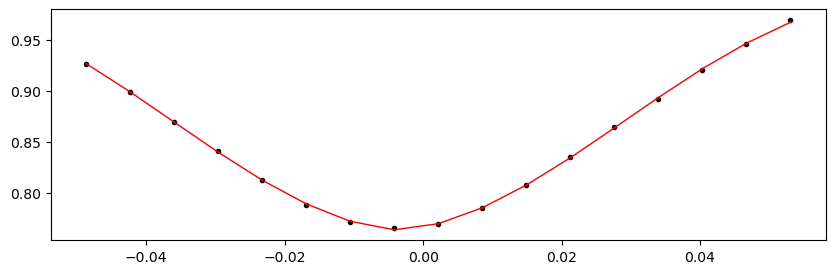

2587.8941913 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.34it/s]


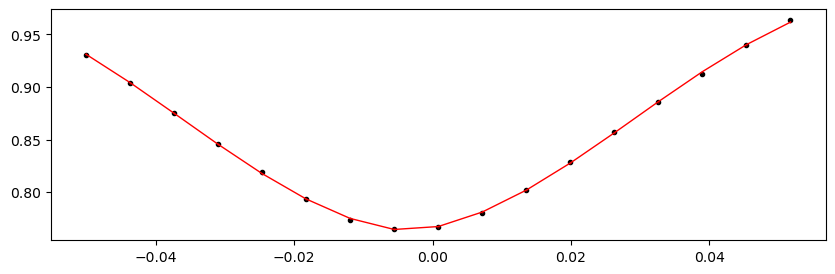

2588.985941 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|████████████████████████████████████████████████████████| 10000/10000 [07:44<00:00, 21.54it/s]


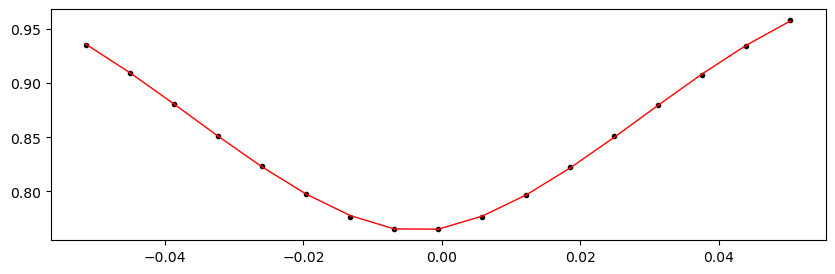

2590.0776907 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.20it/s]


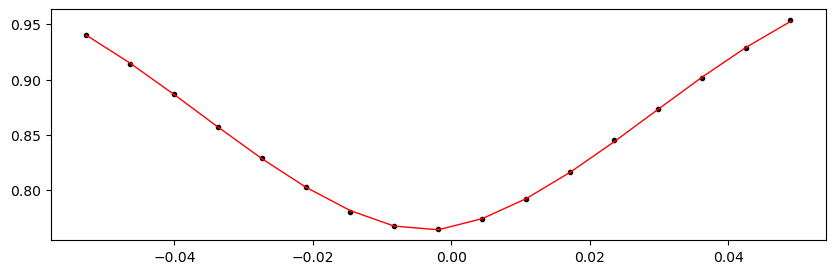

2591.1694404 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.29it/s]


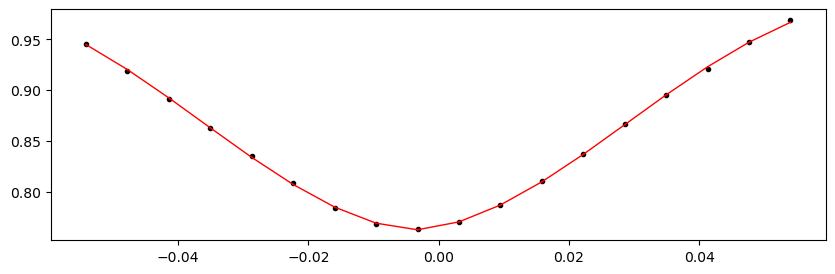

2592.2611901 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.30it/s]


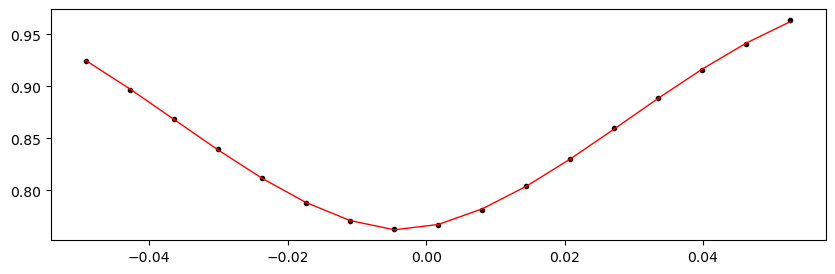

2596.6281889 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.57it/s]


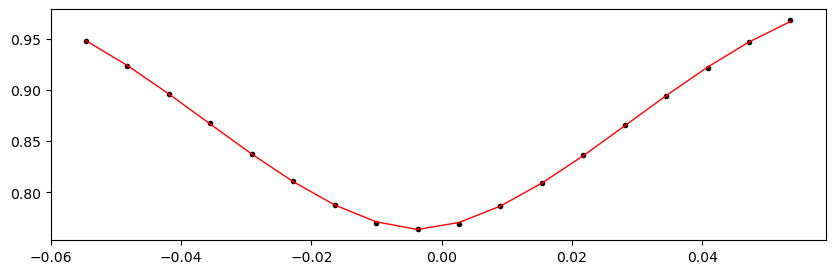

2597.7199386 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.33it/s]


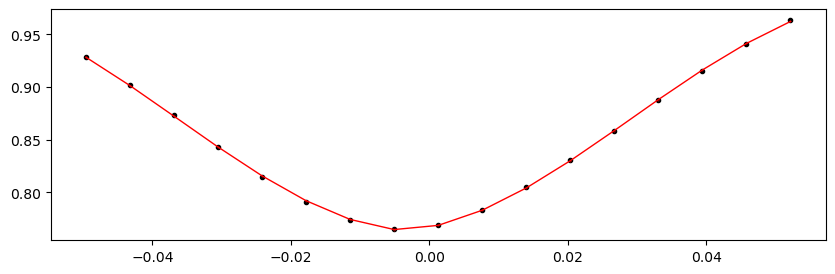

2598.8116883 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.16it/s]


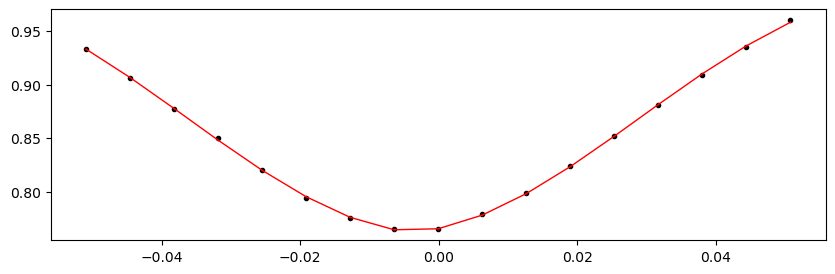

2599.903438 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.58it/s]


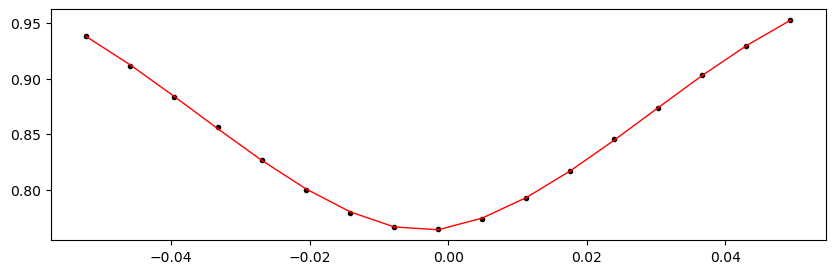

2600.9951877 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.46it/s]


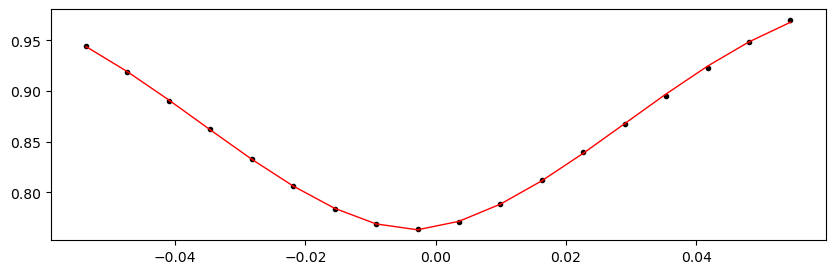

2602.0869374 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.72it/s]


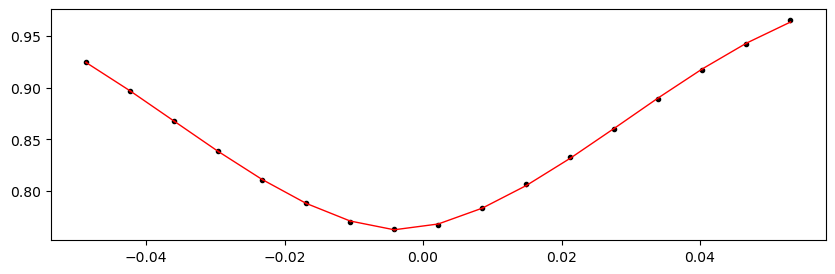

2603.1786871 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.55it/s]


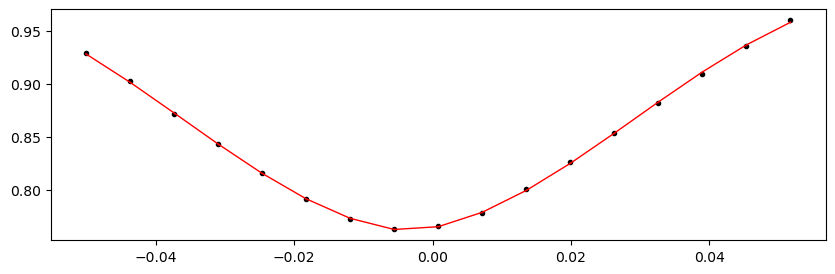

2604.2704368 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.77it/s]


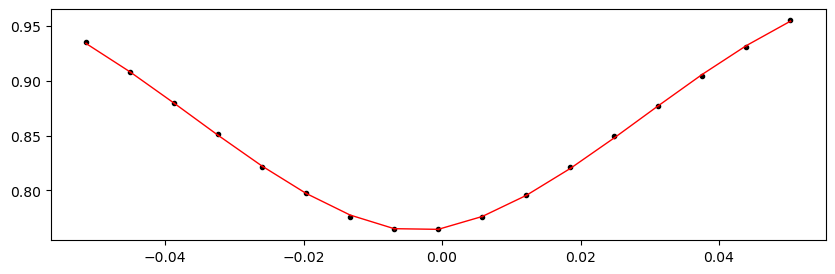

2605.3621865 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.29it/s]


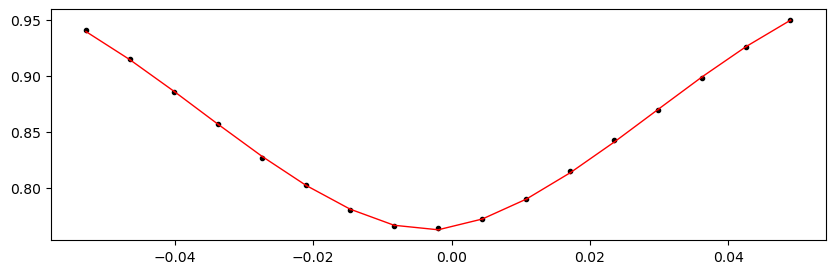

2606.4539362 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.76it/s]


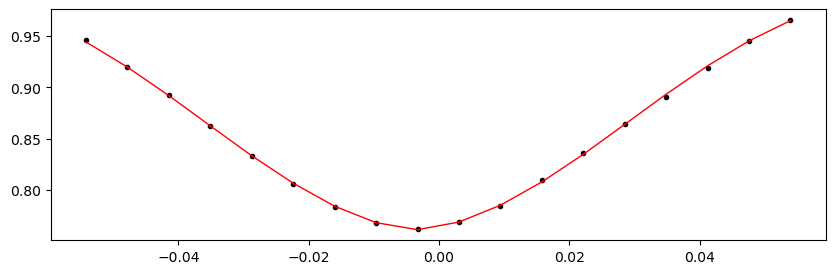

2744.0143983999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.55it/s]


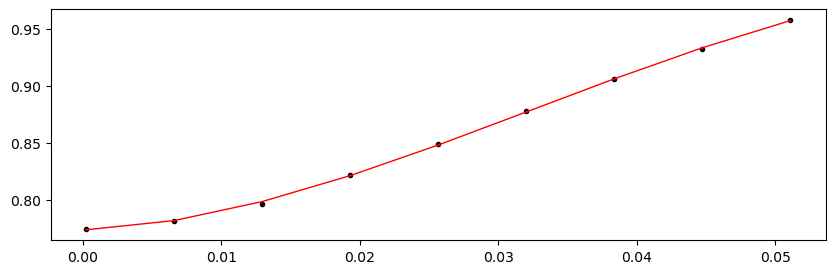

2745.1061480999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 434.83it/s]


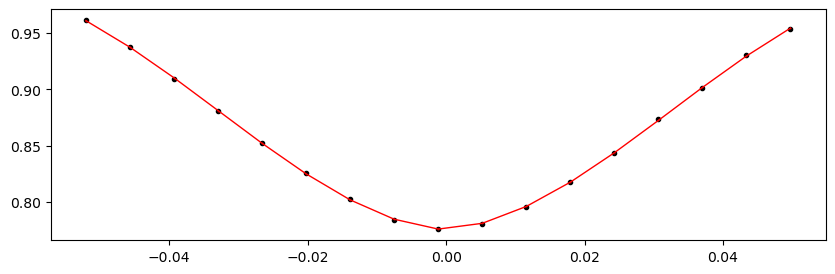

2746.1978977999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.05it/s]


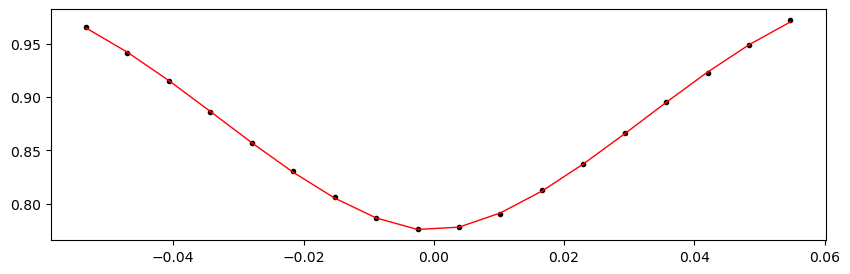

2747.2896475 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.19it/s]


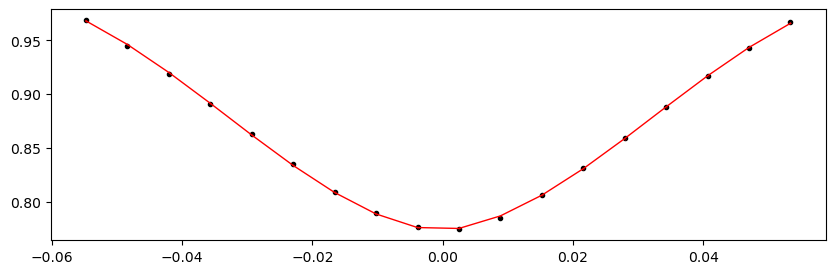

2748.3813972 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.07it/s]


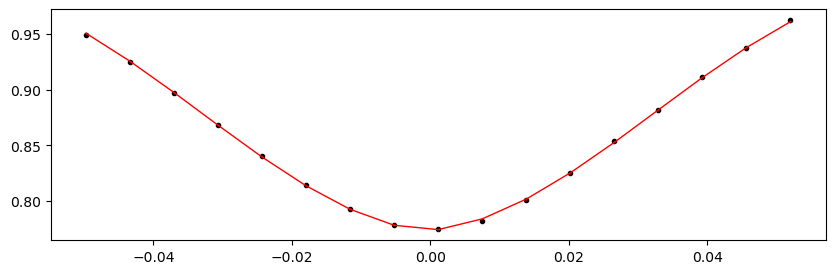

2749.4731469 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.57it/s]


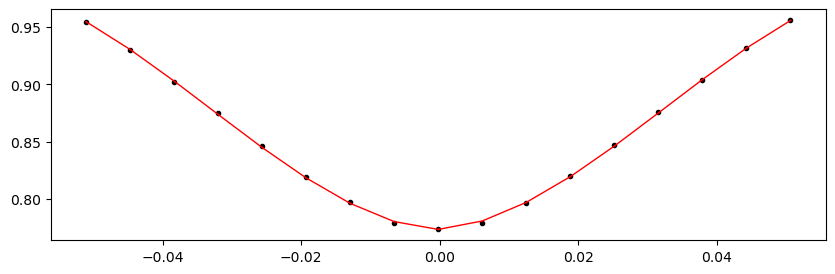

2750.5648966 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.94it/s]


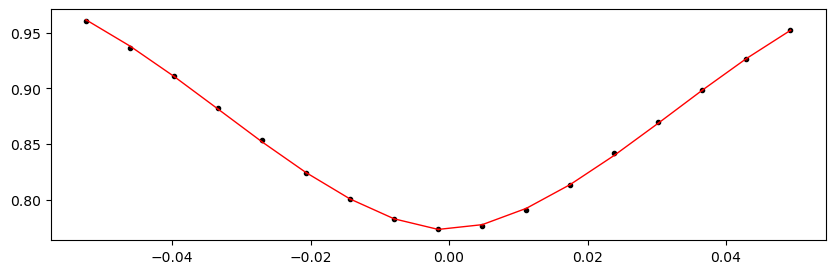

2751.6566463 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.69it/s]


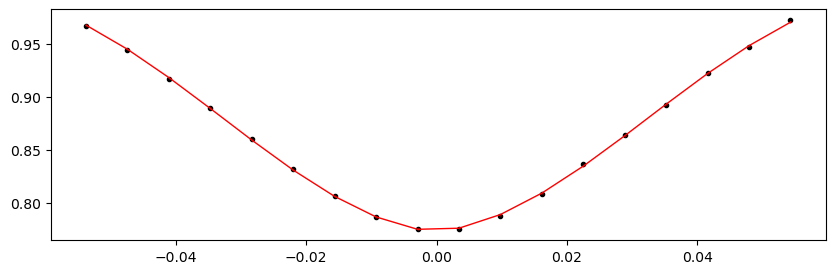

2752.748396 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.42it/s]


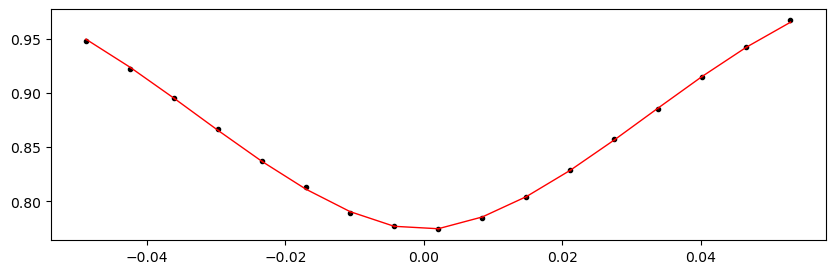

2753.8401457 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.93it/s]


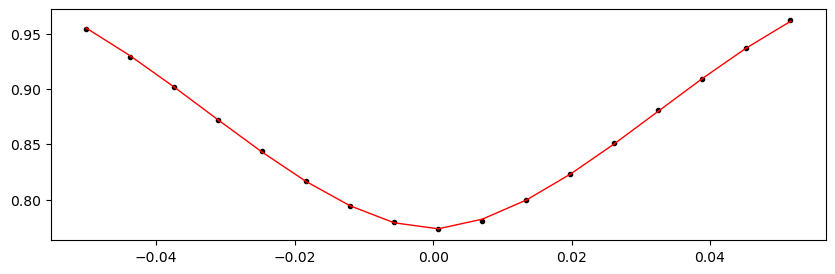

2754.9318954 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.09it/s]


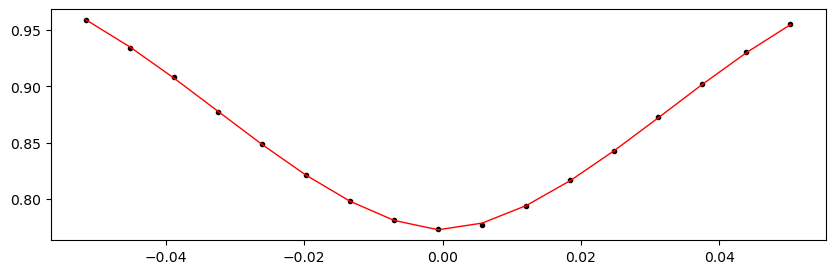

Time 2756.0236451 does not have enough data points: 4
2757.1153948 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.15it/s]


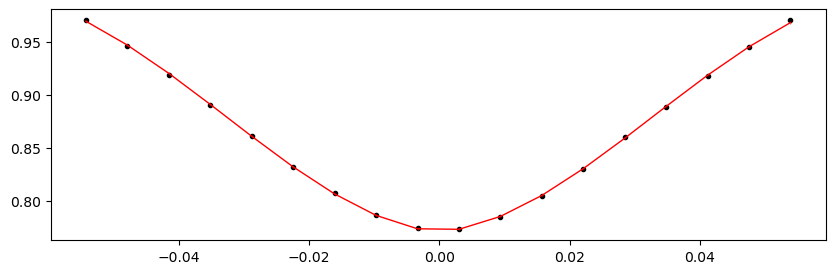

2758.2071445 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.07it/s]


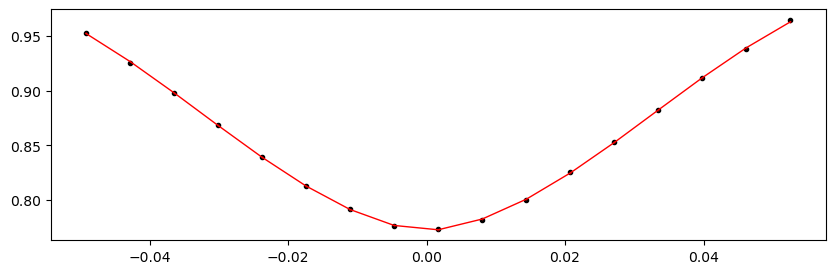

2759.2988942 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.66it/s]


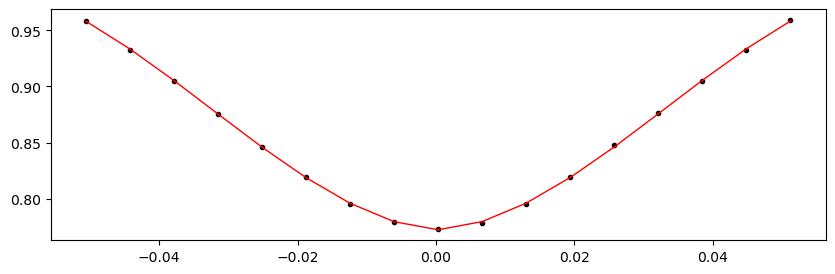

2760.3906439 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.34it/s]


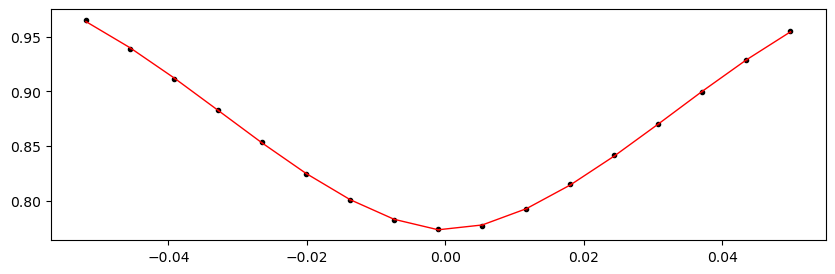

2761.4823936 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.41it/s]


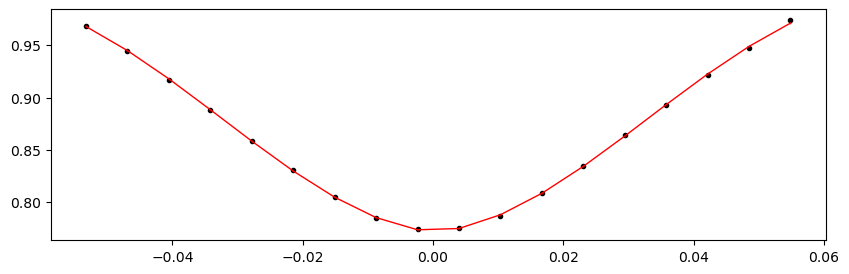

2762.5741433 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.80it/s]


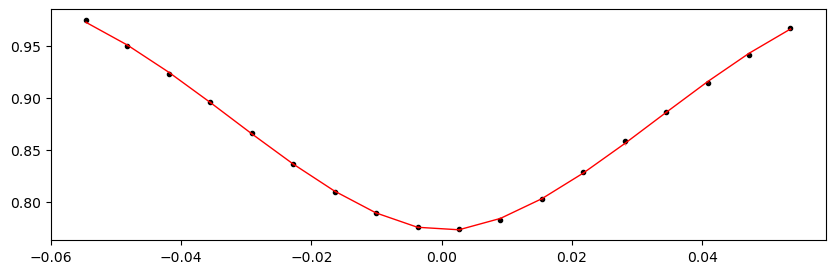

2763.665893 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.18it/s]


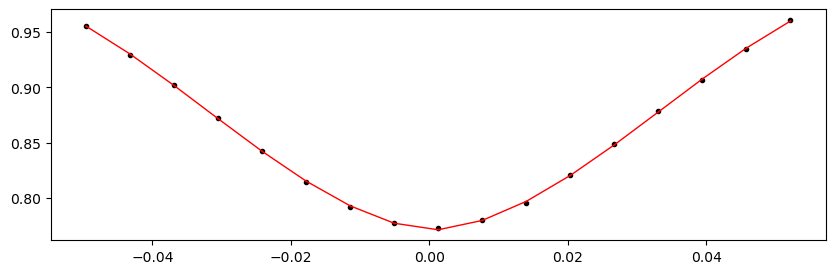

2764.7576427 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.33it/s]


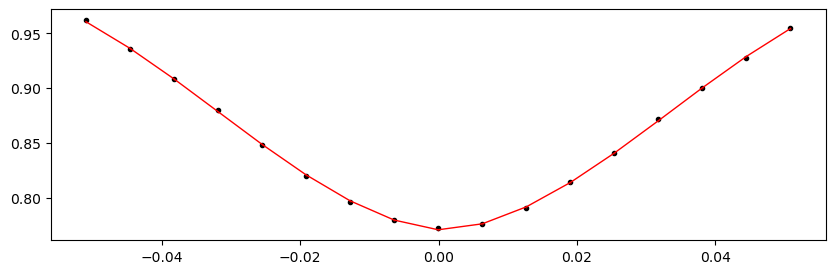

2765.8493924 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.07it/s]


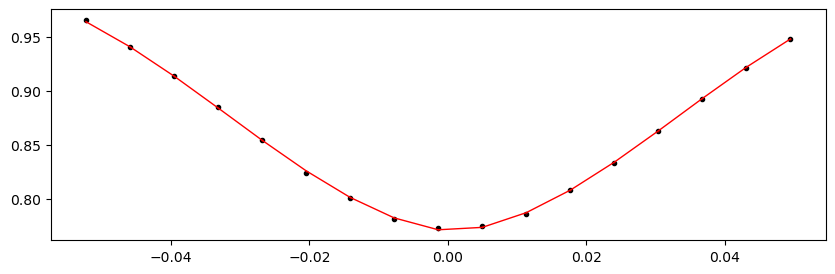

2766.9411421 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.30it/s]


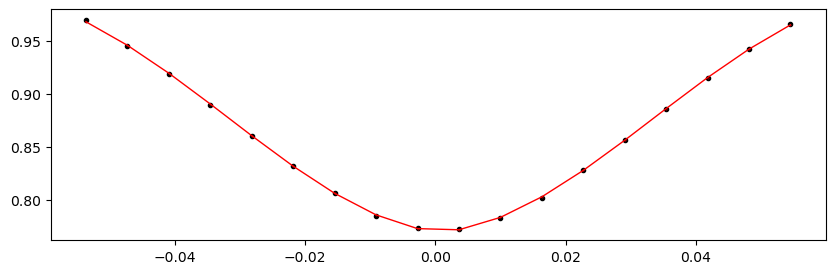

2768.0328918 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.93it/s]


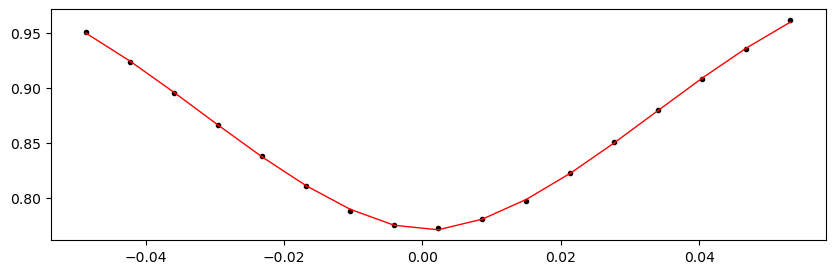

2912.1438522 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.34it/s]


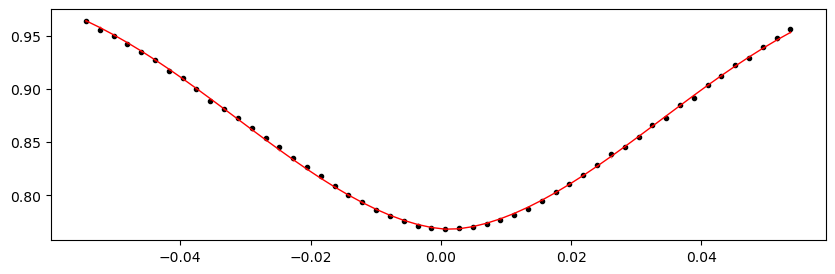

2913.2356019 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.22it/s]


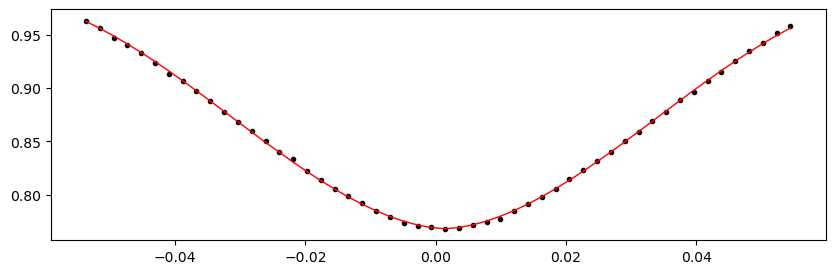

2914.3273516 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.58it/s]


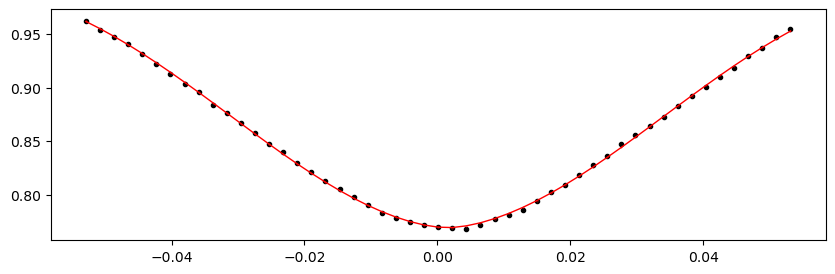

2915.4191013 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.30it/s]


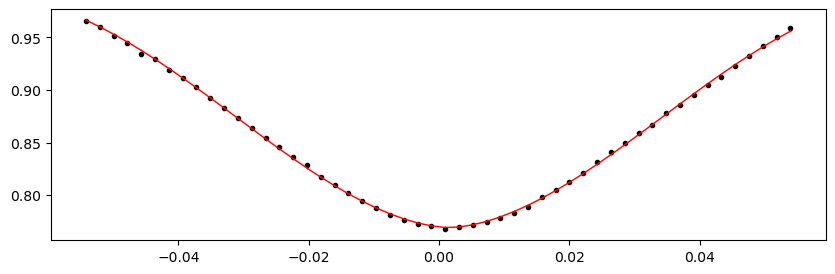

2916.510851 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.73it/s]


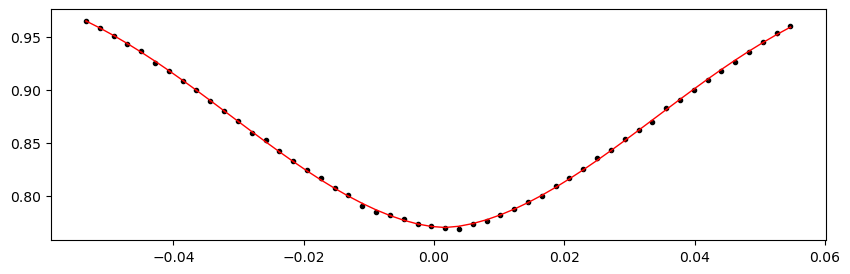

2917.6026007 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.96it/s]


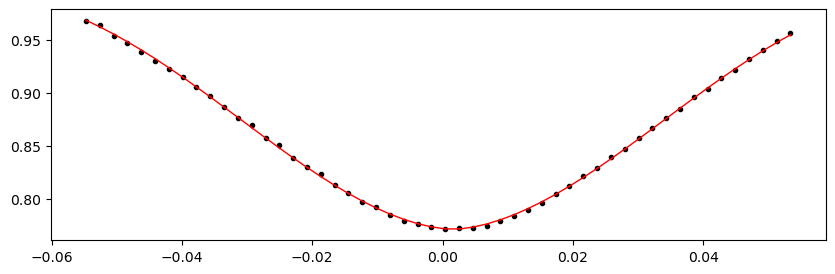

2918.6943504 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.96it/s]


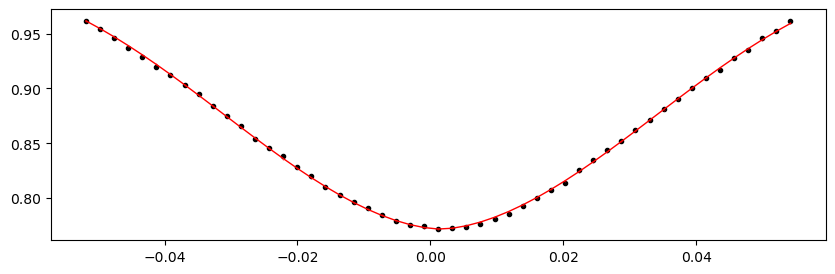

2919.7861001 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.32it/s]


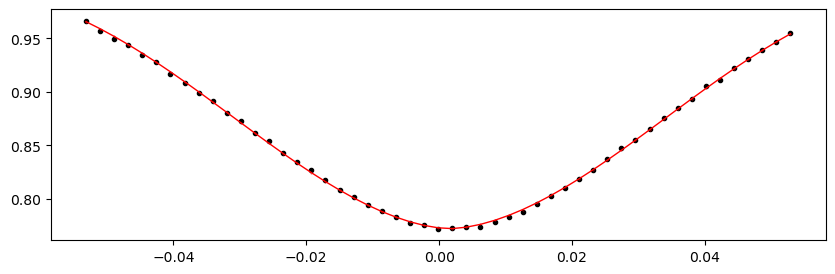

2920.8778498 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.61it/s]


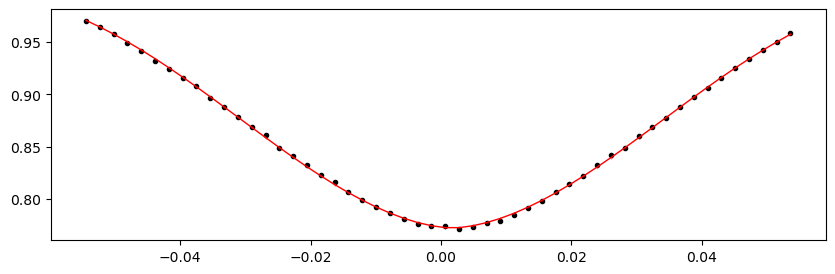

2921.9695995 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.72it/s]


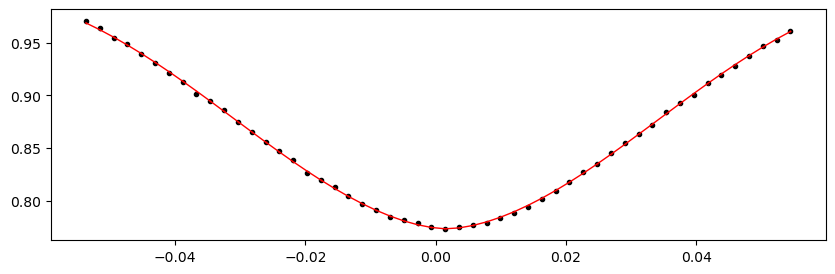

2923.0613492 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.77it/s]


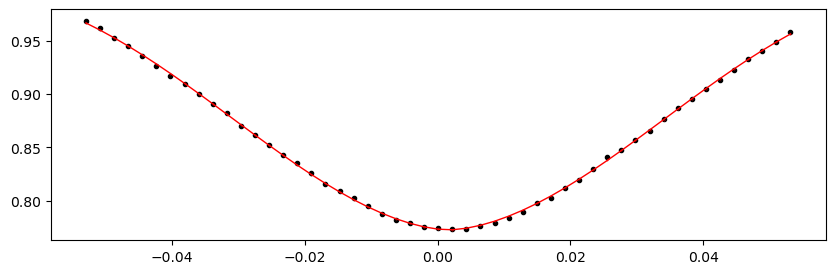

2926.3365983 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.95it/s]


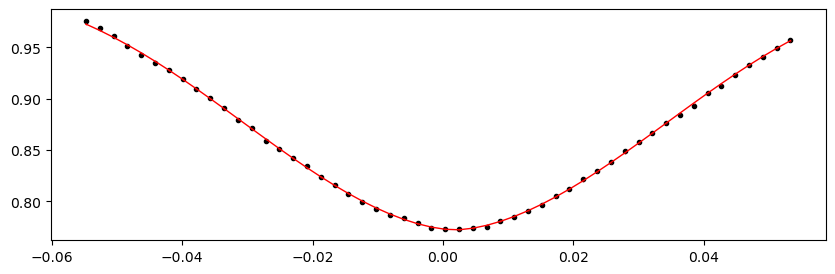

2927.428348 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.47it/s]


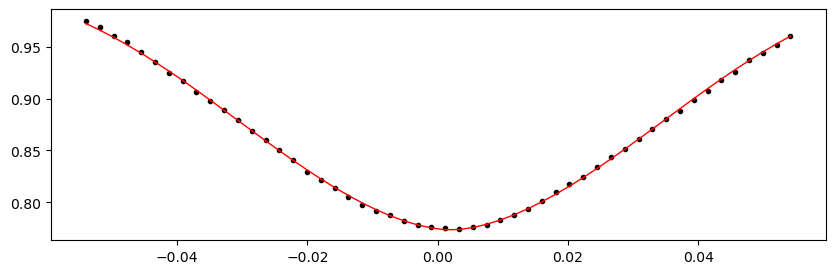

2928.5200977 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.50it/s]


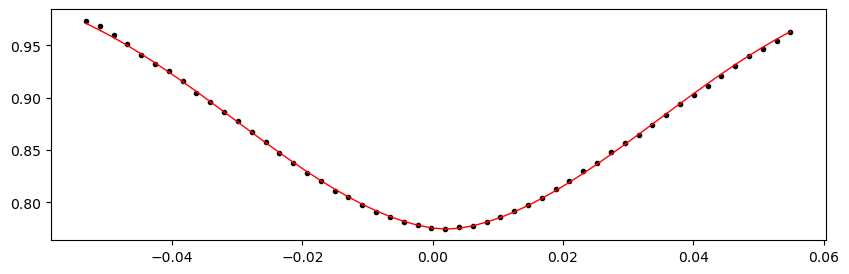

2929.6118474 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.77it/s]


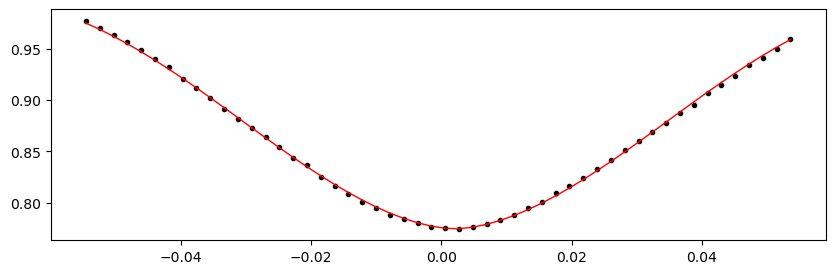

2930.7035971 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.51it/s]


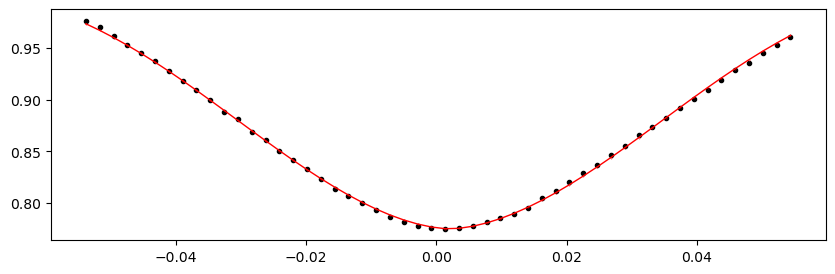

2931.7953467999996 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.97it/s]


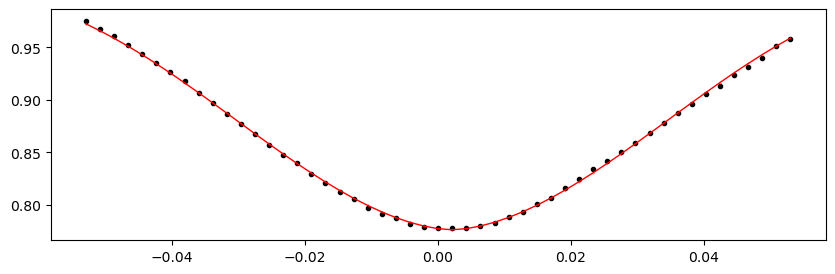

2932.8870964999996 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.80it/s]


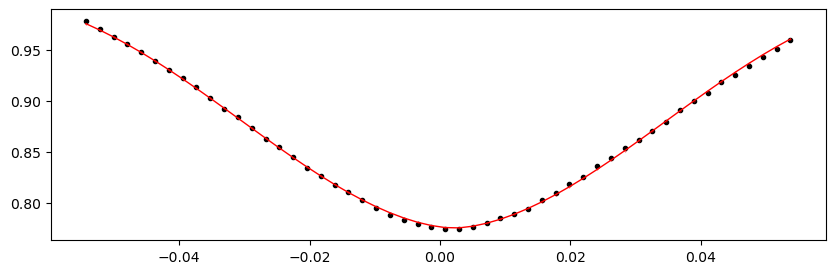

2933.9788461999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.46it/s]


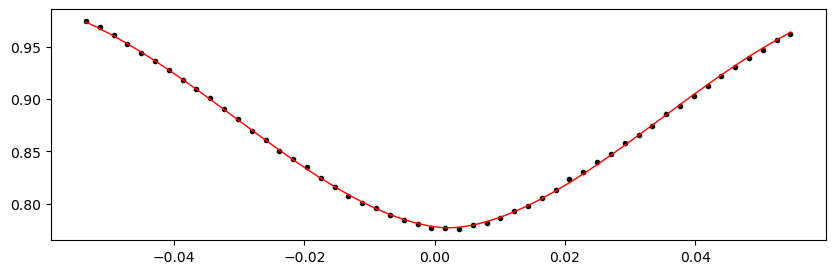

2935.0705958999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.91it/s]


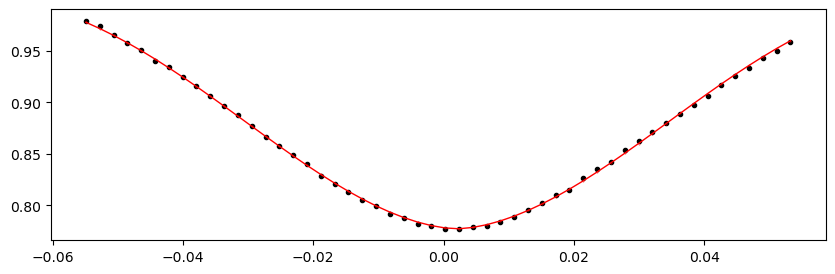

2936.1623455999998 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.40it/s]


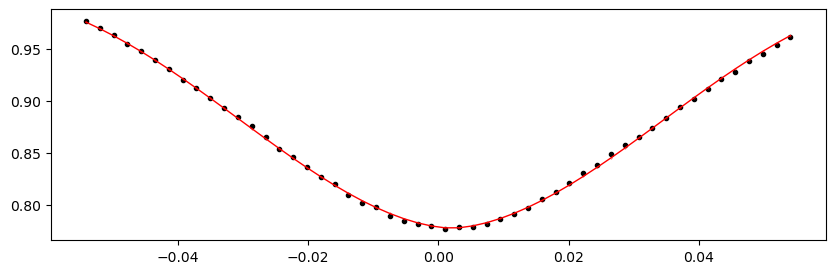

2940.5293444 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.71it/s]


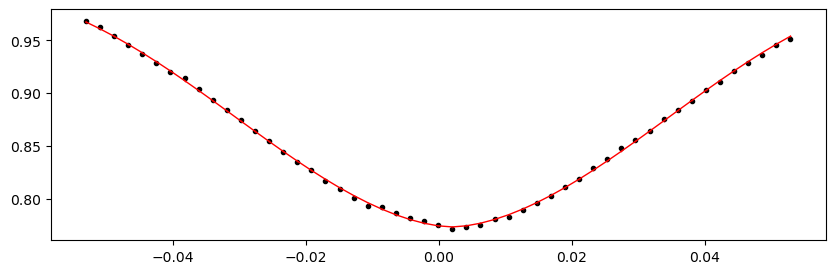

2941.6210941 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.54it/s]


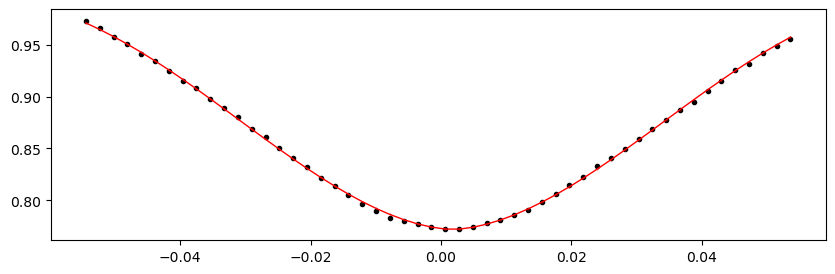

2942.7128438 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.07it/s]


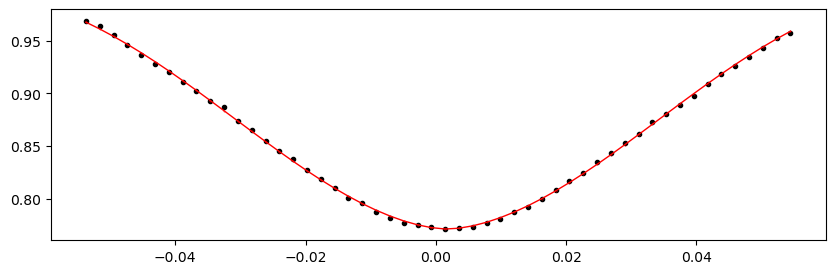

2944.8963432 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.13it/s]


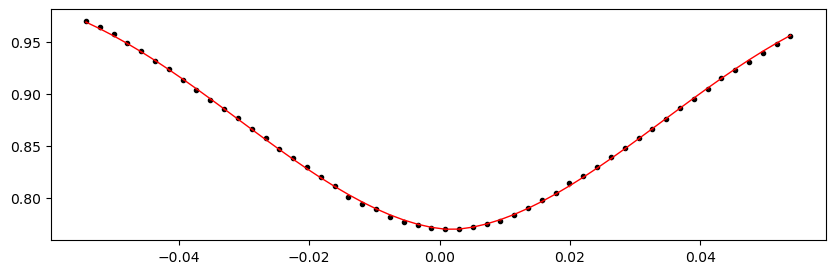

2945.9880929 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.69it/s]


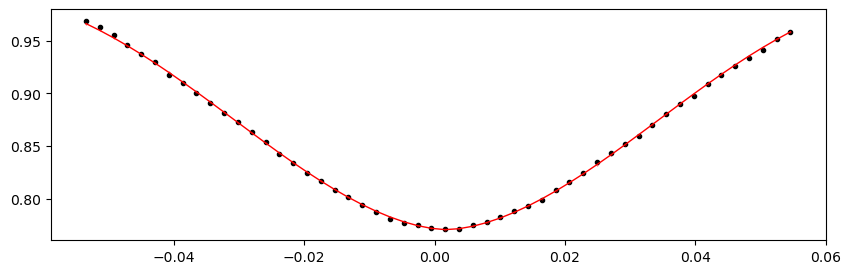

2947.0798426 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.00it/s]


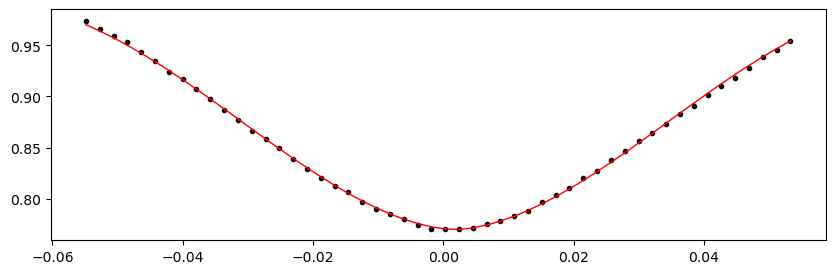

2948.1715923 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.81it/s]


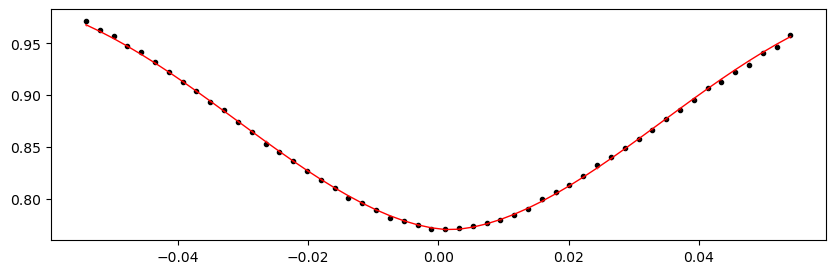

2949.263342 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.64it/s]


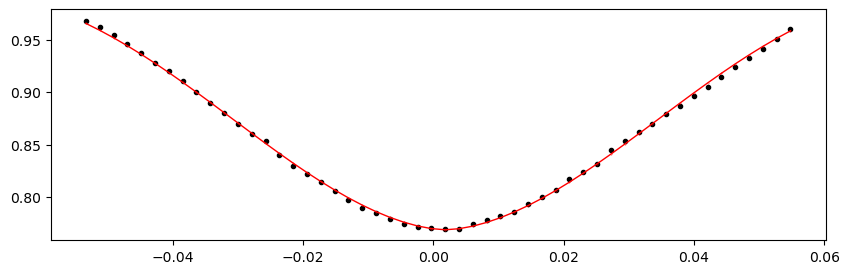

2955.8138402 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.30it/s]


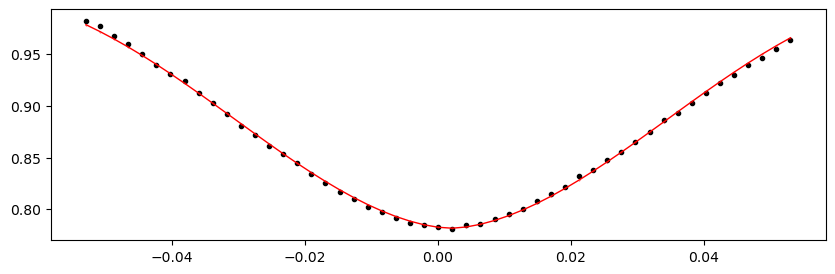

2956.9055899 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.97it/s]


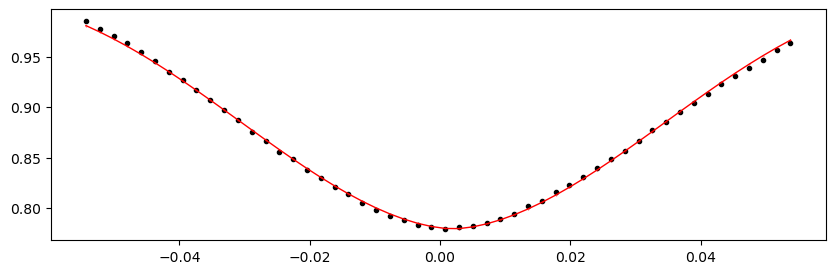

2957.9973396 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.11it/s]


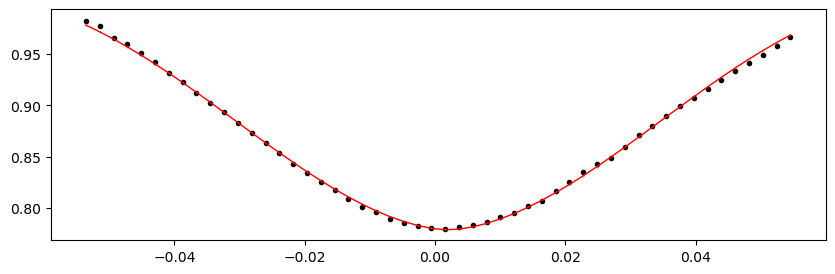

2959.0890892999996 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.80it/s]


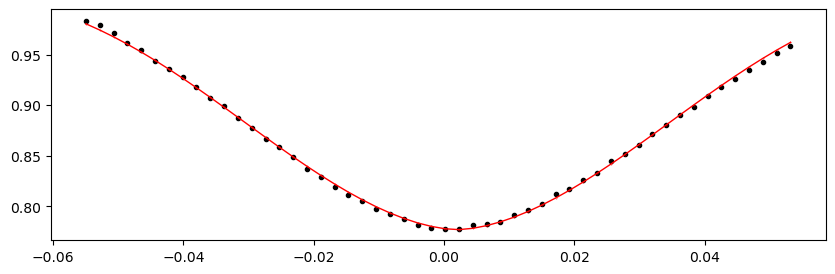

2960.1808389999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.40it/s]


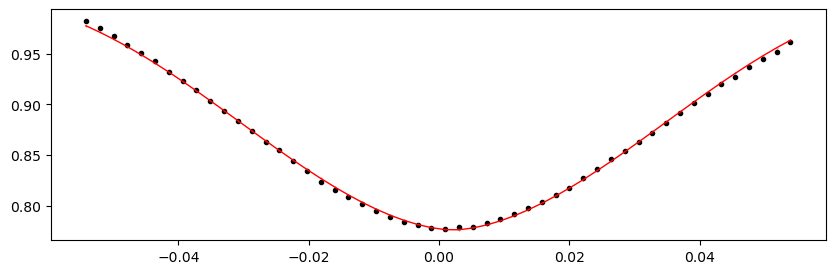

2961.2725886999997 1.0081653504660109 -0.2353169754335197 -0.27548443343062773


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.91it/s]


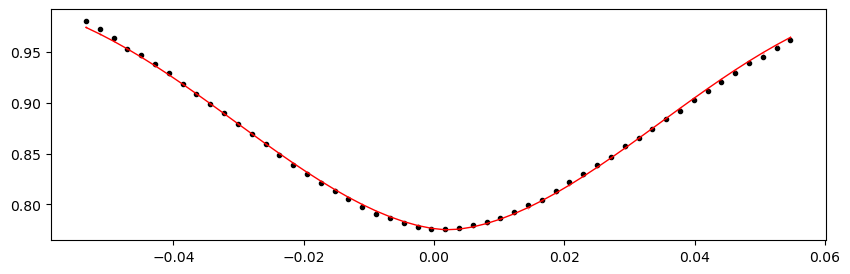

In [29]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                               min_number_data=5,   # accomodate 30min cadence TESS-SPOC in sectors 19-20
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

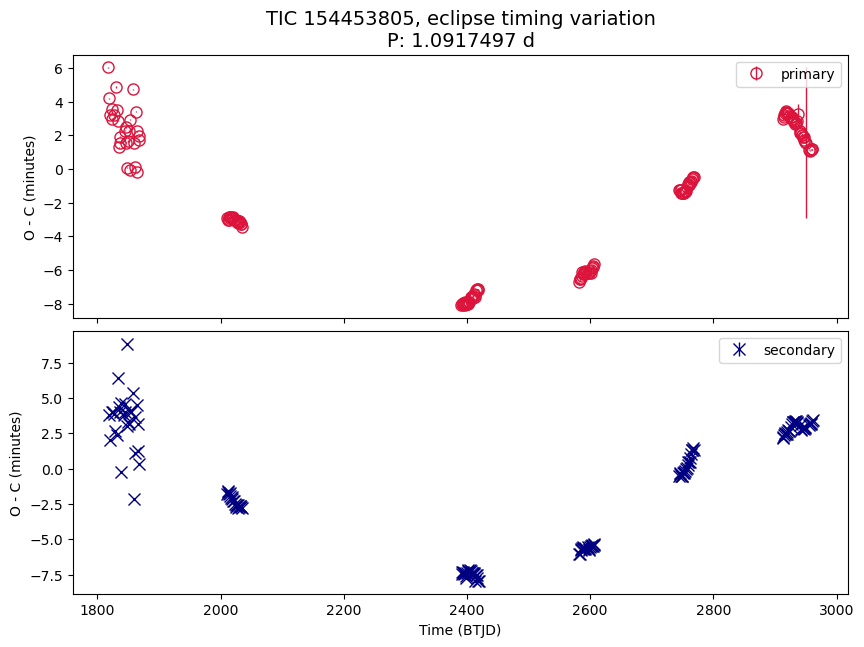

In [30]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### Compare with O-C plot with ingress/egess in the model

based on cliipped lightcurve with 1.2X eclipse duration

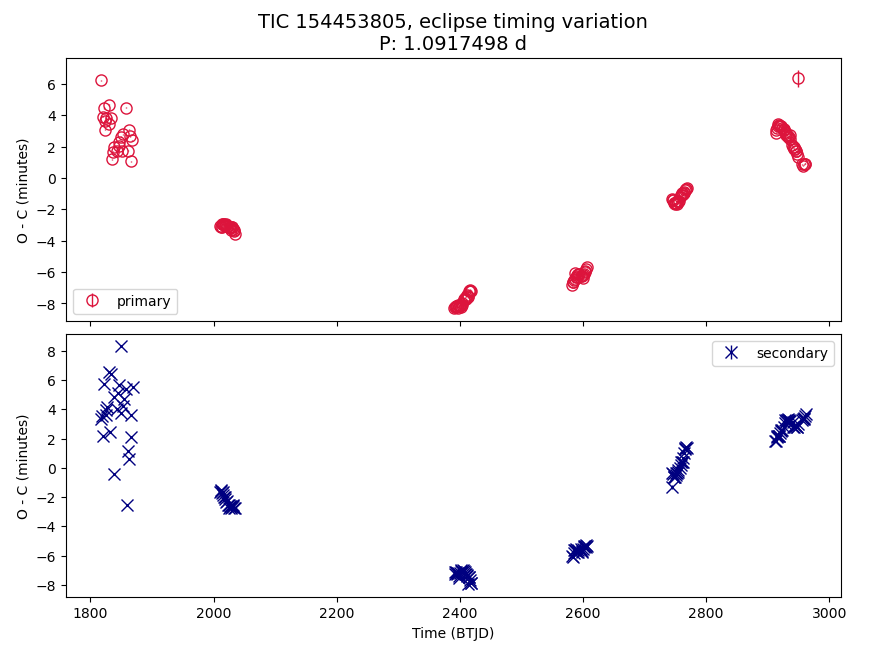


### O-C Plot, Zoom In

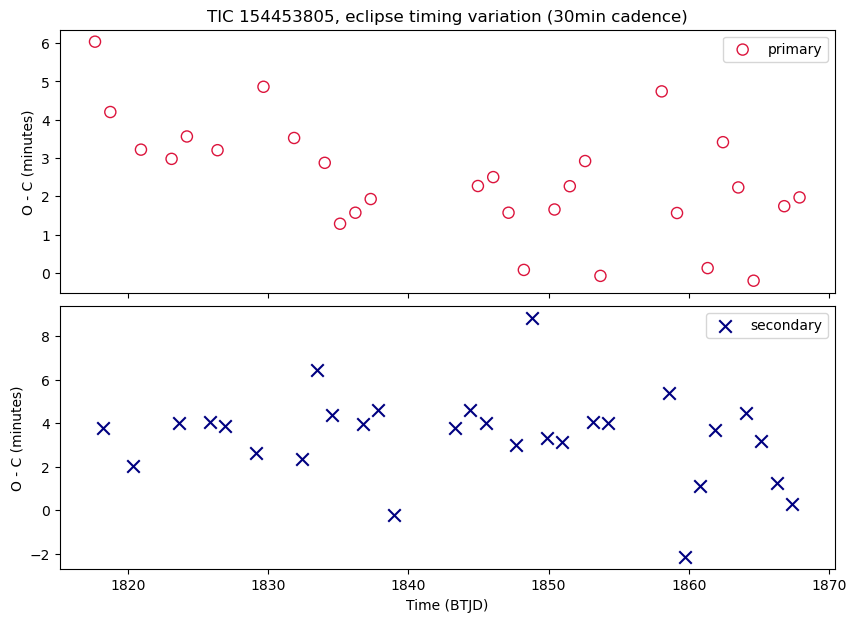

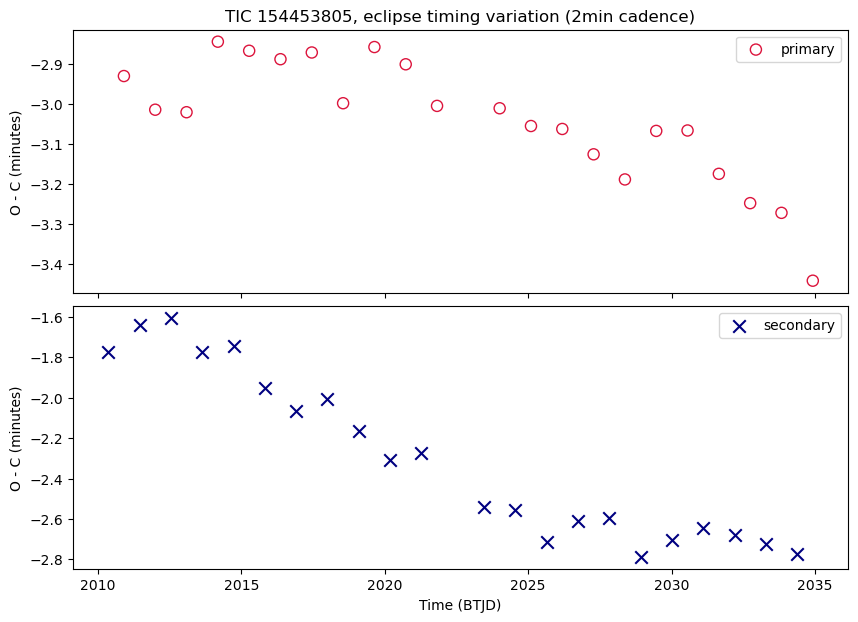

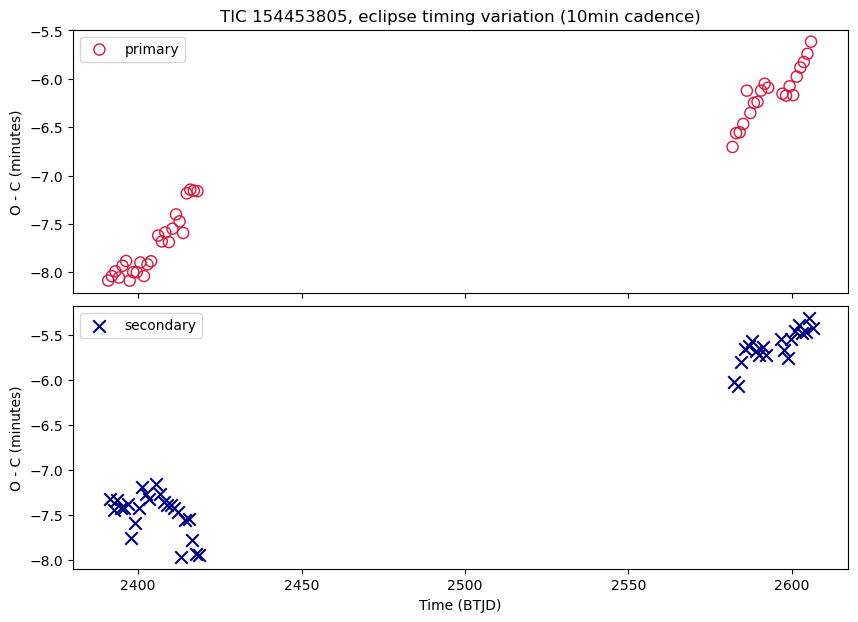

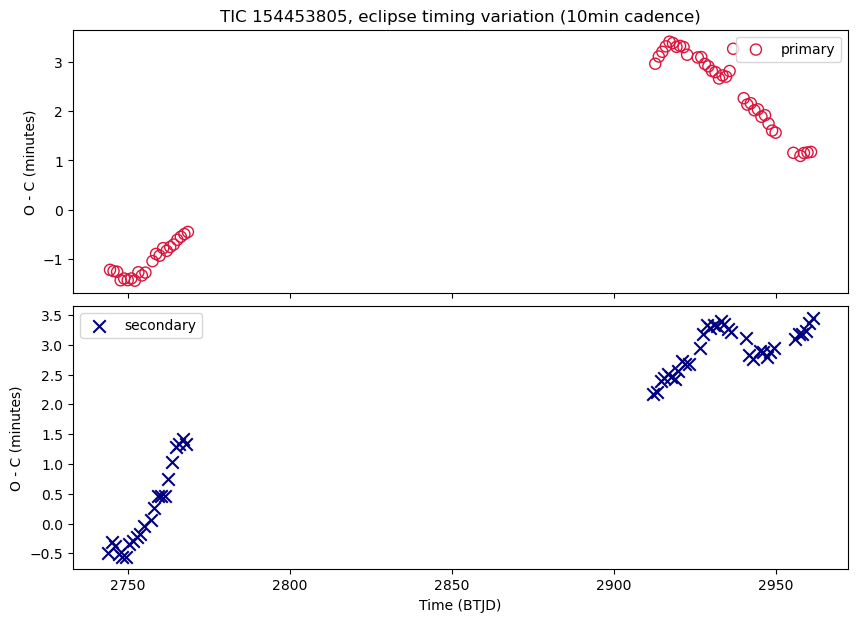

In [31]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1700, 1900),
    (1900, 2100),
    (2300, 2700),
    (2700, 3000),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (30min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[2][0]
    ax.set_title(f"{ax.get_title()} (10min cadence)")
    ax = axs_list[3][0]
    ax.set_title(f"{ax.get_title()} (10min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

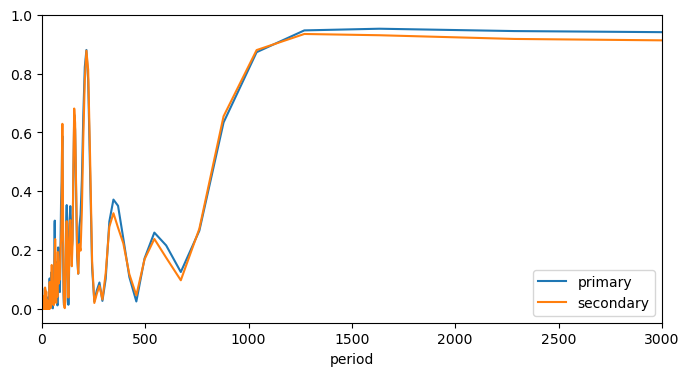

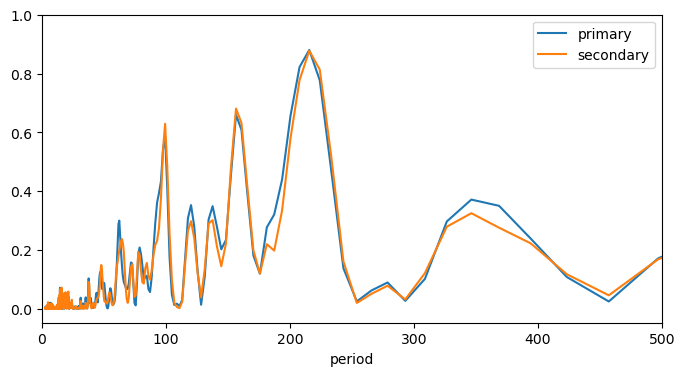

In [32]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 3000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 500)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [33]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

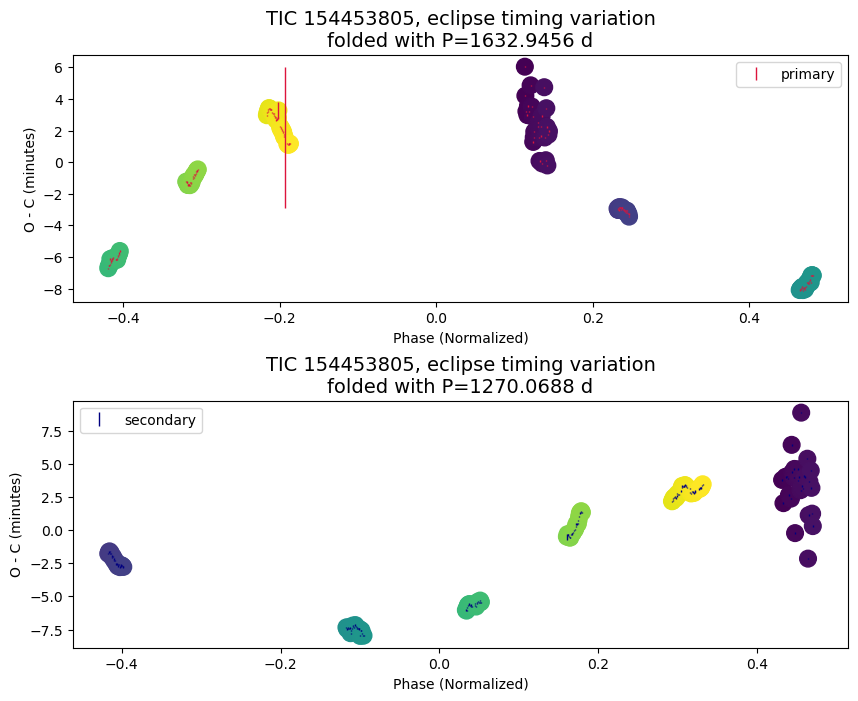

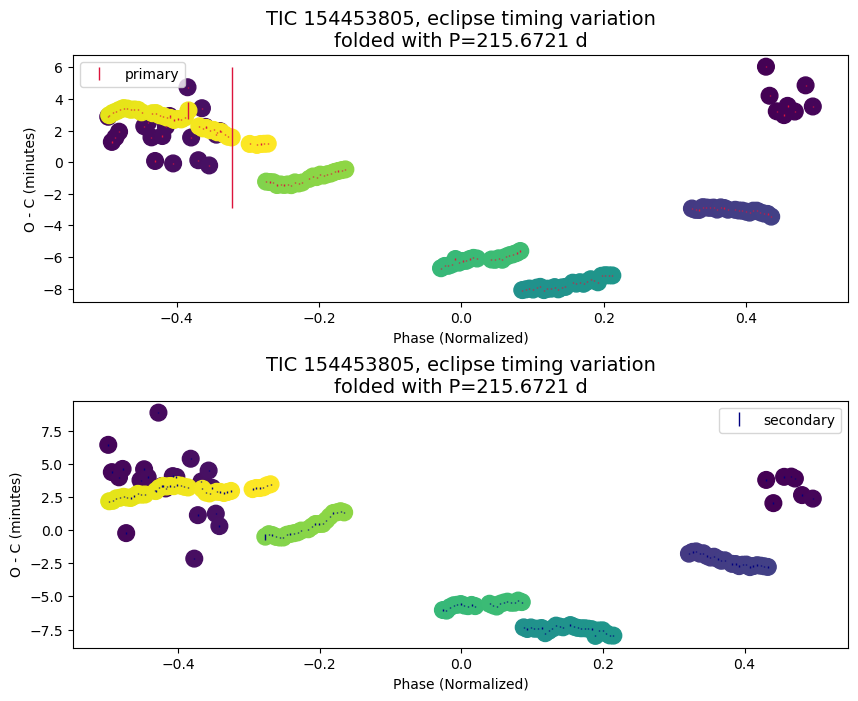

In [36]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    tweak_axs(axs)

    axs = plot_oc_folded(
        period_min=None, period_max=1000,
        period_min_s=None, period_max_s=1000
    )
    tweak_axs(axs)

## Results Summary

In [42]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "Long-term (1000+ d) non-linear trend with amplitude ~15 min in priamry / secondary, variation visible in folded LC. O-C period possibly over 1000+ days. EB : SB Period ~= 1:3.07 . [D*0.8]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                            154453805
has_etv                                                                                                                                                                                                Y
comments     Long-term (1000+ d) non-linear trend with amplitude ~15 min in priamry / secondary, variation visible in folded LC. O-C period possibly over 1000+ days. EB : SB Period ~= 1:3.07 . [D*0.8]
period                                                                                                                                                                                           1.09175
depth_pct_p                                                                                                                                                                                        30.96
depth_pct_s                                                                                                                                                                                        23.53
epoch_p                                                                                                                                                                                      1816.573028
epoch_s                                                                                                                                                                                      1817.118903
num_sectors                                                                                                                                                                                            8
time_span                                                                                                                                                                                        1146.47
time_start                                                                                                                                                                                       1816.12
time_end                                                                                                                                                                                         2962.58


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
154453805,Y,"Long-term (1000+ d) non-linear trend with amplitude ~15 min in priamry / secondary, variation visible in folded LC. O-C period possibly over 1000+ days. EB : SB Period ~= 1:3.07 . [D*0.8]",1.0917497,30.96,23.53,1816.5730282499999,1817.1189031,8,1146.47,1816.12,2962.58

